infrastrcutre = colums 28 - -4
converted infrastucture into ints of 0s and 1s

one hot encoded

In [41]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


In [42]:
accident_data = pd.read_csv("ignorefolder/cleaned_US_Accidents.csv", index_col=0)
print(accident_data.shape)

(988706, 25)


In [44]:
print(accident_data.columns)

Index(['Severity', 'State', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sample Counts'],
      dtype='object')


In [45]:
county_data = gpd.read_file("zip:county_data.gpkg.zip")
county_data.to_crs("4269")

drop_states = ['02', '15', '60', '66', '69', '72', '78']
mask = county_data['STATEFP'].isin(drop_states)
state_data = county_data[~mask]
state_data = state_data.dissolve(by="STATEFP")


DataSourceError: '/vsizip/county_data.gpkg.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [34]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

state_to_abbrev = {
    "alabama": "AL",
    "alaska": "AK",
    "arizona": "AZ",
    "arkansas": "AR",
    "american samoa": "AS",
    "california": "CA",
    "colorado": "CO",
    "connecticut": "CT",
    "delaware": "DE",
    "district of columbia": "DC",
    "florida": "FL",
    "georgia": "GA",
    "guam": "GU",
    "hawaii": "HI",
    "idaho": "ID",
    "illinois": "IL",
    "indiana": "IN",
    "iowa": "IA",
    "kansas": "KS",
    "kentucky": "KY",
    "louisiana": "LA",
    "maine": "ME",
    "maryland": "MD",
    "massachusetts": "MA",
    "michigan": "MI",
    "minnesota": "MN",
    "mississippi": "MS",
    "missouri": "MO",
    "montana": "MT",
    "nebraska": "NE",
    "nevada": "NV",
    "new hampshire": "NH",
    "new jersey": "NJ",
    "new mexico": "NM",
    "new york": "NY",
    "north carolina": "NC",
    "north dakota": "ND",
    "northern mariana islands": "MP",
    "ohio": "OH",
    "oklahoma": "OK",
    "oregon": "OR",
    "pennsylvania": "PA",
    "puerto rico": "PR",
    "rhode island": "RI",
    "south carolina": "SC",
    "south dakota": "SD",
    "tennessee": "TN",
    "texas": "TX",
    "trust territories": "TT",
    "utah": "UT",
    "vermont": "VT",
    "virginia": "VA",
    "virgin islands": "VI",
    "washington": "WA",
    "west virginia": "WV",
    "wisconsin": "WI",
    "wyoming": "WY"
}

accident_data['STATEFP'] = accident_data['State'].map(state_codes)

### Loading in population data for per capita calculations

In [35]:
population = pd.read_excel("ignorefolder/population.xlsx")

population = (population
    .drop(columns="Unnamed: 1")
    .iloc[8:, [0, 5]]
    .rename(columns= {population.columns[0]: "Geographic Area", population.columns[6]: "2024"})
    .reset_index(drop=True)
    .dropna()
)
population["Geographic Area"] = population["Geographic Area"].str.lstrip(".").str.lower()
#dropping puerto rico
population = population.drop(index=52)
population["State"] = population["Geographic Area"].map(state_to_abbrev)
population["STATEFP"] = population["State"].map(state_codes)

### Accidents by States

In [38]:
counts_by_state = accident_data.groupby('STATEFP')[['State']].count().reset_index().rename(columns={"State": "counts"})
counts_by_state = counts_by_state.merge(population[["STATEFP", "2024"]], on="STATEFP", how="left")
counts_by_state["percapita"] = counts_by_state["counts"] / counts_by_state["2024"]

In [39]:
geographic_data = gpd.GeoDataFrame(counts_by_state.merge(state_data, on='STATEFP'), geometry='geometry')

<AxesSubplot: >

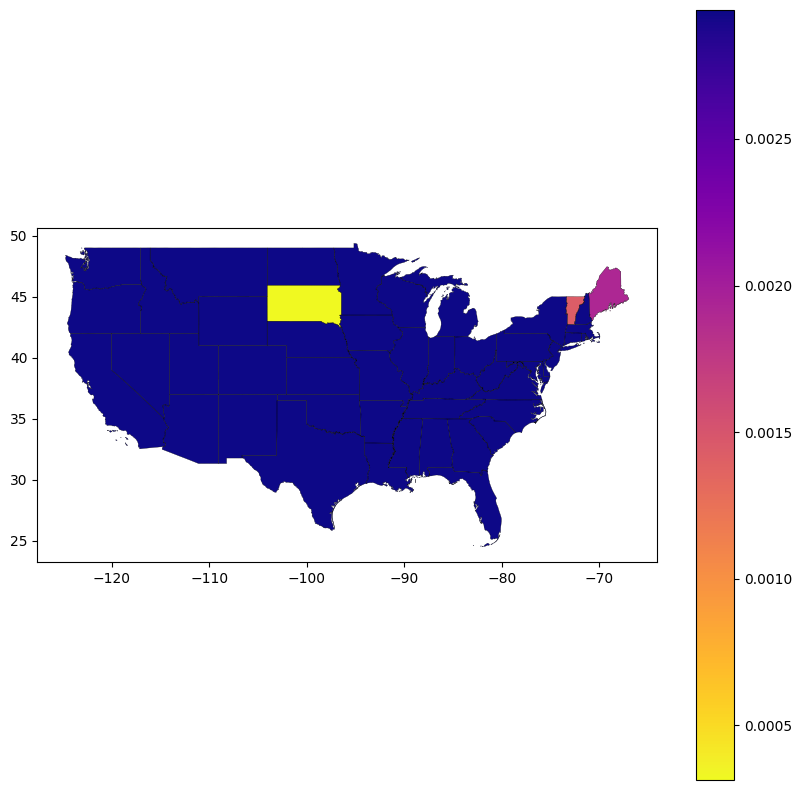

In [40]:
fig, ax = plt.subplots(1, figsize=(10,10))
state_data.to_crs("5071")
state_data.boundary.plot(linewidth=0.2, color='black', ax=ax)
geographic_data.plot(column='percapita', legend=True, cmap='plasma_r', ax=ax)

### Infrastructure by States

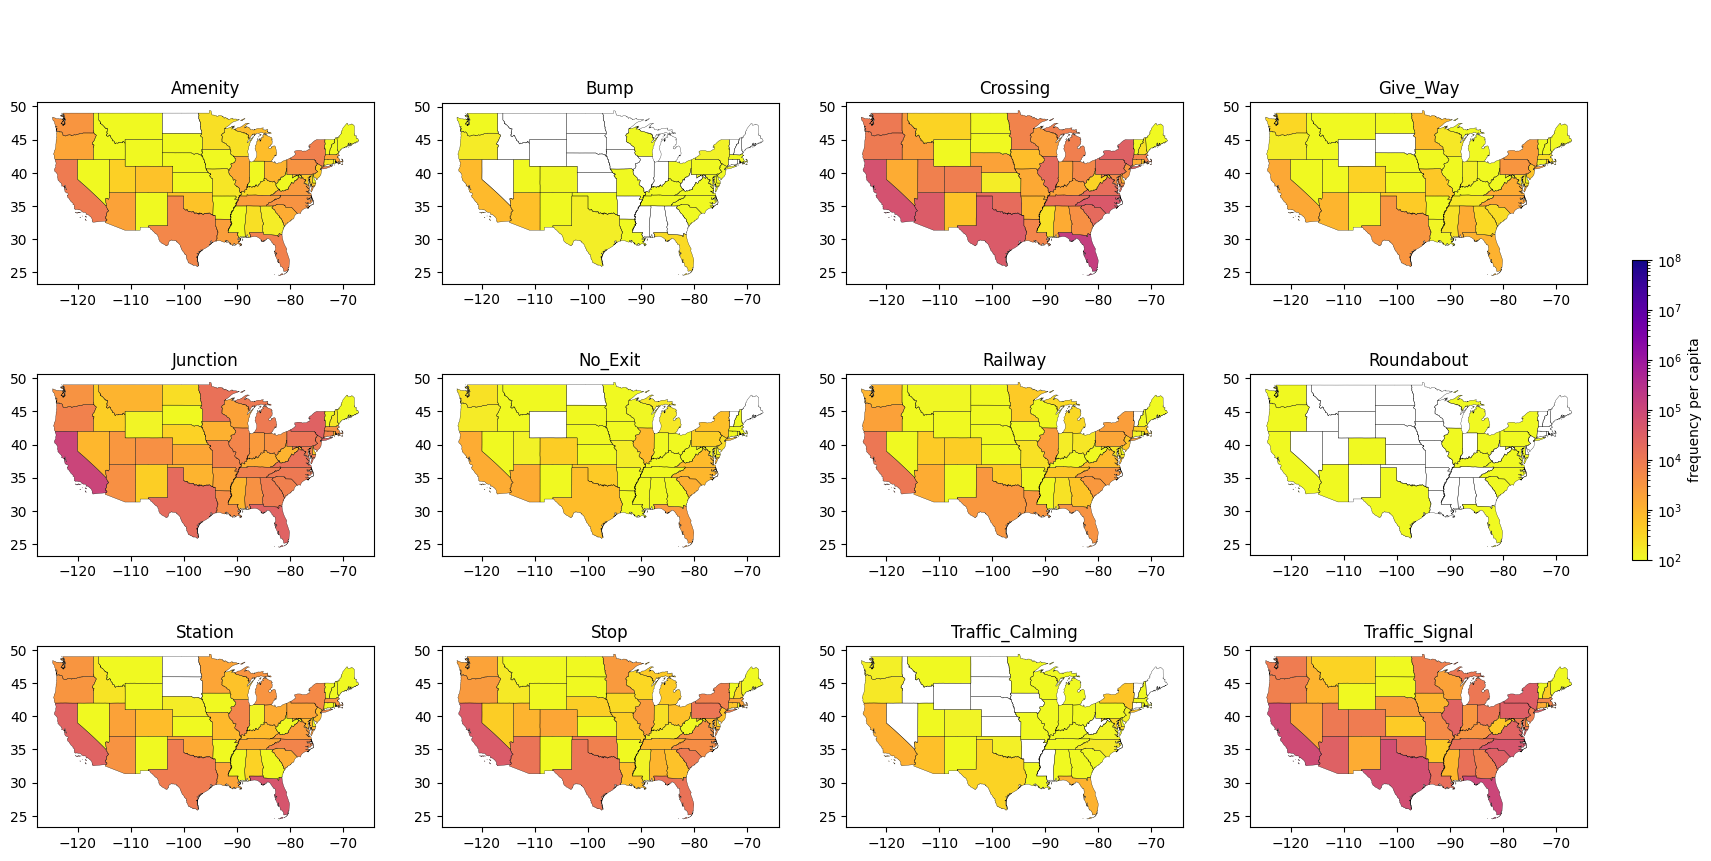

In [ ]:
infrastructure = ["Amenity", 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

fig , axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.ravel()
norm = Normalize(vmin=0, vmax=100000)
norm = LogNorm(vmin=100, vmax=100000000)

maxes = []
mins = []

for i, feature in enumerate(infrastructure):
    mask = accident_data[feature] == True
    filtered = accident_data[mask]
    counts_by_state = filtered.groupby("STATEFP")[feature].count().reset_index().rename(columns={feature: "counts"})
    maxes.append(counts_by_state.max())



# Colormap
for i, feature in enumerate(infrastructure):
    
    mask = accident_data[feature] == True
    filtered = accident_data[mask]

    counts_by_state = filtered.groupby("STATEFP")[feature].count().reset_index().rename(columns={feature: "counts"})
    counts_by_state = counts_by_state.merge(population, how="left", on="STATEFP")

    counts_by_state["percapita"] = counts_by_state["counts"] / 1
    geographic_data = gpd.GeoDataFrame(counts_by_state.merge(state_data, on='STATEFP'), geometry='geometry')

    state_data.to_crs("5071")
    state_data.boundary.plot(linewidth=0.2, color='black', ax=axes[i])
    im = geographic_data.plot(column='percapita', legend=False, cmap='plasma_r', ax=axes[i], norm=norm)
    axes[i].set_title(feature)

fig.subplots_adjust(right=0.9)
sm = ScalarMappable(norm=norm, cmap="plasma_r")
sm.set_array([])
cbar_ax = fig.add_axes([0.88, 0.15, 0.05, 0.8])
cbar_ax.set_axis_off()
fig.colorbar(sm,
            ax=cbar_ax, orientation="vertical", pad=0.01, label="frequency per capita")


### Weather Conditions Plotting

   STATEFP      means
0       01  66.491718
1       04  71.386133
2       05  58.544744
3       06  62.989021
4       08  44.801913
5       09  52.651171
6       10  57.826267
7       11  58.257737
8       12  75.441140
9       13  63.101301
10      16  45.706885
11      17  47.698265
12      18  49.290601
13      19  37.306627
14      20  48.825273
15      21  57.421241
16      22  69.330180
17      23  45.005322
18      24  55.542748
19      25  50.632582
20      26  43.056477
21      27  30.308271
22      28  65.553693
23      29  51.360636
24      30  26.175739
25      31  48.555166
26      32  50.971567
27      33  43.117171
28      34  55.989140
29      35  54.994151
30      36  52.167572
31      37  62.182158
32      38  24.614084
33      39  47.674842
34      40  63.974608
35      41  49.122183
36      42  50.025124
37      44  51.834207
38      45  64.001667
39      46  48.819106
40      47  61.677184
41      48  68.461210
42      49  50.823147
43      50  42.094609
44      51

TypeError: Could not convert NNENNESNNECALMNCALMVARNEVARNNECALMNEVARNCALMNCALMNNNENNENSSEWNWNNWSNWSWNNWNNSNNNWNNWNNNNWNENECALMNNENCALMCALMVARCALMNNENNENVARNCALMVARCALMNNWCALMCALMCALMSSECALMSSWCALMESEESWWNWWNWSSEVARSSWCALMVARSWENENESSWWSWSVARSWCALMWWSWWNWWCALMSSWVARCALMCALMCALMCALMWSWWSWWSWWSWWSWCALMCALMWSWSSESSECALMSSESWCALMCALMCALMCALMWSWSSECALMSEVARWWSWSEWNWWWSWSSWSSWWSWWSWSSWSSWSSSECALMSSSWVARNEEESEEESESSEWNWSSESSESSESECALMCALMSSESESESESSWCALMCALMCALMSWSSESSWCALMSESEVAREESEENEESSESEESEESEESECALMESEVARESEWCALMENESSEESVARSCALMCALMENESESSEWNWENESSEESESEESEENESEVARESESESEESEVARSSEEEENEEVARENEEVARENEECALMEECALMWNWCALMCALMNNEENEENEWNWSWNWNWWNWNNWCALMSENWWNWCALMCALMCALMVARENESWENENNECALMCALMENEENECALMNEECALMNNCALMCALMNWCALMCALMWNWNNENNECALMCALMNNNNWNNWVARWNWNNWNNNWNNWNVARNNWWNWNNWNNWCALMNEVARNNWNNWNNENNWNEENEVARENENNEVARNENNNEENENEVARVARNENNNNNNNENCALMCALMNNENVARNCALMNCALMWCALMWNWWSWWCALMNWSSWNENNWNWNNCALMNNEECALMWCALMNNECALMVARVARSSWNNWNWNWNNNNWCALMCALMCALMSESEECALMNNWNNWENNWCALMWNWCALMENECALMNCALMCALMCALMSSWSSESSEVARCALMSENENEVARSSSSWESSENEENESSWNEENESECALMNNEENEESESEVARENENCALMCALMCALMCALMCALMSSESSESEESESECALMEESENSVARCALMNVARSENCALMVARCALMCALMCALMCALMCALMNNWNCALMSSWCALMNCALMCALMCALMCALMCALMNCALMCALMCALMNCALMWCALMNCALMNNWWNWNWNWWSWVARVARCALMNNWCALMCALMCALMNNEESEENECALMENECALMCALMCALMCALMSSECALMSESSESSECALMSSWCALMCALMSSEVARSCALMSECALMSSWCALMNSSECALMCALMCALMESEENECALMSSESSSWVARESEEECALMCALMSECALMENECALMCALMENECALMEEESEESEESESSESESENECALMESECALMCALMESECALMNNWSWNWSSWSSESSWCALMSCALMSESEENESSWCALMCALMWSWSSWENECALMESECALMSNNECALMWSWSSWSESSENESSWCALMCALMCALMSSESSECALMCALMCALMCALMCALMCALMWSWCALMWCALMCALMWWWNNWSWCALMWSWVARCALMNNNWECALMCALMCALMCALMWSWCALMWSWSEWSWCALMCALMWSWCALMCALMCALMNNECALMCALMWNWCALMCALMCALMCALMSWVARCALMCALMSSWCALMCALMSWCALMWSWWSWSWSWSSWSWSSWWSWWNWWSWWSWSWWSWCALMSWCALMWNWWSWCALMWCALMWNWWNWWNWSWSSNNESWWCALMCALMSWNSWWSWSSWCALMSWWNWWSWSWCALMSWCALMSSWWSWNWNWNNWSSWNSSSSWSCALMCALMSNNWSWVARVARSSESSSECALMSSWSSSESSESSWSWWSSWESSSESSSSWSWSSWSWSESWWSWSSWWSWWCALMSWVARWWVARSSWSSSSEVARCALMSSECALMCALMCALMCALMSEECALMCALMCALMCALMCALMCALMSWCALMCALMCALMCALMCALMCALMNEVARSWWSWSWCALMNNENNENNECALMNNESSWNNENNENNENNWNWNENEWNWSNNESWWENESWNNWWSWVARVARWSWCALMESEESECALMNCALMNWSWCALMWSWSWSCALMNNENCALMCALMENECALMNCALMNNWWNWWNWNNNWNNWCALMCALMNNWCALMVARNWCALMNNENWNCALMCALMWNNWCALMNNENCALMVARCALMNENNECALMCALMCALMNCALMCALMCALMCALMNNNNNNEENENNENNNNNNNNNNWNWNNNNENNWWNWWNWNNESWWNWCALMNNNENNSNCALMNSWCALMNCALMCALMCALMCALMCALMCALMCALMWSWSSWWSWWSWCALMWSWSSWCALMCALMWSWWNWWNWSSWCALMSSECALMVAREECALMCALMCALMWNWCALMCALMNNENNENNESSWSWSWENECALMSWNENNESWNNVARVARNSWVARNWVARNNWSWSSWNVARCALMNESSWSSWCALMNESSWNNWCALMSWWNNENCALMNESSSWCALMCALMCALMCALMSCALMVARSWSWCALMCALMSSWNNENNWSSNNWENESNSSENEEENESSECALMSWCALMCALMCALMCALMVARENESSWCALMSSWSSSSSWCALMSSEESENECALMSSENCALMCALMESENNWSWSWSESSWSVARNNSWSVARWSWNESSESSEVARSWSSWNWSSWCALMSESSWCALMECALMCALMCALMSWSSESEESESWSCALMSSECALMSSEECALMSESCALMSCALMSSESSEESENENNWCALMSESNENECALMWCALMVARSCALMSSWNNWESESWSESSSEWSWNEVARSSECALMSSWCALMVARSSWSVARNNESSWESECALMSSESSSWSWWNWSSENSESSSSWESESNWSSENNESEVAREVARCALMVARSEENEVAREVARCALMCALMCALMCALMSEENECALMSWCALMCALMCALMVARVARVARCALMCALMSWCALMSECALMSSWSWSESSESSWSSSESESENESSECALMVARVARENNECALMNNECALMCALMENECALMCALMCALMCALMSSWSSWSSSSESWCALMSSWSSCALMSESSSWVARSSWSSWSSWSSESSESSWSESSWCALMSSWSSWCALMCALMCALMCALMSCALMCALMESSESCALMSSESVARESEWSWSSWCALMNWESESSESSWNNESWNWESESSSESESESSWCALMSSWSEESWSWSSESSESSEESSESSESECALMSNENECALMSSESSECALMESEWCALMCALMESESCALMSSESSESWSESSWSESWSWSECALMSWSWVARWSWSSENNWCALMVARWSWNWSSWWSWSCALMSSSSSWSCALMNSSWESESSWSSESSSSWSECALMVARESENEEVARSSESSWWWSWNNWESENWSWWVARCALMNWVARNNWWVARCALMWNWWNWSSWWSWSSWSSWWNWSSWSSWSWSESSESCALMWNWWWCALMCALMSECALMSVARCALMCALMNESSSENNNWECALMCALMCALMSSWSSWSWWWWNWCALMWCALMCALMCALMSCALMCALMCALMVARSSWSSWSSWVARSWWSSEWNWSWWCALMSSWSESSENWSCALMCALMWSWSWNNENNENNESSWCALMNESSWWWSWNWSCALMSSWWWSWCALMSSWSNWNWWSEWSWNNEWWNWWWSWNNESCALMCALMSSESWNNWCALMNNENWWNWWSWWSWSWSSWCALMSSWSSWSSWSWCALMSWSSWSWSSWSSWSSWVARSSWWSWSSWSSWSSWWSWSSWSWSSSWWSWSWSWWSWSSWWSWWSWSWSWSSWSSWSSWSWWSWSWVARSWSWWSWSWSWWWSWCALMWSWWSWSSSWSSSSSWSSSWSSWSSESSSWSSWSWSSWSSSWSSWSWWSSWSWSWVARWSWCALMSWSSWSSWSWCALMWSWVARENENNWWSWSWCALMCALMWSWWSCALMCALMCALMSSESSSCALMSSESSWCALMSWSSWSWSWSWSSSWSSWSSWWSWSSSWSSSWSWSSWSWSSWVARSVARSEVARSWVARSSWSWSSWSSWSSWCALMCALMSSENWSWSSWSWWSWSSWVARSSWSSWSSWWSWSESSWSSWESESSWVARWNWSWCALMNSSESWSWESENSSSESSSESWSSVARCALMVARSSWWVARESESWCALMSWWSWSSWWSWVARSSCALMSSESCALMWSWSSWSSWSSWVARWSWSSWSSWSWVARVARWNWSWWNWESWSSSESEESEENEWNWSEVARCALMWWSWCALMCALMWNWCALMSSWVARSSWSSWSSENWSSWSWWSSWCALMWNWSCALMSWSWSSWCALMSWWSWSWSWWSWSSWNWWSWNWNWSSWWNWCALMWSWSWSSWSSWCALMSWCALMCALMNNECALMWSWNNEENEWSWESSWWSWSSWSWNNWESEWSWWSWSWNWWSWWWSWWSWWSWSWWWWSWSNWSWSWSWWSWSWWSWSSWWCALMSWSWSSWVARSSWVARWSWSWSWWSWSWSSWWSWSSWSWSWSWSWSSWSSWSSSWSSWSSWVARSWSSESSEWCALMCALMSSESSWWNWCALMCALMWSWWSWWSWWSWSWCALMSWSWSWWSWCALMWSWSSWSWSWSWSWSSSWSSSWWSWWSWSSSWSWSWSWWWSWSSWWNWWWSWWSWWSWWSWWWWSSWSWWWNWCALMSSWSSWSSESWSSWWESCALMSSESSWSESESSSSSEWVARCALMWSWNNWSEWCALMSWNWWSSEWSWSNWSSWSWWWSWSSWWWNWWSWSWSSWSSWCALMSSWSSWSSSSEESEVARESECALMVARVARSSESCALMSSESSEEWSSWESEESESSWSWCALMCALMSSECALMCALMWSWEWSWCALMVARCALMCALMVARSNWCALMCALMVARESENNEENENWSSESSESCALMSSESSENWESEESEVARCALMESECALMCALMENECALMCALMSSWWNWESECALMSVARVARCALMNENSSESSENNENEENENVARESEENEENECALMCALMNNECALMNNWSSWNNWVARCALMNNESSWNESSWSWESEVARESSWWNEVARWNWVARECALMENEEEWSWECALMVAREEEENEENEEECALMEECALMCALMCALMESECALMSESSWCALMSSWWSWWSWNNWCALMSSEWSWSNWSWWSWNSWSSWSWWNWNNEWSWSSWWSWWNWVAREVARWSWWNWWWSWWSWCALMNWNWNENNEESEWCALMSSESCALMCALMSSWSESWWSWSSWSSENSESSWENESSESSECALMENENENSSWSSSESWWSSEEVARVARSSEECALMESEESSECALMSECALMCALMSSESSECALMNSSENCALMSSEESESENEESEWSWENENENESEESESNWEENEENEEWSWEENENWNNEEESSEVARWSWENEENEENEENECALMCALMCALMCALMCALMCALMNECALMVARVARCALMNCALMNEENENSWCALMNNENNEVARNWNWWVARVARNVARNESSWSSWWNNESNNEWSWSSEWNWVARESECALMESECALMSSEWNNENNESWSWWSWNWVARSWCALMCALMSSWCALMCALMSSWNWVARCALMNNWCALMSWSSWSWNNECALMNNWNNWESESSWWSWWSWWSWSSWWSWSSESSWVARVARWNWWSWWSWWCALMSSESWSWCALMSSECALMSSWSESWSWSWNNWWNWSSWWSWSSWCALMVARWSWSWNNWSSWEWWSSWVARSWSWWSWVARWSWWSWCALMWNWSSWSWSNWCALMSESSSWCALMWSWSCALMSCALMCALMWCALMSECALMCALMVARCALMCALMCALMCALMWWSSEWWSWWSWWNWWNWCALMCALMCALMSWCALMSCALMSSWSSWWSWSESSEWSSSEWNWSESSWSSWSSECALMVARSSWNESCALMVAREVARSSESSEVARVARWWSWSSWSSWWENECALMSSWESECALMSECALMWSWCALMWVARWSWWSWWSWWSWWSWCALMWSWWNWSWSWSSWWSWCALMSSESSESSSSSWSSWCALMNWSWSESESWSCALMWSWSSWNNECALMSNSWSCALMCALMSSWVARWSWVARSWSWVARVARSSNWVARVARWSWWSWVARCALMVARWWSWSWSNWSWSWSSWVARWVARNENNECALMCALMWSWSWCALMCALMCALMCALMCALMCALMENESCALMESWSSWSSEWSWSWCALMSSESESEESESSEVARSESSESSESSWEESEVARSSEVAREENEESEENEENEENNEENESSEVAREENESSEVARNECALMENEENESSWSSSESSESESEENEVARNESSESEWSWWNWCALMCALMWSWCALMWNWNNEVARCALMCALMCALMCALMSESENEESECALMEEEEEESEENENNECALMNNENNEEENECALMSSWESSENNNNENNENVARVARNNENENNENENENNECALMVARNWNNENENENENCALMVARNNEENENENENENCALMSSESECALMESESESNNNENNENNENEESENNENNWNNNENNENNENNENWVARNNEENENEWNCALMNNECALMNNNECALMCALMNNNVARSSEESECALMCALMSSESEEEESENEESEVARESEESENNENESENSSEEECALMNNECALMCALMNNWCALMNWNWCALMVARWNNWNNWNENEVARNNWNCALMNNSCALMCALMNNEVAREVARCALMNCALMNNENCALMCALMWNWNNECALMNECALMNENENNNNWNNNWNNWNNWNNWNNWNWWNNNWCALMCALMNWNNECALMCALMCALMCALMNNENNWCALMWWECALMNNWNWNWCALMNWNWNWNNWWNWNWWNWENEWNWNWWNNWWNWWNNNENSEVARNNWNWWNNWNNNWNNNENNENNWCALMNWCALMNNWCALMCALMCALMCALMCALMCALMCALMWNWNECALMNCALMNENNWNNWENEWSWNNENNWNNNWVARSSENWENENNENNWNNNWNWENECALMCALMCALMNECALMECALMESEEENEENECALMNESNNEEEESEEEEENECALMVARNEENECALMVARSESWVARSSESEESSENEENECALMVARENEENENNNENNENNECALMNNNNEWNWCALMVARNWNCALMCALMSWNWNWSCALMNNWNWNNWNWWSWNNWNESEVARNNENEVARSENWVARVARNENWWWNWWNWWNEVARCALMCALMCALMCALMSCALMENECALMNECALMCALMCALMCALMSSESCALMSNNENNEVARSNESCALMCALMSSWSSWSWEVARSSESWNNSSWSECALMCALMSWCALMSSENECALMCALMEECALMNESEENEVARNNESCALMSNWWCALMNNENNEENEEEWNWNSSENEWSWESENNEWSWESENENNECALMNNENNENNEWNWVARNENVARNNENCALMVARCALMWNWVARCALMCALMCALMWNWCALMCALMCALMCALMWSWCALMWNWCALMWNWNSSSEWSWWNWSWSWVARSSEWNWWSWENENWWNWWWNWNWCALMWSWCALMNWSWCALMVARWWWNWWSWWNWCALMWCALMCALMWSWWSWSWCALMSSECALMSSWCALMCALMCALMSCALMSSWWSWSWSSWWSWSWWSWSSWCALMSWVARSSWNWSSWSWSWSWSSWVARWSWVARWWSWWSWCALMSSWSWCALMSSEWSWSCALMSSWCALMSSWSVARWVARWCALMECALMCALMCALMSEESEWWSWCALMWSWCALMNCALMESEESENNEESECALMCALMENEWNWWNWSECALMNWWCALMCALMNWWSSWNWVARCALMVARSSNWWWWWNWSSEWSSWNNESECALMENESECALMCALMCALMCALMWNNNENNWWNWNNVARWNNENNSWNNWWNNWNNWVARNWVARNNNWNWNWNNWVARNNWWSWWNWNWNWVARCALMNNWNNWSWNWNSSWNEVARNNWCALMWNWWNWSSWWSWSNNWNWWSWSSWSSWCALMSWWENEWSWSSWWSWSWSWWSWWSWVARSWWSWWSWSWSSWWSWWSWWSWSWSSWWSWSSWSSWWSWSWWWSWVARWSWSSWSWSSWSVAREENEVARSSSVARSSWWSWNCALMNENNESESESENEESEESESSWSSECALMSWVARSWSCALMSWSSWSWWWSWWSWNNWWSWNWWNWESEWSWSSWWWSSWWSWSWSWCALMSSEWWNWWSWWNWSWSWSWESECALMSWSSSSWSWSWESESSWSWSSEESSSWECALMSSESSESSESSESSESWSESEESWSSWWWSWNWSSWNWCALMSWSNWWESSESSWESWSWSSWSSWSSWCALMWSWSSWVARSSWCALMVARESESESESSESECALMCALMSSESSWCALMENEENEENEENEENESSWWSWEWWWSSWCALMSNNECALMENSNWCALMSWESENNWWSWVARWNWSWWNWWNWVARWNWCALMCALMWNWWNWVARVARWNWCALMCALMCALMCALMCALMCALMWNWCALMCALMCALMCALMCALMCALMSENWCALMCALMCALMCALMCALMCALMCALMCALMSSECALMCALMNWSSEWVARNWWSWVARESEESECALMENEVARWNWSENENWWNWVARCALMNEVARVARCALMECALMCALMNEENECALMNNENNWENECALMCALMCALMCALMCALMCALMCALMCALMESENNWCALMESENCALMCALMCALMCALMNCALMCALMSCALMSECALMNNNESSESSECALMSESECALMNNESSECALMWNWSEVARWNWVARSSEVARENEWSSWNWSWCALMECALMSSESECALMCALMNNEVARCALMCALMSECALMCALMSSESESSESSESSECALMCALMSSCALMSCALMESESSSWESESSWVARCALMSSESSWSWSWESEVARSSWSSVARCALMSECALMESEESESSSESSESSESSESEESESEWSWENENENWWWNWVARCALMNNWWESENNWNWVARVARCALMSSWWNWNWNWNWNWNNWNWWNWWNWWSWWNWWNWWNWWNWWNWWNWWNWWNWWSWNWNWWNWWNWWNWWWNWSWWWNWWWSWWSWSWWSWWNWSWWSWWWVARVARSWSWSWWVARWSWSCALMSSWSSWSSWSSSWSSSSSSWSSSSSESSSESSESSWSWSSSWSSSWSSSESSWSSSSWSVARSSESNESSSESSSESWSWWSSESWSESSSSCALMSSSSSSESSESSEVARSSESNWSSEESEESESESSESSESSSESSSESSESSESSESSESSEENESSEVARSEESESSECALMVARSESSWSSESESESSESESESESSEEESESSESSWSSSESSESSSESCALMSSESSSSESWESESSEESEESESSESSSESEESEESESSSESSESESEESEESEENESSESEESEESECALMSSECALMESEESEESEESEVARSEESECALMCALMENEESEWCALMSENESWWSWWESEESESSESESESESSSESESESSEWSWVARSSESSESESESEESESSSENESEESEESECALMESSEEEENEENEENEENEENESSWCALMSESCALMNNENECALMNNNWNWNWNWNWNENNCALMNEWNWNNNNNNSENWNNWCALMSWSWNNWSSWNNWWSWNSWENENNECALMSSWNNWCALMEVARWNWNNEENENESWSWWWNWENEWNEENEWSWSWSWNENENENNNENNEEWNWENEESENENEENENECALMWSWENECALMNSSEESEESEENESSENEVARNNESSEESSSESSSWSSWSSWSSESSESSESSESSSSSSWSSSWSSSWSSWSWSSWCALMSSECALMSSWSSSWSWSSSWSWSSWSSSWSWSSCALMSSSWSSWSWSSWSVARSSSWSSSWVARSSWSSSSSWSSWSSSSSSSWSSWSSWSSWSSWSSWSWSSWSWSWSWSSSWSSWSSWSWSWSSWSWSSWSSWSWSWSWSSWWSWSSWSWSWSWWSWWWWSWWSWWWSWSWWWCALMWSWSSWWWSWSSWCALMWSWSSSWWSWWSWWWSWSWCALMSSWSCALMCALMSWSSWCALMSSWSWSSWSWSSWSWSSSWSSWSSCALMSWSWVARSSWSSWWSWVARSSWWSSWWSWSSWSWWSWSSWSSECALMWSWSWSESECALMCALMCALMENENECALMCALMSENNWVARNWSSWWNWNNNNWNNWWNWCALMNWWCALMNNNNWVARCALMCALMNNNENNENWNWVARNWNCALMNECALMSENECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNENNECALMCALMCALMCALMVARNCALMWNWNNWWNNNWNNENWNNWNNNNWWNWNWNWSWNWNWWSWWNWNNNWNWWWNNWNNWWNWNNNWNNWWSWSWCALMWSWNWSWCALMWCALMNNWSSSSEWWNWSECALMNWNESSESSECALMCALMCALMESEWSWWWCALMSWCALMSWVARSVARCALMCALMNWENECALMCALMESECALMSCALMNEESSECALMSSWNNEESSEEWNEESEESSCALMEENEVARVARENEVARNENENESESSEVARENEEESEESESSEESSESESSEESEESSWESESSWVARVAREESEVARENESNNWENESSEEECALMCALMNENNWENECALMVARCALMECALMCALMENNECALMCALMNENECALMNECALMNESVARNEENENNEVARENEENENCALMNENENNECALMENENEVARSEEVAREENEENEESEVARESEENNECALMVARCALMSSENNENNENNECALMNNENNNENNNESNNENESSENNNWCALMNNCALMENENNWWNECALMCALMNVARNECALMCALMNNWCALMCALMCALMCALMCALMCALMCALMNECALMCALMCALMSWSSWSSSWSSESSSWSSWSSWSSWSSSWSSECALMSSWSESSSWSSWESEVARVARSEVARSWCALMSECALMSENESESECALMSECALMSSENWSENESWCALMCALMCALMCALMNNWWSWCALMCALMCALMNCALMNNECALMSSWSSEWNSNCALMCALMWWSWWCALMNNWWCALMWCALMSSWCALMCALMWSWSWSSWSWSWSWCALMSSWSSWSSWSSWWSWSWSSWSSWSWSSSSWSWSSWSWSWSSSWSWSSWSSWSSWSEESSWSWSWSSWVARSWSSWSSWSSWCALMSECALMSESESESSWCALMSSESSESSWSESSESSWSWSSESESESSSSESSESSESSESWCALMSSSESCALMSWSSWSSSESSWWSEVARWSWVARSWESESSECALMSSWSSSECALMCALMCALMCALMSSENNEVARCALMCALMCALMCALMWSSWSSWVARWSWWSWWSEVARCALMCALMSSECALMCALMSCALMCALMCALMSESECALMSSECALMSSEESEESESEVARSESSESESSESESSSESESSSESSEESESSESSSWSSSSWSSEVARSSSESSSESSEESESSESSESSESWSSESSSSWSSESSESSWNNEVARCALMCALMCALMCALMSESESESSESESSESSEEESSESSSWSSWSSWVARVARESESESECALMSESSWESESSWESESWVARVARENEENNEVARSSESEESEVARESENNENNENNECALMCALMCALMVARNECALMEVARENEENECALMNNENNENNENNENNECALMNNECALMNNECALMCALMNNWWNWNNCALMENENNNEENENNNNNENCALMCALMNNNENNNWNVARNNNVARCALMCALMNEVARNNENENNNEWNWNNNEVARNNWNNWENENNENNEVARNENENNENEVARCALMVARNNWCALMNNNNENNENNNNENNNNNNNWNNNNWNNENNNWNNWNNNNNNWNNWNWNWVARNNWNNEENENNENNCALMWNWWNNNWNNWNNWNNNNNNENNNNSSEESESWSWSWSSSSWSNWNWSNSSESWSSSWNWWSWWSWSWNSSWSWSESSWSWWSWWSWSWSWSSWWSSSSWSSSWCALMSSWCALMCALMSSWSSWESSECALMSSWSSESSECALMSWSSESSESSSESCALMCALMCALMSSECALMESESEEESESCALMCALMESECALMSEESEESECALMSSESSECALMESEESESEESESSESSESEEESEESESSECALMSESSEVARSSEESEESESESESEEEVARSVARSSSEESEESEESESESSNNESSEESECALMSSESEESECALMENECALMCALMCALMCALMNESSEVARESSECALMCALMECALMSSESSESESESSECALMSSWSCALMSSESSESSENEESEESSVARSSWESESEESEESEEESESSWSSWENESENEESEESEESEENESESWSWSESSESESSEESESSESSESSSESSESSESSESSESESSESESSEESESSECALMSESESESSESESSESESSEVARSESSSESESESSEESESSESSESSEESESSEESEESESSEVAREEESEESEESEESEESEESESSEEESVAREEVARENECALMCALMNWNNENWCALMCALMNWNENEENEWSWNNWNENNWCALMCALMCALMNNEWSWNNNNENNECALMENECALMWSWNNWNCALMNNENNENNWNNWVARNNNNNENNWVARNNWWNNWNNWNWNNEVARNNWNNNNENNNNNECALMNNNENNENNNENENCALMNNEVARNNNENNESNNNENNWNNWNNWNCALMCALMNWNNWVARNNWNNWNNNNWNNWNWNWNWNWNWNNNWNWNNNWNNWNNWNWNWNNWNWWNWWNWNWNWNNWNNWNNWNNWNNWNWWSWWCALMNNWNNWNNWWSWWNNWWSWNNWNWNNWNWWSWWSWWSWNNWSSWWNWWSWNWWSWNWWSWWSWNNWWNWNWSSESESEESENENESNVARNNENESESSWCALMWNWWSWNWNNWCALMESECALMNNWNNWCALMCALMVARCALMSCALMCALMENENECALMSSSECALMCALMESEESEESESSWSSEESESSESSESSESSWSESSSWSSSESEEEESESSSESSSESSESESESEEESESSEESESSSESSESSESVARENEESESSESSESSESSESSEEESEESENEVARSSEENEEECALMESEVARVARENEVARCALMVARNEWWCALMNNWCALMWNWWNWNNWWSWCALMCALMCALMNCALMNNWWNWCALMWSWNNENNNNENWWNWWNWCALMNWNWWNNENNNNWNENNNENNWWNWCALMNVARCALMNNNENNWNCALMNWNWNWNWCALMWWNNWNWVARNNWNWNNWWNWNWNNWNNNWWNWCALMNWNNWNWSWESNESWWESSSSESSESSSSWSSSSSSSWSSSSSSESSSSSSESSSSSSSWSSSSSSSSSWSSSSESSSSESESESSWNNWSSSSSESSCALMSSESSSWCALMSSESSESSCALMSSESSSSSESSSSWSSSSSESESESSSWSSWSESSWSECALMSSESSESSWSSWSSWSSESSSSESSSESSSESESSWSSSESESWSSSEESSWSSSESSESSESSWSSWSSWSSSWCALMSESWSSSWCALMSESESSESWSWSWSESESSSSSSESSSESSESSSWSSSSESSSSESSESSSWSSSESSESSSEESESESSSESESECALMSSWSCALMCALMCALMCALMWSWCALMWSWSSWSSWSSWSSSSECALMSSSEVARCALMSSWSSSSWSSSSWSSSSSWSSWSSESSWSSWWSWCALMSWWCALMCALMWWWWSWWWNWWWNWSSWSWCALMWSWWSWWSWWNWWNWNWWSWSSWSWSSWSWNWNWWNWSSWWWWNWWNWSSWWNWWWWNWWNWWNWWWWWNWWSWWWNWWNWWWNWWWSWWNWWWSWWSWWSWWSWWWSWWNWWNWWWNWWNWWWNWWNWWNWWNWWNWWWNWWWNWWSWWNWWNWWNWWWNWWNWWNWWWNWWNWWWNWWNWWNWWWNWWNWWNWWSWWNWWNWNWWNWWNWWWWWNWWNWWNWNWNWWNWWWNWWNWSSWWWCALMWWSWNWWSSWSNNNWCALMNNWNNWSSESSSWSSNSSENNWCALMNNWNNWSESEWSWNWNNWNWNNWNNENNNWCALMCALMNSSWSSWCALMNSWSESESSWWESWSWVARSSWSSWSSSWSSESWSSSSWSSWSCALMCALMCALMSSSESSESSEEESEEEENESSEESESESESECALMWSWSSWCALMSSWSVARSSSSESESSEESSWNESESESESWWSWSSWNSSWSWSSEECALMWSWWSWSSWSWSWSWSSESSWWNWWNWSSWSSWVARSSESSESWSSESECALMVARSWSWWNWSSSENWVARESSESSWNWWSWSWENEESESSWSENSEENESEENEENNWSSEESEVARVARESEEENEESECALMCALMSSESSWCALMSCALMSSESCALMCALMCALMCALMVARSWVARSWSSWSSEWSWCALMSSWCALMCALMSSECALMSSWCALMCALMWSWWSWSWSSWVARESEVARSSWSECALMSSWSSWCALMSSESSECALMESEESESESESESENECALMVARSECALMSECALMENNEENECALMCALMCALMNEVARCALMNNNNNWNNNENNENWVARCALMWNWWNWWNWCALMCALMCALMCALMWSWWSWENECALMNWNVARSSWVARWNWWNNEWNNENWNNWCALMNEWNWVARWNWSSWCALMSWSWSWWNNNWWSWCALMNWCALMCALMCALMNWNWCALMWNWCALMCALMNWNNWNWNWSWNCALMNNNNNWCALMNNWNNWSWNNWNWNWWNWWNNWCALMWSWWWNWSSESSEWSWWSWWWNWWWSWWNWSWWWSWWSWWSWSWWSWVARWSWNWWNWVARCALMWCALMSSWCALMNNWWSWSCALMCALMSECALMCALMSESCALMSSECALMESECALMCALMCALMNSNWNNWNWWNWWNWWSWNWWWSSESWWSWWSWWWWSWWWSWWSWWNWSSSEWSWWSWSSESWSWSSWWSWSWWSWSSWSWSSWSWSWWSWSWWSWSWCALMWSSWSSEWWNWSWSSWCALMCALMWSWSSEESENCALMENESESSESSESWSSESSESSEWSWSSSESSESSESESSSESSESESESSESSESSESSESESSESSESEECALMSENESENEESESESESEESSESSESSEESESEESESSESESSEVARSSESESSESSESSESSEVARESESSEESSSEVARSSESVARVARSESSESSESESSSESSSESESESSESEEESEEESENENECALMESECALMVARVARNEEEECALMESENNENNNENNENENNENNWVARWWNWWWNWWNWNNEWWNWNWSWWSWWNWWNWWWWNWWWWSWWWNWWNWWNWWWSWWWSWWWSWNWSWWSSESESSWSSESEESSESSESSWSSESSESESESSESSWESESSESSSESWSESSSSESVARSSWSESESSWSSESSSESESESESSEVARSSESESSESSESSEECALMSEESESWNWWNWNNWESESSEENESSESSEESESESSWENEENESEECALMSSNNWVARSSEEESENESECALMSSWSSECALMSSWSESSWESESSSSSSCALMSESSSSESSSESSESSESSSESSWWSWSSSESSWSSWSSWWSWSSESEVARSESSWVARSSESSWVARCALMVARCALMSWCALMCALMCALMCALMCALMSESEESECALMCALMSECALMCALMCALMCALMCALMCALMCALMENECALMNWCALMCALMCALMCALMCALMCALMCALMNNEESECALMCALMCALMCALMCALMNWWNWSWESEENEENEENECALMCALMCALMCALMNECALMCALMSSESSECALMCALMCALMNESECALMCALMCALMSWSWEECALMNCALMSWCALMCALMWSWSWCALMNWCALMNNWSESEWSSWVARESEESENWSSWSWCALMSCALMSWESESSWSESECALMENECALMNECALMCALMSEVARNECALMCALMCALMSECALMECALMECALMECALMSSWCALMENESSWNENEESEESENENEESEEESEESEENEEESEESEEEESEESEESEESEEESEESEEEEESEENEEESESSEESEEENEENECALMNEESEENEEESEENENEVARVAREESEEEEEEESEVARCALMSEVARVARNEESENNESSENENENNEEENEESEENEESEESEEENEESESESEENENNEENEECALMCALMSESESSECALMSESEESESSESESESESSESSESSESSESESSESSCALMVARSESSESESSESESSSEENEESESSSWENESESESWESWSSESNEEVARCALMNENENSESSECALMWNCALMCALMCALMCALMNWCALMCALMNWNWNSWNNWNNWNWNNWNNWNWNNNWNNWNNWNNWNWNNWNWENENWNWNSSENNWNNWSSESSESWNEENNEENNWNNESECALMESSENNWEEVARCALMWNWWNWWNWCALMSNESSWENECALMNENECALMNECALMSWNECALMNESENNEVARNNWENECALMNNECALMNECALMVARSEECALMSSSEESEENEENEENESEEENEENENCALMCALMNNECALMNNECALMNNECALMCALMCALMNECALMNNWCALMSESENWWCALMCALMNWCALMVARCALMWNESSECALMVARNWNSENESEVARVARSSECALMNNENENENEWESENNENNECALMECALMVARCALMVARNNWNNWCALMCALMCALMCALMCALMVARNVARNNWNNNENCALMNCALMVARNENNENNWCALMNNCALMCALMNNENNENNEENENNENWNNNNENENCALMNNENNCALMNNNNWNNWNWNWNNENNWNNENNWENENNENNENNWNNNWCALMNNWNNNWNNWCALMNWNWNWNWNNNNWNNENNWNNNWNWNNNWNNWNNWNNWNNWNNWNWWNWNWNNEENESSENENNWNENNENNENNWCALMCALMNNNNENNNNWNENNENENNNNNNWNENCALMEENECALMNNENENNWNENEVARNEENENEENENVARVARNNENNEVARNNWVARCALMNNENENENNNEENNENNENNNENNENNENEENENVARNNWCALMNNWNNWNENWNNWNWWNWWSWCALMNNWWNWNWNNWSSWWCALMNWNNWSSWWNWNWNWCALMCALMSSWSWNWSSWWNWWNNWSSWWNWWNWNWSSWWNWWNWSSWSSSWSSWSSSSSSSSSSESSCALMCALMSSSSSESSECALMSSWSESSWSSSESSESCALMESESSWSCALMSSSSESESECALMCALMCALMSSSSSSESESEESESSSESESSESESSESESSSCALMSSSESSESSESEVARSESESEEESCALMCALMCALMCALMCALMCALMNNECALMCALMCALMCALMCALMCALMECALMCALMCALMCALMNNEWSWSWWCALMCALMNNENNECALMWSWNWWNWSWWSWWSWWNWSWSWSWVARWNWVARCALMWSWCALMWNWENESSWWSWWSWCALMVARSCALMCALMCALMCALMCALMECALMVARCALMCALMCALMCALMCALMCALMCALMWCALMCALMCALMWSWCALMCALMWCALMSESWWNWNWSSWCALMWNWCALMSSWSWVARWSWWWNWNWWWNWSNWNWSVARCALMCALMCALMSEVARCALMVARNWCALMWVARVARVARCALMCALMSSECALMSSWCALMVARSWSSWNNENNWSWNNSWCALMVARCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNSECALMCALMCALMCALMCALMWSWNNWNWCALMSSWCALMWWSWCALMCALMWCALMWVARWWWNWNNWSWVARWNWWWNWNWSWSSWVARWNWVARSENESWCALMVARSSWCALMNCALMCALMCALMCALMCALMNNWCALMCALMCALMNNWENNWNNWNNWCALMNWCALMNNNWNNENENNNCALMNCALMNWNENNNNNNNNNEVARNCALMNNENNENNNNENWNNNWCALMNNNENNWCALMNNNWNNWNNWNWNWNNENNNWNCALMNNENNWNNEWNWCALMNNWNNEENENNNENENWNWNNWVARNNNNWNNENNWNNNNNNENWNNWVARNNEVARNNNWNNNENWNNWNNNWNNWNWNNWNWNWNNWNWNNNWNNNWWNWNNWNWWSWNWNWNNWSSWNSSSECALMSSESSESSSSESSWSSWSESESCALMSSENWSSWWNWNENESCALMNSWNVARWSWNNWNNNWNSSENWNNNNWSSENSSWNNNWNNNNWENENNWSSENNENWNNECALMNCALMNNCALMNNECALMNNENSSENNWNNENNWSSSWSSESSSWSESSSSWSESSSESESSWSWNWSSSSSSSSSSSESESSSESESESSSSSESEESESSEESESESESSESSEVARSSEESESEEEESESSEESEESEENEESEECALMESENNWNNWSESESESENEEENEESEESENNENNESEESESCALMSSSSESCALMCALMCALMNENENWNWNNENWNNNWNNENNWNWCALMNWNWNWNNNWNWNWNEWNWNNWNNWCALMNNENNNNNWNNWNWNNWNNWNNWNWNWNWWSWWSWSSSSWSSSWSSSSWWNWSSSSSWSSSSSSESESSESESSESSSESSESSSESESSEVARSSSESESSEESEESEESESSESESSESSESEESESESESESSSESSESSESSSESSSSSESSESESSESESEEESEVARSSEESESSSEESSEVARSSESESSESSCALMCALMESECALMSSSESSESSESSECALMSSESESECALMCALMECALMEECALMCALMCALMCALMCALMCALMCALMCALMECALMCALMSSWCALMCALMCALMCALMCALMCALMCALMWSWCALMSSWCALMCALMCALMCALMSSWCALMCALMCALMCALMVARCALMSWCALMSCALMNWWSWSWVARCALMVARWSWWWSWCALMSWSSWSSWSWWSWWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNNWCALMCALMCALMCALMCALMCALMCALMCALMCALMWNWNWSWCALMNNWWNWNNWNWNNWNNWNNWNWNNWNCALMESESCALMCALMCALMSSWCALMSSWSSWNNWCALMSSSSWSSSWCALMSSSSSWSSSSSWSWWSWWSWWSWSSWSCALMCALMSSWWSWSSWSSWSSWSSWWSWESESWSSWSWSWSSWVARSWSWSWWSWWSWSCALMWNWSWSWWNWCALMSSWCALMSSWCALMCALMSSCALMCALMCALMSSWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMWWCALMCALMWCALMCALMWSSWCALMWSWCALMCALMSWWSWWSSWNWWNWNWWNWWWSWCALMSSECALMSSWWSWWVARWSWSSWVARCALMCALMWNWWCALMCALMCALMCALMECALMCALMSCALMCALMCALMCALMCALMCALMCALMSSWCALMSSWCALMWSWWSWWWCALMSWWSWWSWWNWNWWWSWWWNWWNWSWSWWNWWSWWSWWSWWSWWWWSWWSWSSWWSWCALMCALMCALMNNWCALMCALMCALMCALMCALMCALMCALMCALMESECALMCALMCALMCALMCALMCALMCALMCALMNNNWWNWNNEVARVARNNWNNWNWSWCALMVARNVARNNNENNENESNNWNNCALMCALMNCALMCALMCALMCALMVARCALMENNWCALMCALMCALMCALMNNWCALMCALMNWNVARNNWCALMCALMNNWCALMCALMCALMCALMNECALMWNNWNWNWNWWNWCALMNWCALMCALMNWNWWNWWSWVARNWNWNWNNWVARNNWWNWWNWNWWWSWWNWCALMNWNNENNWCALMCALMCALMNECALMCALMCALMCALMCALMCALMCALMNNWCALMCALMCALMCALMCALMNNWCALMCALMNNECALMCALMCALMNEESEVARCALMNENENENCALMNNNVARNNWNNWNNNWNWNWNWNNWNNWNWNNWNNWNNNNNWNWNWNNWWNWWNWNWWNWWNWNWNNWNWNNWWNWWNWWNWNWWWNWWNWWNWWNWNNWWWNWNNWNWWNWNNWNNWNWNNWNNWNNWNNWNWNNWNNWNWSSEWNWWWNWWNWNWSWWNWSSESSWSSWNSWSSWSSWSSSENWSSESSWSSESSESSESSESSESSESSESSSSSEEENEESSESESSSESSEEVARSSESEVARSSNNESSEESESSEESESEVARSSECALMSNCALMENESSEENENNEESENNECALMSEESESESESESCALMSEEESESSEESESESECALMVARSENESESESSESSECALMSSEESECALMESESECALMVARVARSESESESEESESESSESESESSEESESSESESEESEESEESESSESESSEESEESEESESESESEESESEESESEESESESESESSEESEESESESESESESESESESEENESESSEESESESEESEESESEESEESECALMSSEENEESESEEESECALMCALMENENESESSEENEESESECALMSSWCALMEESSWCALMCALMCALMEESSWCALMCALMSESWCALMWSWSSWWSWCALMSVARWNWCALMCALMCALMCALMCALMCALMSSEESEVARCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNNENNECALMCALMCALMCALMSWCALMSSWSSWWSWCALMCALMWSWNNWNWNWNWNWNNWNWNNWNWNWNWNNWNWNWNWNWNWNWWNWWNWWNWNNWNNWNWNNWNWNWWNWWNWNNWWNWNNWNWNNWCALMNWNNWNNWCALMWNWCALMNWVARCALMNNECALMNNENCALMCALMCALMCALMCALMCALMESECALMCALMCALMNCALMNCALMCALMSEESECALMCALMSESEVARSCALMCALMCALMESENNWCALMENENCALMNNCALMNNNENNNNNNWNNNENNNNNENNENNNWNNENNWNNNWNNWNNENNNWNNWNNNWNNNNENNNNENNENNNWNNENNNNENNNNNENCALMNCALMCALMCALMCALMCALMNNNNESNCALMNNENNENNECALMNNENNENNECALMNNCALMNNENNWNNWVARNVARESESSENNNENNWNCALMCALMVARNNENSEESECALMSNNECALMCALMCALMCALMCALMSWSSWSWCALMCALMSSSWSSWSSWCALMSWSSWCALMSSWSSWCALMSWCALMWSWWSWWSWSWSWSWWSWWSWWSWSSSWSCALMCALMCALMCALMCALMESECALMSSWCALMCALMCALMCALMCALMCALMCALMCALMSWWSWWSWWNWCALMNNECALMNNWNCALMNNENNNNNNNNENNNNVARNNNNNENNNNNNENNWNVARNNENNENNNENNNWNNENNNNNNNNNNNWNNENNNNCALMSENNWNNNWNNNWSWNNNWNNWNNNNWNNWNNNNNNNCALMCALMNNWCALMNNWNNNNNNNNNWNNNWNNNNSSWNCALMNNWSSESSECALMCALMENEENECALMSSENNWNNWNSSESECALMSSSSWSSSSESSESSESSESSESSSESSSESCALMSSSSCALMCALMENESSESESSWSSSWSSESCALMCALMECALMCALMCALMNNECALMSEESESECALMESSESSSECALMCALMSSESCALMSSSWSWCALMCALMSCALMCALMSWESSESSEECALMSSECALMCALMCALMCALMCALMECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNWCALMNWCALMWNWNWCALMCALMCALMWNWNNWWNWWNWNWNWNWWNWNWNWNWNWWWNWWNWWWNWWWNWVARWWNWSSWWWNWWNWNWNEEEEEENEEEESEENECALMCALMNECALMCALMVARWVARCALMNNNECALMNCALMENEWCALMCALMNNWVARNNNEWVARNNECALMNNWNNWESEWNWVARNCALMNNWNECALMCALMCALMNWNNWNNWCALMNNWCALMNWCALMCALMCALMWSWCALMCALMWWNWCALMWWNWWSWWNWNNENWNNWNWWWNWCALMWCALMCALMWNWNWWNWWWWNWWWWNWWSWCALMSSWWSWWSWSWSWCALMCALMWVARSSWVARCALMVARSSWCALMCALMCALMCALMSCALMVARCALMCALMSCALMVARCALMSWSSWSWSWSWSWSSWVARCALMCALMECALMSEEWSWWSWSSESSSWCALMNNEECALMCALMCALMCALMCALMCALMCALMCALMCALMENENNWNECALMESEVARVARCALMVARNNENCALMCALMCALMVARNENNECALMNNWNNWNNENNENNWENENNNNWWNWNENNWNCALMNCALMNNCALMCALMCALMCALMCALMNECALMNCALMVARWNWNCALMCALMCALMNNNWNWCALMCALMCALMCALMCALMNNNNENNWNNWNNWNNNNNWNNNNNNWNWNNNNNWNNWNNWNNNWNNNNNNWNNWNNWNNWNNNNWNNWNNNWNNWNNNNWNNNWNNNNENNENCALMNNWNNNNNNNENNNNNNNENNNNWNNNENNNNSWSWSSENCALMESESESECALMCALMVARSCALMENEWCALMSSSWCALMSSWENESSWNESSSECALMCALMCALMVARSSESSECALMSSESSSSSSSSSSSVARSSECALMSSESSESESESSESSSSECALMVARSECALMNECALMENENCALMCALMCALMCALMENEENENEENEENECALMCALMENECALMNNCALMCALMNNWNNNWCALMNESNNWNENNNWNNWNNENWNWNNWNENNNENNWNNWNNNNNWNNNWNNENNNWNENNWNNWNNWNNWNNNWNNWNNNNWNNENNENNNWNNNWNWNNENNNWNNWNNWNWNWVARNWNNNWWNWNWWNWNNWNWWNWNWNWNNENWNWCALMNNENWCALMNNWSSWSSSSSSSESSSSWSSSSWCALMSSWSSSWSSWSSWCALMSVARSSWSWSSSSESSWSSWCALMCALMCALMSSESSWCALMCALMSSSECALMCALMCALMVARCALMCALMSSWCALMCALMCALMSWNWCALMCALMSWWNWWSECALMWSWWSWWSSWWSWCALMSSWWNWSWNWWNWWSWWSWSWSSWSSWWSWSSEWSWSSWWSWWSWSWCALMSNNESSWSSWWSWNWCALMSSCALMSSWSWNWSCALMENEWSWSWSCALMCALMWSWCALMCALMWSWWNWSSWSSWSWSWSSSWSSSSSSESSWSSWSSWSSWSSWSWESESSWESSWNCALMSWWSWNWSWSSSWNWSSWSWSSWSSWSSWSSWWSSWCALMCALMSSSSWSWSWWSSWSCALMWSCALMSWSSWSSWSSWSSWSWSSSSSWSWSSSSWSSWSSWSSSSWSSWSSSWSSSWSSSSSSSESSWSSSSWSSCALMSSWSSWSSWSWSWSSWSSWSSWSSSESSWSESSWSSWSWCALMSSECALMCALMCALMSSSWSSWSWSSSWSSSSSSSSSSSWSSSWSSWSSSSSWSSWSSWSWSSWCALMSSWCALMSWNECALMNESSWCALMCALMSCALMNNWCALMNNESSWSSSSWSSSESSWSESCALMSESESSESSWCALMSSESSECALMSSCALMCALMENECALMCALMCALMCALMCALMNENECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMECALMNNWNNWCALMNNWNWNVARCALMNNENNENWNNNWNWWNWCALMCALMNNECALMNNENWNWNNESWNNWNNWNNWNWNNNNNNWNNENNNWNNNNWNNWNWNNENNENNENECALMNNNENECALMNWNNEWNWNNENNECALMENENNWNNEWNWWNWWWNWCALMCALMWNWNNNWWNWNNWNWNENNWNWNNWNNWNVARNNWVARNNWNNWWNNWNWVARNNWNENENWENENEENEENECALMENECALMEENEENEENECALMSWCALMEENEECALMECALMCALMENENNWNSSWCALMCALMNEENNWCALMNENEENNEEENESWCALMCALMNESSENNENNENNNNWNNNNCALMNNSSWSSESNSNNNWWSWSSWSWSSECALMSSESSVARCALMVARSSESSESSESSESEESESESSSESSESSESESEESSSESSEESESSESSWSSWSSESENNESESCALMSESNNNESSSSESESSSWVARSSCALMNNECALMCALMCALMNNESSSECALMCALMENECALMCALMSENESSESCALMCALMSSSWSSESCALMSSESSWCALMSSSSWSSWSSSSSSSWSSWCALMSSWSSSSSESSESESSENESSENEESEESECALMSSESSEESECALMCALMSSESSESSECALMEESECALMCALMCALMSECALMCALMSESEESEVARESESSECALMCALMSSEESSEEVAREENEESESEESESEESESEESEESSECALMESEEESEENEENEEENEENESESESESESECALMCALMSSWSWSECALMNNECALMCALMCALMENECALMCALMECALMCALMCALMCALMNECALMCALMECALMCALMVARCALMCALMCALMECALMESEEESSECALMSESESESNENESSWESECALMESECALMECALMCALMCALMNCALMCALMCALMCALMNNEENEECALMCALMNECALMSECALMSSWCALMCALMCALMSECALMSEESECALMCALMCALMENECALMECALMESENNECALMCALMCALMCALMSENNECALMCALMCALMCALMNNNNNWENECALMNNECALMCALMCALMNCALMNNWNNNWWSSWNESSWNNENNENECALMCALMCALMCALMCALMCALMCALMNNENENNNWWNWNWWNWWSWWSWSSWNENNESSESSSECALMSCALMSSCALMSSESSSCALMSCALMCALMCALMSSESSESCALMSSESSECALMSSSECALMESECALMSSESECALMSSEESESSESESESSSSESSESSSESSESESSESSESSECALMSVARSSEVARNNENSESSESESESESSSESENNESECALMENESESSESESSESESESEEESESESESESESSEEESESEESEESESSENECALMSESSESSCALMSSEESESEVARSSSSWSSSECALMNNESESEENENENEENESNEESENECALMNENWNWNWCALMNWNWCALMCALMCALMCALMCALMCALMNCALMCALMCALMCALMCALMCALMCALMNCALMCALMCALMCALMNCALMNNECALMCALMCALMNNENNWNNECALMNWNWNNENNWNNNNNWNEVARVARWNWNNNWNNWNNWNNWNNWCALMNWSWNNWNNWSSWNNWWNWNNWNNWSWNNWNWNWNWWSWWNWNNCALMSEENEENECALMEENEVARENENEEENENENEENENENEESENENNNENNESEESEENEEEENENNENNWNEENNECALMCALMCALMCALMESENNNENENNENNECALMNNENNEESENVARVARNCALMNWNWNWNSSENWWNWCALMNNWNCALMNNCALMNESSWSSENWNNNNECALMWWNWWNNENWSSWNNEVARNWSWNNNWWNWSSWNSSWNNWNWWSWWWNWWSWSSCALMNNWSSSCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSSWWSWSCALMCALMSWSWCALMSWSCALMSCALMCALMCALMCALMCALMCALMCALMSWCALMSWCALMCALMSWSWCALMSWCALMWNWSWWNWSWCALMSSEWSWWWSWWSWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSWCALMCALMCALMCALMCALMCALMCALMCALMWSWCALMCALMSWCALMCALMCALMSWWSCALMWWWSCALMCALMWWSWCALMCALMWCALMWWSWCALMCALMWSWCALMWWWWSWWSWWWSWWWWNWWWWNWWWNWWNWCALMCALMWCALMWSSWWSWCALMCALMCALMCALMCALMCALMSSWSECALMCALMCALMSWCALMCALMSSWESESCALMSCALMCALMSSSWCALMSWSWSSSSWSSWSSWWSWSSSWVARCALMSSWCALMCALMENCALMCALMNCALMCALMCALMCALMCALMCALMSWCALMCALMSSWCALMCALMCALMCALMSSWCALMCALMCALMSWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSSWCALMSWSWCALMCALMSSWWNWWWSWSSWSSWCALMWSWCALMCALMSSWCALMCALMCALMCALMSCALMCALMCALMECALMCALMSSENNWNESSWCALMECALMCALMNCALMNWNCALMNNCALMNECALMNNECALMNECALMNEWNWNNWWNNWWNWWCALMCALMSNENNENNWNWCALMNNWNNWCALMWNWNNWCALMCALMCALMNNWNWNNWNWNNWNWNNWNNWNNWNWNNWNNWNWNWNNWNWNNNENNWNWNNWNNWNNWNNENNNWNWNNWNNNWNNECALMNWNNNWWNWCALMCALMSSWWNWWNWCALMCALMWNWWNWCALMCALMCALMSSWSWWSWSSESSSECALMSSECALMNECALMCALMCALMSSESSECALMSSWESESESSESCALMSSSECALMSSESSECALMSESESESESSWCALMESEESEESESSEVARESSESSESSECALMSVARESESSESSSWENECALMENESCALMESESSECALMESEESEEESENECALMCALMSNEESSEESENEENECALMCALMNCALMCALMNNWNCALMENECALMCALMCALMCALMCALMCALMENECALMCALMCALMENECALMENECALMCALMCALMCALMCALMENENNWCALMCALMCALMCALMCALMCALMCALMNNWNENNNENNECALMNNWNNENNENNEVARNNEVARVARNNENWNCALMNNWNNNNVARNNWNNNWNWNNNVARNNNENWNNENNWNWNWNWNNWNNWNNWNNENNWNWNNWNNENNNENWNWCALMNNWWNWCALMNNNNWWNWCALMSSWSWSSECALMEENEENEECALMENECALMESESECALMNNNVARCALMCALMNNENNENNECALMECALMCALMCALMNNECALMCALMNNENNENNWNNENNENNWNNENNENNENNWNNWNNWNNECALMNNNNENNNWNNENNNENENNWCALMNNWNENNENENNECALMNNEVARNWNENNENNNENNENNNENNENNENENENEENENNENNNENNENENNENNNENENESECALMNNNNENNNNECALMNNWNNENNWCALMWSWCALMNCALMVARNNNWNNWNNNWNNWNNNNWNNWWNWWNWSWNNNNNENECALMNWNNCALMWNWSSWWSECALMWNWESESSWCALMNNEWNWCALMECALMSSWCALMCALMSCALMSSESSSECALMCALMSSWSESESCALMSSESSESSSESSCALMCALMSSWCALMCALMSSESESSESSESSENESSWSESSESWSSSESSESSSSWCALMSWSSWSWSSSWSSESSWSENECALMSCALMSSESCALMCALMCALMSSCALMSSWSSSECALMCALMCALMSSWSSECALMSSSWSSSSWSSSWCALMCALMSSSWCALMSSSSWSSSWSSESCALMSSWSSSWWSWWSWSWCALMNESSWCALMSESSWSSWCALMCALMCALMCALMSSWCALMCALMCALMCALMSCALMSSWCALMSSESVARSWCALMSWCALMCALMCALMCALMSWSCALMCALMWSWSWSWSSECALMCALMCALMSSWWNWCALMSSWCALMCALMESENWESEESEVARCALMCALMCALMCALMESECALMCALMENECALMCALMCALMCALMCALMCALMCALMNWCALMCALMWSWWSWSWWSWNNNWCALMCALMNNWNWCALMNWNWNWNWNNWWNWNNWNWNNWCALMCALMCALMCALMCALMSCALMCALMSSWCALMSSWCALMCALMSWWCALMSSWCALMSWSWCALMCALMSSWSSCALMCALMCALMCALMSSSWSSWSWSWNWWSWCALMNCALMCALMCALMCALMVARCALMSSEEWSWENECALMNNECALMCALMCALMCALMSCALMCALMCALMCALMSCALMSWSSESSESCALMSSWNWWNWNWCALMCALMWNWWNWCALMSSWCALMWSWSWNWWNWWNWWSWNWWCALMSSEWWSWCALMCALMCALMWSSWSWWSWSWSWSWSSESSSSSESSSESSESSSSESSCALMCALMSSESEESESECALMESCALMCALMCALMSESESSWSECALMSESSESEESECALMCALMCALMCALMSCALMCALMSCALMSSESSESCALMSSSCALMCALMCALMSCALMNNESSSWSSWVARSCALMCALMSSSSWSSWCALMCALMSECALMCALMCALMCALMNWCALMCALMNWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSSECALMCALMCALMCALMCALMCALMWSWSSWCALMCALMSWSSWSWCALMWSWCALMCALMWCALMVARCALMCALMWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNCALMNNWNCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSCALMNNWCALMNECALMCALMNNWNNWSNNCALMCALMCALMCALMCALMCALMNECALMCALMCALMCALMCALMNNEENECALMCALMCALMCALMCALMNNWNNWNNWNNNWNNWNNNNENNNNNNWNNWNNENVARNNEENEENENECALMNNENENEENENENENNENECALMENENNENNEENEENEESENNEENEVARNNEENENNENESEESEEESEESEESESSEENEEENEENNENENNENEENENNENEENEENEENENNEENENNNENEENENENEENECALMNNENENENNENENNENENENCALMNNENNENENENNNENNENENNNEEENENNENENNNWENEENNEENEENENWNENNEENENNNNENNEENENNENENNNNCALMNNENENNENNENNENENNNENNENNENENENNVARNNENNECALMNNNNENNENNENNNNWNENENENNNNWNNENECALMVARVARENENEENEENENENEVARNNNENNENENNNENNNENNNENNWCALMNNENNENNWNNWNNENNENNNNNNWNENNNNNNWNNNENENNNWNWNNWNNWNNWNNENEENENNENNECALMCALMCALMNECALMNNWNNENECALMNNECALMCALMCALMNNWNNECALMNWNENENNENNNENNENNENNENWNNENNENNWNNENENNNENNNWNNWNNENWNNENEENECALMCALMNNECALMCALMCALMNNWCALMNNWNNENNECALMNNENNCALMCALMNNENNENENENNECALMNNECALMNNECALMCALMVARWCALMCALMCALMSWNWWCALMWWWWWWWSSECALMCALMSSESCALMENESSEECALMSNECALMCALMCALMCALMCALMSSVARNEEECALMSSEVARCALMCALMCALMENECALMSCALMCALMCALMCALMCALMECALMSESSESECALMSSCALMSCALMVARCALMCALMCALMCALMNECALMCALMNNWCALMNENECALMCALMNECALMNECALMCALMCALMCALMCALMNWNNECALMCALMCALMCALMNNENNECALMNESSECALMWSWCALMNWNCALMSESEESESSECALMSEVARSSWSSWSSSSESSSSESSESSSCALMSECALMWSWCALMSSSWCALMSSSWSSESSSSSNNWSSWWSWCALMSSESSWSSWSEVARCALMSSWSWSSESSESSWSWSSESESSWSESESSWSSWCALMWSWSSESSESSWSWSWWSSWWSWWSWWSWSWSWCALMSSWWNWWNWSSWSSWSCALMSWSWCALMSWSWSWWNWCALMNWCALMCALMCALMCALMNWWNWCALMCALMCALMWCALMSWNWWCALMCALMCALMNNWWWWNWWSWVARVARWVARNWNWNWNWNWWNWNNWNNWNNWWNWNWNNWCALMNNWCALMCALMNNWNNWCALMVARNNCALMCALMCALMENESESWSWSCALMSWCALMCALMNNESSESEESEESESESENNECALMCALMNWNCALMSSWCALMCALMSSSCALMCALMSSWCALMSSSWSSWSSWSSWVARSSWSSWWSWSWESEWWSWWNWWNWWWWNWWNWWNWWNWWNWWNWNNWWNWCALMNWCALMNNNNWWNNWNNWNNWNNENNWWWNWVARWNWNNENNWNENNNWNNWNNWNNENNENWNNNNNNENNENWWNWNCALMNCALMNNCALMCALMESEENENEECALMVARCALMEENEEENECALMCALMNVARSESSESSEEEENEEESEEESESESESSESSEESEEESEESESSEESEESESEENESESESEESESESWSWSESSWSWSESSWSSEWSWSWWWSWSEWSWWSWWSWSESESSWSSESSESWCALMSWWSWSWWSWSWSSWSWSSWWSWSWSWSSWVARSWWSWSWWWSWSWWSWWWSWSSWWSWSWWWWSWWSWWSWWSWWSWWSWWSWWWWSWWSWWWWSWWSWWSWWSWSWWNWWSWWWSWWWSWWSWWNWWWSWWSWWWSWVARWSWWWWVARNNWESECALMCALMCALMSSWSNNESCALMSSSSWNWCALMCALMCALMCALMSCALMCALMSSSWWSWSWSWSSWSSESSWSSWSSWWSWWSWCALMSSWCALMSSSWSNWCALMSSWSWSSWWVARWNWSSSWSESSCALMCALMCALMCALMSSCALMCALMCALMCALMCALMWSWNWSWCALMENESSESSSSSWSSESESSECALMCALMCALMSSSWSWSCALMCALMCALMESCALMCALMCALMSSCALMSCALMCALMSCALMCALMENNECALMSENECALMNNECALMCALMCALMSCALMCALMCALMSECALMCALMNNEENECALMSSWVARSSWESENNEENESSWVARVARNNESSWSSEVARNEESEESEVARCALMSSESSSENECALMSSECALMCALMCALMCALMSSWWSWSSSWENSESESSECALMESEWSWSWCALMNEENENESESSWENENESSESECALMCALMCALMCALMCALMESEESESSESESESSSVARSSESSESSSSESSSWSSESEESEVARCALMSESCALMSCALMSECALMNEVARVARCALMSSESNWNWNNWCALMCALMNNNCALMNCALMCALMCALMCALMCALMCALMCALMNECALMCALMCALMCALMCALMCALMNWNWCALMNNWWNWWNWCALMCALMNNENWNNWWNCALMNNNWCALMNNVARNNWWNNNNNENNNNVARNWCALMNNNENNWCALMWSWNNEWNWSWCALMCALMSWNNWCALMNNENNEESESWSWSWNNWVARSWENEENESSENENENWWNWSWENEWNWNWNNWNNWNNWESEESECALMSWCALMSESCALMVARNNECALMCALMEEESESENESEESEESENNEECALMEEENEESENENEENECALMCALMNNEEENNECALMNECALMESSESESESENESEVARENECALMCALMEENECALMNEENENNESSENECALMECALMCALMEEENEENECALMECALMENESESEENEESESSEENEESECALMCALMVARESESSECALMSEEESEEESEESEEVARVARVARESESEENNWNNWEEESENNECALMCALMNENNENEEEVARECALMNNESNNWECALMNNWENESCALMCALMENESSWVARENESWWVARNSWNNEWNWSNSSENNECALMWSWVARNENSENEESEENESSSECALMCALMNESENEWSWCALMENEECALMCALMENEECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSSWCALMCALMESESSESSCALMESEESECALMSESECALMSECALMCALMENESESSEVARCALMCALMCALMVARSSEWSWWSWENEWNEWECALMCALMCALMCALMSSEENEECALMCALMCALMECALMCALMCALMNNECALMCALMCALMENECALMCALMCALMCALMNECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNWCALMWESEWCALMCALMVARSEESEECALMNEESECALMESWCALMCALMCALMVARNWSSEVARCALMSSWCALMCALMCALMNNWNNWCALMCALMCALMSESSWCALMSECALMCALMSSWCALMCALMSSESWSSEWSSWSWSSWCALMCALMCALMSSWSWSECALMSSWCALMCALMSSWSWCALMWSWSSWWVARCALMVARESECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSNNEENENWCALMNECALMNECALMCALMCALMCALMNCALMCALMNCALMCALMNNECALMNENNVARCALMECALMVARCALMNCALMNNNVARVARNNWEEECALMVARVARNNENNENCALMCALMVARCALMCALMNNENNENNCALMCALMCALMNNNECALMCALMNCALMCALMNNENNSWNCALMNCALMCALMCALMNCALMCALMCALMCALMNNWCALMCALMNNWNNWNNCALMNNCALMNCALMNNWNNNNENNNNNNENNENWNNNNNNNNWNNCALMNNENWNWNWWNWNNWWNWNNWWNWNWNWCALMNNNENNWNWNNWNNWNWNWNNWNNWNWNNWNNWNWNNWNNWNWNNWNNWNNWNWWNWNWNWNWNNWNNWNCALMNNWNNWNNNWNNEWNWCALMSCALMNECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNWCALMCALMCALMNNCALMCALMCALMVARSWCALMVARNSSWNENEVARNENEWSWCALMWSWSSWSWSECALMCALMCALMVARCALMSSENEENECALMSSENECALMCALMCALMCALMCALMENESSESESESSWSSSECALMCALMSSEESESWSSESWSESESSWSESECALMSECALMVARCALMESESSECALMCALMENECALMSSESCALMSESSESSESCALMCALMSCALMSSEESEESESESCALMVARNEESEESEESEENECALMENEESENEVARSSEESENECALMESECALMNEESEEESESSESEESESEVARVARESESWESEVARVARSESEESESESEESEENEESSESESWSESESESESSEECALMVARECALMENEESESEEENEESEESEEEENENESSECALMENEEESEEENEESEESEESSEESEENEENEESVARSSEEESEEENESEEEESESSEESESSEESEESESSEEENESEENEEENEESEVARESEEECALMCALMCALMSSEESENEESEESECALMEEVARSEESENENEECALMENNENESENENESECALMVARSEEEEENEEEEESEEESSECALMENESSEEENEEVAREECALMEENEECALMSEEENECALMNENECALMVARNNECALMCALMCALMCALMSSEENEENENENENNEENECALMECALMCALMEECALMCALMCALMCALMCALMCALMCALMCALMCALMNWSWCALMCALMCALMSVARCALMESESWCALMWSWEESEENESSWNNENNECALMCALMCALMSENECALMCALMWCALMCALMNCALMCALMVARSSWWNWSWWNWVARVARCALMWVARSWNESWCALMSSENNWESESSWCALMSSESSWCALMWSWCALMSWCALMCALMSSWSSWNNEECALMCALMSESSECALMSSESSECALMCALMCALMNNECALMEECALMENEENEVARCALMCALMNCALMNCALMCALMCALMENENWCALMCALMCALMCALMNNCALMEENVARCALMENECALMNNWCALMCALMCALMNNWCALMNCALMENENEENENEENEVARNENENENCALMCALMCALMCALMCALMNNWNNWNNNNNENNNWNNNNWNNWNNNNWNNWNCALMENENCALMNNNWNWNNEWNWNNVARCALMNNCALMNCALMVARCALMWSWSCALMNNWCALMNNWCALMCALMSSSWSWSCALMWWSWSEWNWSSEWSWWNWWNWSSESSEWSWCALMCALMSWCALMWSWSENECALMNNNWWSESESSESSSSECALMSSECALMCALMCALMCALMCALMNNENNECALMCALMSSCALMCALMSSCALMCALMSWSSWSNSSWCALMCALMSSEWSSECALMNNWSESEVARCALMENENNEESENECALMCALMCALMCALMENENECALMNECALMCALMENECALMCALMCALMCALMNECALMENENCALMNCALMCALMNCALMNNENWSWNENEWSWNWSWSWNNNEWNWNNESSSWWSWSSWSSWVARVARSSWNEWSWCALMVARSWNWSSWENENNENENNESECALMNENWNCALMCALMWNWSSWSESSSCALMCALMSCALMCALMSNECALMCALMESECALMENEECALMCALMCALMCALMENECALMENENEENECALMCALMVARESECALMNNENEWNWNNENNNENENWNNWNENNVARNENNEESEESECALMNNWSENNENNENENNECALMCALMNECALMCALMCALMCALMCALMCALMNNENCALMCALMCALMESECALMCALMWSSEWSWSWSSWCALMENENNWSSNENNWSSWSWCALMVARNWWNNWWWWWNWVARWNWWNWCALMNWVARWSWWNWWSWCALMCALMCALMCALMCALMWCALMCALMSWSSWSSWSSSSWSSSSSSSSSWSSSSWSVARWSWWNWWWNWWNWWSWSSWSWVARWSWSSEWNWNWSWWSWWSWWSWWSWSWSWSWWSSWSSWWSWSWSSWSSWWSWSSWSSESSESSEEESECALMESECALMESEENESSESESEESEESEECALMSESEESEESEESEESESSESWESESEESEESESSSWESESESSESSWESEESEESESESSESESESESSESSWESEESESESESESESSESESESEESEESESEEESEESESESESSEEESEESEEEENEEVAREENENECALMCALMCALMVARESECALMCALMENECALMENECALMSSEWCALMCALMNNWNVARNNWNWSENNWCALMNSECALMSESEEENSEESEEENESSEENESSENNENEEESESSESSEVARVARVARENESESESEEEEECALMCALMCALMESENNEENEENENESSESESEESSENESECALMENESSENENEVARVARVAREESEECALMSESSESSEENESSCALMCALMEEESEENECALMENENNECALMESESECALMEENECALMCALMESSENWENEENEEENENESVARSEECALMCALMNECALMCALMCALMWNWWNWNECALMCALMCALMCALMCALMCALMCALMCALMCALMVARVAREECALMVARENESESSESECALMENECALMCALMCALMCALMNNEWNWCALMENEENECALMNCALMCALMCALMCALMCALMCALMCALMNNWNWNNENVARNENNWSNNENNWNNNEWNWWSWNNENNENNNENCALMCALMWSWCALMWNWSSWNWSWWWCALMSWVARCALMWWNWCALMSSSWWNWWSWSSWCALMSSWNEWSWSWWSWWSWVARSWSWESENWWWNWNNWWCALMWNWCALMNWNWNESEWWWNWVARCALMCALMCALMCALMCALMSWENEWWSWENECALMCALMCALMCALMCALMSWCALMSWCALMSCALMWSWWCALMENEENEECALMNNENECALMNCALMCALMNEESEESECALMCALMESENWCALMSSVARNNESWNNECALMNCALMESECALMCALMNENNEWNWNNEVARSSWNESSWCALMCALMSESEEVARWSWCALMCALMSEECALMESESESCALMCALMESCALMCALMESECALMSSWCALMNNESCALMCALMESSCALMSSSWVARSSSWSESSWSSWSSWSEVARSSSWSVARSSWSWNEVARNEENENNECALMNNEENEVARENEENEENENEEVARENENNENNEENECALMENEENEVARCALMENENNEESEESEENEEENEECALMNNWECALMNEESEECALMESSECALMSSESSEESECALMENESEESECALMNENENWNWVARCALMENENCALMCALMCALMNWCALMCALMSSEENEWNWCALMCALMWSWWENENNESNNENNENNENNEENWECALMSSECALMSSWCALMCALMSSEVARWWSEVARNWSWWWSEWCALMVARCALMCALMCALMCALMCALMCALMSCALMCALMSSESSECALMCALMCALMCALMSWNWESEEWCALMWSWSSEWNWWSWCALMSESSWSSESSESSEESESESEESECALMENEVARENECALMNNEWNWESECALMCALMCALMCALMCALMSSWCALMCALMNNECALMCALMNENECALMCALMCALMCALMCALMCALMCALMSSESESECALMSWSNSCALMCALMNCALMWSWNNWSWSSESSECALMCALMEWNWCALMWSWWSWWNWESESWWSWSSESENCALMSCALMSSENNECALMSSESSESSESWCALMCALMSWSSWSSWCALMCALMCALMSSESWCALMCALMCALMCALMSSWCALMENESWCALMSCALMSSCALMWSWENECALMCALMSSWSESSWSSSSWSSWSWSSWNECALMVARWSWENECALMSSECALMENEWSSWWSSSEEEENECALMCALMCALMCALMWSWENEECALMNECALMCALMNNWSNWNWWNWESEWSWSENSVARSSWSSESVARSEVARESSWSSEEENESSEVARSSECALMSSESEENEENEEESEECALMCALMCALMCALMWNWSSECALMCALMWNWNWCALMCALMSNESESSEECALMNESEENEVARENNWSECALMESEVAREENEESECALMVARCALMENEEESEVAREEVARNEECALMCALMEENEVARENECALMECALMNENECALMNNENNESESEVARNNECALMEENNENNESNENSCALMNENEWESEECALMCALMCALMNNEENNENNEESENVARWNWECALMENECALMVARECALMCALMNECALMCALMCALMCALMNNEEENEENNWNECALMNNNNWNNNNWNNWNWNNNNENNECALMNENENNECALMNNENNNNNENEVARNNENNENVARNNNNENNNENNNNEWNWCALMCALMCALMNCALMNNENNENNENENNEENENNECALMNNWSNWNNECALMNCALMVARNNWCALMNEVARNNNNEEECALMWNWCALMSWNWCALMNNNENNENENNECALMCALMCALMNNEENEENNESWCALMSSWNNWSSENNESWNNWWNWWNWVARWWNWCALMSCALMWSWWVARNNWWNWWNWWNWWNWCALMCALMWSSWCALMWNWSSWNNWWWNWWNWWWWSWWNWWVARWNWWNWWSWCALMNNEWWNWNNECALMWNWCALMWNWNCALMCALMSWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSSWCALMCALMWNWCALMCALMESECALMNNWCALMWNWCALMSVARCALMCALMNWWNWNCALMWNWWNWNWNNENWWNWVARWSWVARENENCALMCALMESECALMENECALMCALMCALMNWNNNWNNWSWCALMNWCALMSCALMNNECALMCALMNNENECALMWWNNECALMNENNSSWNNNNNWESENNCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMENECALMCALMCALMCALMCALMCALMCALMESESSWCALMCALMCALMCALMCALMNNENNECALMENEWWNWWWWVARVARSSWSSENNWSVARESEVARESESNCALMSENEWSWCALMSCALMEWNNNECALMCALMCALMCALMCALMCALMCALMENENNWVARCALMSWCALMNNENNESENENESSEWNWSSWSWWSWNSCALMNNCALMCALMSSWECALMNNECALMCALMCALMSSWCALMSSEVARSENNEWVARCALMVARCALMCALMCALMCALMSECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNNNWNNWNNWVARSSWNWNWWNWWNWCALMCALMCALMCALMCALMECALMCALMCALMCALMNCALMCALMCALMCALMCALMCALMCALMCALMWCALMCALMSWSWNWWNNWCALMWNWWWWCALMWWNWNWNWENEWNWSWNWSWWSWCALMCALMWNWSWCALMCALMSCALMVARCALMCALMVARCALMCALMWNWCALMCALMSECALMWWCALMCALMCALMSSESSEESCALMVARCALMCALMNNWCALMSECALMSSSEWNENWSSWSSWSCALMNCALMNENNWCALMNENESECALMSSESCALMCALMESCALMSCALMSWCALMCALMCALMCALMCALMCALMCALMCALMSWSWWSWCALMSWCALMCALMCALMWNWVARSCALMWSWNNEESESWSWNWCALMSSWSSWWSSSWSENECALMNEENEENECALMSSESSSEESWWCALMSWSESENWCALMCALMCALMCALMSECALMCALMCALMSCALMSSWSSWSSWCALMESESSSWSWSWSWCALMNNESWWSWESENWWSWCALMSSWNWCALMSCALMWSWCALMSSNEWNEESSWSSWNESSWWSWCALMSESCALMNCALMCALMCALMCALMSECALMCALMCALMCALMSEWWSWVARSSEWNWWSWVARSCALMCALMCALMSSSWCALMWSWSESEVARSWNWNESCALMCALMSCALMCALMCALMCALMCALMSSESSESSSSWSSWVARSSEWSWWSWNNWSSWCALMSEEESESESESESSSSSSESSSSSSSSWSSSESSSSEESECALMCALMSSWSWSSWSSSWSSWSSSSWSWSWSSSSWVARSSWSVARCALMSSWSECALMVARNNWWSWWNWVARWSWSWSWSSWSESEWNWWNWWNWSWCALMSSWNNNNECALMCALMWSWSWSSWWSWWSWNWNWCALMWSWCALMSEWWNCALMWNWNNWSWSCALMCALMSWWWWSWSSWWNWWWSWSSWSSWWSWSSWWSWWSWSSWWSWWSWWWSWCALMWSWSESSWCALMSSECALMSCALMCALMSEWWSWWSWWSWSWVARVARWWSWSSWSSWCALMCALMSSSWCALMCALMWSWSSWWWSWWVARWSWSSWWSWNNWENEECALMEESESESEESECALMSESSEESSESECALMCALMESECALMCALMCALMCALMCALMSEENESEESESEENEENEENENNWNCALMCALMNSESCALMSENNWCALMCALMSSECALMENENEEESESSSSESEESEESEESEENECALMCALMESESEVARESEESEESEESESECALMCALMEESSSESSESSEENESSENESSWSSEENECALMCALMESEESECALMSSEESSECALMSSESSSWEENEENEESCALMESEVARSSCALMECALMENECALMENEENESSEEEESSENESESESSSESCALMSCALMNCALMNENNEENECALMNVARNNESSWNNNECALMCALMNVARNENENNWNNEWSWWSWWNWWCALMCALMSWSWSWNWWWSWWSWWNWWCALMWWSWSECALMCALMCALMCALMCALMWSWNNENENCALMCALMVARCALMESENCALMNNNENNECALMSSWNNNCALMSWCALMCALMCALMWWSWCALMWNWWSWSWENESSWSWSSWSSWNCALMCALMSWSSWNCALMCALMCALMSWNNESWNSCALMCALMSWSWWSWSSESENESSESSEVARSSESSSSWSCALMSSWCALMSSSWSWSSEVARSWESECALMCALMSESESESSESSWSESESSWSSWSSWSWSSWSSSESCALMSSESSESSENECALMNNNWCALMCALMCALMCALMCALMSSESSWSWVARSSESSWSSWSSWWSWVARSWSWSSWSSENNESSENCALMCALMCALMNNENNECALMWSWVARCALMCALMWNWWSWSEESSSSENNWVAREESEESESSECALMSSWSWENESSESSWSSSWSESSWSWCALMCALMENESNESNEESSECALMCALMSNNESSWEESEENECALMENESEEVAREESESSEEESECALMESESSESSESVARSEESSESEVARCALMSSECALMENEENSEESEESEESEESESSESSESSEVAREENEESESESSESSESSECALMEENEESEESSESEEEENNECALMEEESSSWSSEESEESEESESCALMENEESEEEESESSESESSESSESSESEESSESSESESSESSESSEESEVARSVARESESESESSESSESSESESEESEESECALMCALMSESESSEESEESESSEESESSEESSSWESEESEESEESEESEESEESEESEESESEEVARSEVARESESEESESEVARESESESEESESESEENEESESEESEENENESSESSEENESENEENESEEENEESENNECALMNENENEEESSECALMCALMESEEESEESECALMNNWVARECALMCALMSNNESNNEVARSENECALMCALMSESSEENNWESEESEESEESECALMCALMCALMSSSSWWWVARVARNWWNECALMCALMCALMNWNNWNNENNWNNWNNWNNWNNWNNENNWWNWNNWCALMCALMNCALMWSWWNWNNNWNWNWNWWNWNWNWNNECALMWSWSSECALMNWWSWVARSSEWNWWNWSSWSWSSWVARSWWSWSSWVARSSSWSSWSWSWSSWCALMWSSWWSWSSWSWSSWSSWSWSSWSSWSSWSSSWSSWWSSWSSWSSWWSWWWSWSSSWSWNNWWSWWSWSWSSWSENEENEEEEEEENEENEEEENEENEENENENEENEESEESESEVARCALMSSESSSESESSWSSESESEEESEESEESEESEESECALMCALMECALMENESSEVARVARESESSWWSSEVARVARESESSESSEESESSESCALMCALMCALMCALMESSECALMSESESSWSEVARVARCALMSSWSEEEVARVARVARSECALMNEWSWVARNWNWNWVARVARNNWVARNVARNCALMSSECALMCALMCALMNEECALMNECALMNWNNNENNWNSSECALMSESSENNENNENNESECALMNECALMNNECALMCALMCALMCALMCALMVARNENENNNENNENNNENNENNENNNCALMCALMCALMNECALMNENENNECALMNNNENNEENENNENNNENNNNNNNENCALMCALMCALMENESECALMNNENEVARNNWNNWNECALMNWNNEVARNWNNNENNENNNNENNNNWNSWSCALMCALMSWNECALMNWNNENNENWNWNWNNENNWNNWNENCALMENENNWWNWNNNNEVARCALMCALMNCALMCALMCALMCALMCALMCALMNNWCALMWNNWVARNNWVARNEVARNNWNNNWCALMCALMNNWNNENNENWNWWNWNNESECALMCALMVARNEWNWWWNNWNNESSWSWNSSWSWWSWWNWCALMNENESSESSSECALMVARNWNNWWNWWNNEWCALMNWWNWWWNWWWNWNCALMCALMCALMWWSWSSWWSWWSWWSWCALMSSSECALMSWNWNNWSSWENEWSWWNWWNWSWWSWWSWWSWWSWWSWWWWSWWENESWWSWWSWSSWSSWSSWSSWWSWSSWWSWVARWSWSWWWWSWWWSWWNWWNWSWCALMWNWCALMSWCALMWWWWSSWSWWSWSWNWSWCALMSSWSSWCALMCALMCALMWSSWSWCALMSSESWSSSWSSWSSSWSSWSSWSESESSWSSWCALMWNWSSWWSWSWWWSWSWSSEWSSWWSWCALMCALMSSWSSWSSWWCALMSSWSSWSSWSSSSWSWWSWWSWSSWWSWSSSSESSESSWSWSSWSESSESSEWSSSESSESSWSWCALMCALMSSESSWCALMSSEWSWNEESESWENESSWSSWCALMSCALMSSWNWNWSEVARSSWSSNWSWSWNWSSSSSSSSWSSWSSSCALMSSSWSSWSSWSESSWSWSSSSESSSSWSSWCALMSSWSSWSWWWNWENENESSWCALMCALMWSWCALMNWCALMSSESWSWCALMSEESESESSESSSSESSSESSSSWSSWSSSSESSWCALMCALMSESESSESESSSSWSSESCALMCALMSSESSESWSESSWSSWENESWVARENEENESWENEENECALMSSWCALMSSESSESSESECALMESESSECALMVARVARSEVARSSESSSWWSWSWSSSSWSSWSSSCALMSSWSSEVAREESSWSWSWSSWCALMSSWSSWSESWSSESSWSSESEESEESEESEESSWSESEESESESECALMSSESSESSECALMVARSSSESSESSSWWNWCALMCALMWVARSENNENNENNENNECALMNCALMCALMCALMCALMCALMEESESSSCALMSWCALMSWVARSNWCALMCALMSCALMCALMNNECALMCALMNSENNCALMNNSWCALMNNWCALMNENESSESWSWCALMSSESVARWSSSWSSWSSWSSSWSSWWSSWWSWWSWWSWWSWWNWNWNWWSWSWSNNWSWSWCALMSSECALMSSSWSSSWSSSWNWNEENESSSESWSWCALMEEEESESVARSSESSWSCALMSSSESESEESESEESESSESVARSVARSSWVARSSESSSESSSCALMWCALMSWSSWSSSESCALMCALMSESESSESSESSESSSESSESSSWSSWSCALMEESSECALMVARCALMVARSESESESESESESESESSSEVARSSESESSESENESSSEESESSEEESSWSESESESSESSESESESESESSEVARVARENENEEECALMVARESESVARSEVARSSEEEVARVARSSWSSWEECALMCALMCALMSESSWESESWSEENEENEENECALMNENNENNENWNNNWNWNNWNWWNWNWWNWNWSWWWSWSWSWVARCALMWSWWSWSSESSWSSWSSSWSWSWSWSSSWWWWSSWWSWWNWNNWNNWWWSWWWSWWNWWSWWNWCALMCALMSWSWWSWSSWSWSSWWSWSSWSSWWSWSSWSWWSSWWSWWSWSSWSSWSWSWNWSWSSWWNWNWWNWNWCALMCALMNEWVARSVARSCALMCALMESSESSEVARWSWSSWNWSWWSWWSWSSWSWSWWSWSWSCALMCALMWSWSSWSECALMSWWSSWWSWCALMCALMSCALMWSWSCALMCALMSSWCALMCALMWSWWSWSWSWWSWSWWSSSWSWSSWCALMWSESESECALMCALMSWWWSWSWSWSWSWSWSWSSWWNWWSWWSWCALMVARVARSSWSSWSSWSWCALMSSWCALMSCALMCALMCALMSSECALMCALMSSSESWNWVARCALMWSWSWSWSSESSESSESSSWSWSSWSSSCALMSWCALMCALMCALMCALMCALMCALMWNWSSEWSWWSWSSSWSSWSSWSSWSSWSSWWSWSWSSESSSSWWSWSSSWSSWCALMWNWCALMNWNWNWCALMCALMCALMVARCALMCALMCALMNNWNSSECALMCALMCALMCALMNNECALMCALMCALMCALMCALMCALMWNWVARSSWVARNSSWSSWNEWSWCALMWNWCALMCALMCALMNESECALMNNWNENCALMNNECALMWCALMCALMCALMVARNNENNENNECALMESESESEESENEENEESEESEEEESEESEEENEECALMEEESEESEENEESEESEESEVARESEESESSESSESSEESEESESSESESESEESEENEESECALMEEESESESESSESESESEENESEESESSESENENEEESEESEECALMESEESEEESEESEESEESEESEEESEESEESEESEESESEESESESESSEESEESESEESEESEESEESEEESEEVARSEESEESEESEESEESEEESEESESSESESEESEESESSEEEESSESSESEEESSESSEENESEEEEESEEESEEESEESEEEESEESEESEESEESESEESESEESESEESEESEESESESEESEESEESEESEESESESEESEESEESESEEESEEEESESEESEESEEESEESEESEESEESEESESECALMESEESESECALMESEESESESESESEESEESESESEESESSESENESESEENEENEENEEESEESEESEESEESESESEESESESESEESESEESESSESSESEEEESEVARSECALMSSESECALMESEESESSEVARVARSSSESSSSESEESEESESEESEESECALMECALMSSECALMSSESSSSESSESSEESEESESSEESESSESESEVARESESESSEWVARVARSWVARSSWSWCALMSSSWSSWVARSSWSCALMSSECALMNNESSECALMVARSSSWWSWCALMSWSWCALMCALMCALMNWCALMCALMNECALMCALMCALMCALMCALMNNENNNWSWCALMNWCALMNCALMCALMNWNCALMCALMNCALMNNENCALMWNWNECALMEECALMNNNECALMNNENNENNWSSWCALMCALMCALMNENENECALMNNWNEVARCALMNECALMENEENENENENENNEVARENEENENNENNEENEENENNENENEENENNENNNVARNNENNENVARNENENEENEENEENNENENECALMCALMNNNWCALMSENENNECALMNNEENENENNENNENNENNENNNENNEENENNNENNENNENENNEENENENEVARESVARCALMNNWNNNNNNNENNNENENNENENNNENNEENENNENNEEVARNWNNWCALMSENEENECALMNNENNENNECALMNNENNWNNENNEVARNCALMVARWWVARNNWCALMNENNNNENNWCALMCALMNECALMNEWCALMWNWNESWCALMCALMCALMSWWSEVARSWSSWSSWSSWCALMCALMSCALMSSESSESSWSSWSSWSSWSSWSSWNWSWSNSCALMNNNESENNEESESSECALMCALMVARCALMWSWWSWWSWNNENWSWWSWWSWWSWNCALMCALMNCALMSSSWSSSWSSWENESSSWSSWCALMSSWWNWSESSECALMCALMSSESSESESSCALMWSWNWNNWNWNNWNWNNWWNWNWNNWNNNENWCALMNNWNNNNENNNNNVARVARNNWNNWNNWCALMCALMCALMNWCALMWNWNNENNNNNWNNWNWWNWNNNWWNWCALMSWCALMNNNENNWNNWNNWNWNVARNNNNENNWCALMNNEWWWSWCALMNWWNCALMCALMNNNENNNENNWNNWNNWNNWNNNWNNWNWNWNWNWWSWWSWWNWNWWNWWNWWSWWWWSWWSSWWSWVARWSWWSWSWWWNWWNWWNWNWNNWWNWNNWNNWCALMNNENNNENWNNEWSWWSWNNWWNWWSWCALMWSWWSWWSWNWSWWSWWNWWNWWNWSSWSSWSSSSWSSSSWWSSWSSWESCALMESENWNESEESESNESENWESESESENEVARVARWWWSSCALMSSSSSSSSSWSSWSSWSSSSSSWSSWSEEESESSWSSWSSEWSWSSESSWSWSWSSWSWSWSWSSWSWSWSWSWSSWSSWSSESSSWSSEWSWCALMSSWWSWSWWSWSWSWSWSSWWSWSSWSSWSESESSWSSSSWSSWSSWSSSSSSWSWSSWSSWSSWSWWSWSWSSWSSWSSWSSSWSNNWSSNNEECALMSCALMCALMSSSESEESESEESESEVARSSSSESSEVARCALMNEENESSECALMCALMNCALMENENENEESECALMCALMCALMNNENNECALMNENENEVARNNECALMCALMENECALMCALMNNWNNNWESENNNNENNECALMNNENWNNENNENWNNEWNNENNENNENNWNNWWNWNNWNWNWNNWWNWWNWNNENNWWNNWNNWNCALMCALMNCALMNNWNCALMNNWNNWNNNNNNNENNEWNWNNWNNWWNWNNWNNNNNWNNWCALMSSWSWSSSWCALMSSESSWSESSSESSECALMSSWSSWSSSESWSWESESVARSSSSSSSESSSWSWWWCALMCALMCALMSSESESSSSSSSSSWSSWSSSWSSWSSSSSWSWSWSWCALMSSWCALMCALMSSWWNWWNWSESESESWSSESEEESSWSSESSESESSESSVARSWSWSWSSSWSSSWSSWSSCALMSESENNECALMCALMSSSSWSSSSSSWSSWSSSWSSSCALMSCALMSSWENESECALMESSWCALMSVARSSESSESSESSSECALMCALMCALMCALMCALMCALMENESSWECALMCALMSSWVARSSESSESSESSESSESSESESSSECALMCALMESSWSWEVARVARSSEESESCALMSSSNNENNSSWWNWWSWESEVAREECALMCALMCALMEESESESEESESEESSEEESESENEESEESEESEVAREESEESEENEENENWCALMCALMCALMCALMCALMSENECALMSCALMNWCALMWNWVARVARNWCALMCALMNENNENNECALMCALMEESENENENNWSSWCALMNWNWNWNNWNNWNNWNNWNNNWNWNNWNNWNNWNNWNNNWNNWNNWNNNWNNWNNWNNNNNNWNNWNNENNWWNWWNWWNWNNWNNWNNWNNWNNWNNWNWNNWNNWNNWNNWNNWNNNNNNNECALMNWSWNWSSWCALMCALMCALMNNWCALMCALMCALMSECALMCALMWSWWSWSSEENEWSWVARCALMVARVARSWCALMSSWSSWWWWVARWSWWWSWWCALMNECALMNNENNECALMCALMCALMSWWSWSWCALMSSWWNWWWNWWWWCALMCALMNNNWNWNWNWNNNENNEWNWWNWNNWWENENWWNWSWSSWWVARWSWWSWCALMSENWCALMNWNNWNNWNWCALMNWVARCALMNNNWCALMCALMCALMCALMNWCALMVARNWWNWWNWWNWCALMNNECALMCALMSEWWWNWWSWNESECALMCALMCALMCALMNNENNENNENEENENECALMNNENENEEEENNEENENWCALMWSWVARWSWNWNNWWWNNWNWNWCALMNNNEENENCALMCALMWCALMCALMCALMSWCALMWSWWSWWSWWSWCALMCALMCALMCALMCALMCALMCALMCALMCALMSCALMNNNNWNNNNENCALMCALMNNWNNNWNNNNENNENNENNNENNNENNNENWNWNVARNNWVARNNWNNNWNNNNNNENWNENNWNNWCALMNNCALMCALMCALMSSWCALMWNNWCALMNNENNWNNWNNWSWWNWSWNWNWNWSWWNWWNWSWSWWNWNWWNWNNENNSSECALMCALMCALMCALMWSWSWSSSESSSWSWWNWWCALMWWNWSWSSSSWWWWSWCALMWWSWCALMCALMCALMSECALMCALMCALMWSSEVARCALMWWVARWSWESWVARSSWSWCALMSSCALMSWCALMCALMCALMCALMSCALMWSSECALMCALMSWVARCALMCALMWSWSWSSWSSWCALMCALMCALMWSWWNWWNWCALMCALMVARCALMCALMCALMCALMWSCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMWSWNEWNWVARWSWWSWNWWNWVARWNWWVARWWCALMCALMCALMCALMCALMCALMCALMWSWCALMCALMCALMCALMWNWNWWSWSWNWWSWWWNWWSWCALMSWNWWCALMWNWCALMWSWWNWWNWWSWSSESESSWESSWSWSWWSWSSESSWSSWSSWSSWSSWSSWWSWSSWCALMSSCALMSSWCALMVARCALMSESSWCALMSSEESESCALMCALMVARCALMSSESSEESESSSEESESSESESESENENWSESSSESEESESESSEVARSSESSESSESSESCALMESEESEENEVARENEESESSESESESSSESEENECALMEEESSESSWSESENENEESESSWSSESSSESSWSSSWSSWSSSSSSWSSWSSSSWSSWSSWSSWSSWSSSWSSWSSWWSWSSWSWSSWSSWSWCALMSSSSWSSSESSSWNWSSWSSWSWSWSSWSWSWWSWSSWSWSWSWWSWWSWSWCALMCALMSWSSESSECALMSSCALMSSESSESSWCALMCALMSSSSWSSWSWSSWSSSSWSSSSWSSWSSWSSSSSSSWSSSESSCALMCALMCALMCALMCALMCALMSSSWSSSSWSSWSSWSSNWCALMCALMSSESESESSSESSSSVARSCALMCALMSWCALMSSSSWSWSSWSSWSWVARSVARVARSCALMSSSSSESSECALMSCALMCALMCALMSWWSWVARCALMCALMWESEWWCALMSWCALMCALMCALMNWCALMNCALMNWCALMSSSESSWSWECALMCALMCALMCALMCALMCALMCALMVARCALMCALMSWSWSSWNWVARVARCALMCALMVARVARSWSSEVARSWVARSWSVARCALMSSWNWSWSSSWSWCALMECALMCALMCALMCALMCALMSWSSSWVARCALMCALMSWCALMSCALMCALMCALMWSWWCALMCALMSWSWCALMCALMCALMSCALMSWSWCALMCALMCALMCALMNNWNNENENNNWNNNNWVARNNNNENNNNNNNNNNWNNWNNNWNNWNNWNWNNWNNNNNNENNENNNENNENNENNEVARNNEVARENENNENNEVARENENNECALMNENNNNNNNWNNENNENNNNWNNNNNWNNWNNNWNNWNNNNNENENENENNNENNNENNENNENNEENENWCALMCALMNNNNWSWWNWNSWSSWSSWSWSSWSSSSWSSSSWWNWSSWNSSWNWSECALMCALMNNNWNNNNNNWNNWNNNNNENNNWSESSWSSSSSSWSSWSSWNSSENNEWNWSSWSSWWSWNNWWNNSSVARESECALMESESSESSESSESSEESSECALMVARSEVARCALMSCALMVARVARVARSEESESSSSSESSCALMESESECALMSSSEESEVARSSESSECALMEESESCALMCALMCALMSSENNWCALMNNESNNWCALMCALMCALMCALMCALMENEENEENENVARNESECALMCALMCALMESEESECALMCALMCALMCALMNENENENENENEEENEEVARSSSCALMESSESSESSECALMCALMCALMCALMNWNWNWNWNWNWNWNWNWNSSSWSWWSWVARSSWSSWSSSSWSWENENSSSSESSWSSWVARCALMNNNNNEVARVARVARCALMNECALMVARCALMCALMWNNSSWSNVARVARCALMNWNSENCALMCALMNNWCALMCALMCALMSSWCALMWSWNNENNESNWNNESSWSENSESSWSSWSSWEEEESEESESSESSECALMSSEESESENNWSESENWESENWSSWSSESSESSESSSESSSSESSSSSSWESESSEESESESSESESSESSSSSESSSSSWSSWSSSESSESSESSESCALMESECALMCALMCALMCALMSSSSSWSWSSSSESSSESSESSWSSESCALMSSECALMCALMSSESESESWSWSSSSESSESSESSESSSESSWESEESEESECALMSESENNWNNWNSSWWSENNNEENEESEESESEESESESESSEVARESEESESESENSESESSSESSESSESESSECALMSSEESSESSESESESESSWEESEWWNNENNENNESSENNECALMCALMNNCALMNNWCALMSENNEENEVARENEENEVARSSCALMECALMECALMVARVARESEENESEESESEESEEEESESSESESEESESECALMESEESENESSSSESENENESSESSESESESEENEEVARVARCALMENENNENENENEENEEESEENENNEEENNEENESSWENNENNENNWNNNNNNWNNWNNWNWNWNNENNNNWNNWNNNWNNENNENNNWNNENNNWWNWWNWNNENNENNENNENNENNNENNNWNNNWNNWNNWNSWSSWSWWSWWSWWNWWWNWWSWVARSWWSWSWSWSWWSWWSWWSWWSWWSWWWWSWWWSWWSWWWNWWWNWWNWSSWSWWSWSWWSWWSWWWWSWWWWSWWWWWNWWWWNWSSSWEESESECALMSEESEEEEEESEESECALMCALMNEENESESESSESSESSESSSESSESSESSSSENEESESEENEESESSECALMESEESESESEESEESESSESSESSESSESSSESSSESSSCALMENENESSWSSSSWSSSESSESSECALMCALMSSECALMSSESSECALMSSWSECALMSSWCALMSSESSESSESSSWENENNEENESSESSECALMSSWENEESESSESESSESWNWCALMCALMCALMVARWNWNESCALMESESWSESSSENSESESSESESESSESSWWSWSSWSSWSCALMSCALMCALMVARSECALMSESESCALMSSESSWSSSSSSESESSWCALMNESWSSWSECALMESSSWSSESSSECALMCALMNCALMNENWCALMEESENENECALMWNNWWSSSESCALMSCALMCALMCALMSSWSWWSWWCALMCALMNCALMCALMCALMNNECALMCALMNNECALMCALMCALMCALMCALMVARSWCALMCALMCALMWWSWWNNECALMCALMWNCALMNNENNENNECALMSEESEVARSECALMSESESEESESSESESSWSSSSESSSSWSCALMCALMCALMCALMCALMSSESSESSESSSSESSESSESSWSSESSWSSSWCALMCALMCALMCALMCALMSSSSSWSWSSECALMCALMENEENESSWESESWSESSECALMSENNENNESSECALMCALMCALMCALMCALMCALMSESESSSEECALMESESESSWSECALMSECALMSWSECALMENEENENNECALMCALMCALMCALMCALMCALMCALMECALMCALMECALMCALMNNENNECALMESEESEEWSWEENNWNWCALMSWWSWNNWVARCALMNNNWNNNENNNNENNNENNNNWNNCALMNENNENNNWNNWNNWNNEENECALMNNNNENNECALMCALMCALMCALMCALMCALMEEENECALMEEEENENNENNENNENNNENENNNENCALMCALMCALMNNNENENECALMNNENNNNNNNNNWNNNWCALMWNWCALMNNNNECALMCALMCALMNCALMCALMNWNWVARNWNWCALMNWNNWNWCALMCALMCALMCALMCALMCALMCALMCALMENENNENNENNENNNNNNENNENENNENENENWSWNEWSWNNWNNECALMNNNENNENSSWCALMSCALMEWSEWNWNNEWSWNWNNWNNNNNNENNNNNNWNNWCALMESWCALMCALMCALMCALMNNCALMCALMCALMCALMNNNNWNNENNNENNNNENNWNNWNNWNNWNNESSSWSSSSWSSESESESSSWSSSSWSWSSWWSWSSSSECALMSESESSSESSESSSWSSESSESSESSECALMSSSWSSEVARSSSSSESEENEEESENNEESEESEESEESENEVARESEESEVARNESSSSEESEESENESENESSCALMCALMESSWSEENESSSSESSSNWSWWNWVARNENNENEVARVARNEENEWNWNENWNWCALMNNWNNWNWNNENNECALMCALMNESWWSWNNWNNENNENNWCALMNNECALMCALMCALMNECALMCALMCALMCALMCALMNECALMSWSSWSSWCALMCALMCALMSCALMCALMCALMWSWSWSSWSWSWSSWSSWSWSWSSWSSWSSWVARSSWSSWSSWSSSSCALMWCALMCALMCALMCALMCALMSSWSWWSSWSWSWWSWSWCALMCALMNNWWNWCALMCALMENECALMCALMCALMSSWCALMCALMCALMCALMCALMWSWWWSWWNWWWWSWWWSWWSWWNWCALMCALMCALMCALMCALMNWCALMCALMWSWWSWSSSWSSWCALMCALMVARSWSWWWWWWSWSWCALMCALMCALMSCALMWNWNWSWSWWWNWWNWWWWWNWWWWWNWWWNWWNWWNWWNWNWSSWWWNWWWNWWNWNWWNWNWWWWWWCALMSESESSESSESSESESWSSESESECALMCALMCALMWNWCALMCALMCALMCALMCALMNCALMCALMCALMNVARNNNNWNNWNNNWNNWNNWNWNWNNWCALMNNWNNENNNWNNWNNWNNWNNWNNWNNWNENWNWNWNWNWNWNWNNWNNWNNENNWNWNWNNWNWNWNNWNWNNENNNNNWNNNWNNWNNNNWNNENNNWNNNWNNWNNWNNWNNWNNENNWNNWNNWNVARNNWNNNNWVARNNWNNNWNNEENNNENENNNNWNNENNENNNNNWNNWNNWNWECALMENEESEESEENNENECALMNENENENENENNENNENNVARNNVARNVARNNENNENNWNNNWNNNECALMNENENNECALMNNENNENECALMNENNEEENEENENENNENNEEESENNENNNEWNWNNWNWNWNNWWNNWNWWWNWNNWNWNWWNWWNWNNWNWNNWNNWSSESSEWWNWNENNECALMWNWNNENEENEENEEEEEENWENEEWWNWWNWWNWNWWNWEEENEENEENEESESEWNWNWWWWCALMWSWWWWNWNWENENNENNENNNNENNNENNNWNNWNNENENNWNNWNNWNNWNNWNNWNNWNNENNNCALMNNNNNNNNNWNNWNNWNNWNNWNNNNNNNNNNWNNNENNNNENWNWNNNNNWNNNNENWNWWNWWNWNWNNNNWNNENWNNNNENNWNNWNWCALMNSSWSSWNWSSSESSESSECALMSESESESNNSSENWVARCALMNNWNNWVARSSWSSWWSWWSWSSWNESNNNECALMSNNESSESSSEWSWSNNWWNWSENWWNWNNNENNWNENENNNNNWCALMSCALMCALMCALMCALMSNESCALMWNNECALMNNENCALMCALMSCALMNNENSWSWNECALMNECALMCALMCALMCALMSSEENENNECALMESECALMCALMCALMCALMECALMCALMCALMSSECALMCALMNEENENENESCALMSSSSWSSWSVARSESSSCALMVARCALMCALMSCALMCALMSSWVARSWSWSWCALMSCALMNNEWSEECALMEESENNCALMCALMNCALMCALMCALMNNNWCALMNNWSESECALMESENENNENNWNWENENECALMCALMSSWECALMSESECALMSEENENENECALMNNECALMNWVARWSWWSWNENEENECALMCALMCALMESEECALMNNEECALMESECALMNNESSESESESSSEESESSEESECALMVARVARESEWSWNNECALMNEEESEECALMSESSESSESEEEESEESEESENNEENENNENNENWNNWNNNENNENNNNWNNWNNWNNEENEENESEENEEENEEESENESENEVARENWNNWWNWNNWNNWNNWNNWNNENCALMWNWNNWNWNWNNWWNNWNWVARNESWNNWCALMNNWNNWNWNWCALMCALMNCALMCALMCALMCALMCALMNWNNWNWNWNNNNNWWNNWNWNSWWCALMCALMCALMSSSECALMCALMESECALMCALMCALMSEVARSVARSSSSCALMCALMESECALMWSWSSESSSESSNWNNWNNWWNWNNENNWNNNCALMNNNNENNWENENNWNWVARVARWNWVARNWCALMWNWWCALMNCALMNCALMCALMCALMSSWCALMNNNENNEESENNWNNWENECALMCALMCALMCALMWNNWNWNNWNWNWNNWNNWNNWNNWNNWNWNNNWNWNNWNNWNNNWNNWNWNWNNNENWNNWNNENNWNNWNWNNWNWNWNWNNWNNWNWNWNNWNWNWNWNWNWNWNWNWNNWNNWNWNNWNWNWNWNWNWNWNWNWNWNWWNWNNWNWNNWNWNWNWNWSWWWSWSWWSWWNWWNWSSSWSWNWWNWWNWWNWNNWNWNWSEEVARSESESESESESSESSEVARSSEESESESESEESEWSSESSESSESSESSESEENNCALMVARNENNECALMVARVARCALMCALMNENEVARWWCALMNNENNWNNWCALMCALMVARNCALMNNNECALMECALMCALMCALMCALMNVARVARCALMCALMNNCALMNNNNNNECALMNWECALMNNWNNWNNCALMNNWCALMCALMCALMCALMCALMCALMCALMCALMCALMNNWNNNNWNNNNWNNWNNENNNNNNENNNNWNNNNNENNWNENNWNNNNNWNSESENNWENNWNNWNNVARVARCALMNNECALMCALMNWWNNWNWWNWNWNWNNWNNWNWNWNWNNWNNWNNENEENENNEENENENNWSWWNWNNWWNWNWNWNNWNWSSWCALMNWWSWNEWSWWNWCALMCALMCALMSWWWNWSWNWCALMNWWWNWCALMWNWNNWNECALMCALMCALMCALMNNWCALMNNEWSWCALMWSWWSWCALMNWWWSWCALMCALMCALMCALMCALMSECALMSSSESSWSSESESSESESSSESSSSWSWSSSCALMSSSWSSSSSSESSWSSESEVARSESSESSESSSWSSWSSWSSSWSSSSSCALMSSSSESWSWSECALMSSESESECALMSESEESESESESEESENENENNEVARNENEENEEENECALMENEENNEENEENECALMNWSWNNNECALMCALMNNENNECALMCALMNENENECALMNNNEVARNNEENENNENNENWNNNNCALMCALMNNECALMCALMCALMCALMCALMNENENNNEWSWVARCALMSWCALMCALMSWSWSCALMSSWSWSWWSWWSWSCALMNWNNEWWSWCALMWWWWNWWNWNWNNNWCALMNNWNNWNNWNNWCALMCALMNNECALMSWSWSWNECALMNWNNWCALMCALMNNCALMCALMNNNNNENENWWWNWWNNWCALMCALMCALMCALMCALMCALMNWNNENNNENWNWWNWWNWNNWWNWNNWWNWNWNNWVARCALMWWSWCALMSSESSESESESCALMCALMCALMCALMCALMWSWWSWWSWCALMWSWWSWSWCALMNSSESSWCALMCALMSCALMCALMCALMCALMCALMCALMSNECALMNESSWENESSWSSWSWSSWSSWCALMNSSWCALMSSECALMCALMSWNWCALMWCALMCALMSSWCALMCALMCALMCALMVARWWWWVARNWWNWWSWWCALMWWSWCALMCALMCALMCALMCALMCALMWCALMSWWSWWSWWSWSWSWWSWWSWNWWWNWWSWWSWWWCALMCALMCALMCALMEWWWSSWWSWWSWSWWSWSWCALMSSWNWCALMWNWWWNWWNWWNWWNWWWWNWWNWWSWCALMCALMCALMCALMCALMWSWWNWWSWWSWWSWWSWCALMWNWNNWWWVARWSWWNWCALMSSWWSWCALMSCALMSSWSSWSWWSWCALMSWSWWSWWWWWWWWCALMWWWSWWWSWWSWWCALMWCALMCALMWWSWWWWWWWSWWWWWWNWWNWWNWCALMSSECALMVARSSSSWSSWSSSSWSSWSSSESSESSSSWSSSWSSWSSWSSWSSWSSWSSWSSSSSWSWSSESSSSSWNWWNWWSWWSWSSWCALMCALMCALMNNENECALMCALMNNWSSCALMSSCALMCALMCALMCALMSWCALMCALMCALMCALMWNWCALMWNWWNWSSWWSWSSWSSWWNWCALMCALMCALMSSWCALMWSSWSWWWNWSWSWWWNWSSWCALMCALMSSWCALMNNWNNWWNWWNWNWNNWVARVARNNWNWCALMCALMCALMCALMCALMCALMCALMCALMCALMVARNNNWNNNWNWCALMCALMNENEENENNNENNWNNWNCALMCALMNNECALMNNENEENENNNENNCALMNNNNNENNENENNNENENEENENNWCALMNNWNNNENNNENNNWNNWNNWNNNWNCALMNENEENNENNNENNNENNENNENNNWNNWNNNNNNWNNWNNENNNWNNWNNWNNWNNNENNNENNNNNNWNNWVARCALMNECALMWWNWCALMENEENENWNNNNWNNNWNWNNNNENNWNNWNWNNWNNWNNWNWNNWNWNWNWWNWNWNNWNWNWNNWNWNWNNWNNWNNWNNWNWNNWNWNNWNNWNNWNNWNWNNWNWNWNWNWNWNWNNNWNNWWNWWNWWNWNWNWWNWNNNNWNWNNWNWNNWNWNWNWENEEEENSSESSESSENESEEEEENEENEESEESSEEEESEEVARCALMNNENENECALMENEEENEEEEESEENESWEEENNENENENNECALMCALMCALMECALMENENECALMENECALMCALMCALMCALMNNECALMCALMENEENEVARWSWVARNECALMCALMCALMCALMNECALMNECALMNECALMCALMENENENEEENECALMCALMCALMNEEEECALMNNWCALMNECALMCALMCALMENECALMCALMNNENNWCALMNWCALMNNNWNNECALMNWNWNNWNWNEWNWNNNWNNNNNCALMNCALMNNENNCALMCALMCALMWWWWSWNNNWNENWNNWNEWNWNWNNWCALMCALMNNWNNWNWCALMCALMNWWCALMCALMCALMCALMCALMCALMCALMEESWSWSWCALMSWSWSWSSWSSWWSWCALMCALMCALMCALMSECALMVARSWWNWCALMCALMSSESWWSWCALMSSWSSECALMWNWCALMNNWWNWNWNWNWWWWSWNWCALMCALMCALMCALMCALMWNWWNWWNWCALMNWWNWCALMCALMCALMSSWWNENWCALMCALMSWWWSWWWSWCALMCALMCALMWNWWNWWNWWSSSSEWSWSSWSSSESSESSSWSSSWSSWSSWSWSWWSWSSESESSSSSWSSSSWSWSSWSSESSEESEECALMCALMSESESESSESSEESECALMCALMNEESENNEENENEESENEENEECALMNENSENENNEENEENEEVARENNEENEESEESEESESEESESEEENEESESESESESESESSSESSSWSSSSESSESESSESEESESSEESESSESESSESSESESESESSESSESSWSEEVARVARNEESECALMCALMCALMCALMNENENNENECALMESEESESSEESEENESECALMCALMSSESECALMCALMCALMCALMENENENEENEEESEESSESESENESESEESECALMSEESENNWSCALMNWCALMCALMSWSSWSWNWCALMNECALMCALMCALMCALMCALMCALMCALMCALMCALMSCALMCALMCALMVARWNWWNWWWWNWWSWCALMCALMNNWNNWNNWNCALMCALMSSESSSECALMSSESCALMNNWCALMCALMVARVARSSWCALMWSWNCALMWCALMNWWNWWNWWWWWWSSEWNWNWNNWNWNWWNWWNNWWNWWNWNWNWNNWNWWNWWNWNWNWNWWNWWNWWWNWWNWNWWNWWNWWSWSWCALMCALMWNWWWNWSWNNWWNWWNWWNWNWWNWNWWNWWNWWNWNWNWNWWNWNWSESESESESESSESSESSESSESSESESSECALMSSECALMCALMSSESSSESSESSSSESSESESESEESESSESEESESESESESSSSESSENENENEESENEESESSSSESSESSESSESSSSESSESSESSEESEESESENNEWNWNNEENEENESSWCALMCALMCALMNNECALMCALMCALMNNSWSWNNNVARNEVARNNEVARVARNNNECALMNNECALMCALMCALMCALMECALMCALMECALMCALMCALMNNENNNEENENNENNECALMNNENNENNENECALMCALMCALMCALMCALMCALMNWWNWWNWWNWWNWWNWWNWWNWNWWWSWSWWSWWSWWWSWWSWSWWWSWWWWCALMCALMSWSWSWCALMWSWNWWWSWWSWWSWWSWWWWWWWSWCALMWCALMSWWCALMCALMWNWNESSSWNNECALMNNCALMNWNWECALMCALMCALMCALMESEESESEVARCALMVARESESSESSESSESSESESSESSWVARCALMCALMEESESSWESEVARVARSESESSESSECALMSECALMNNNCALMCALMNWNNENNENEENEENECALMNNECALMCALMCALMCALMEENEEECALMSSWSSWCALMCALMCALMNNWCALMCALMCALMCALMNNWCALMNNWENNENNENNEECALMNNEEECALMCALMCALMCALMECALMCALMECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSWCALMCALMCALMCALMCALMCALMCALMNNENNENECALMNENEVARCALMNCALMNNECALMCALMCALMCALMCALMCALMCALMCALMCALMNNECALMCALMCALMCALMCALMNWCALMNNWNNWNNWWNWNWNNWNWNWNWWNWWWNWWWCALMWWNWWNWWWWCALMWSWWWNWNNWNNWCALMNWNWNWNWNWNWNWNWWNWWNWNWWWCALMWCALMWCALMESENNNNNWNNWCALMCALMEEESEECALMCALMCALMWSWNWNWWSWWWWNWWNWWWWNWWWNWWNWWNWWNWNWWNWVAREENESSESSEEEEEESEEEEEESEESEWWWNWCALMCALMCALMCALMNWWNWNWNWWNWNWWNWWNWWNWWNWWNWNNWNWNNWEEEENNENNECALMCALMCALMNNENEEVARESESECALMEEESEVARCALMEEEESEEESEESEESECALMNCALMNNENNENEECALMEESESEWSWCALMSWCALMSWESEESEENNWNNWNNWNWNNWNNNWNNNWNNWNNNWNNWNNWNNNWNNNWNVARNNNNNNWNNWNNWNNNWNNWNWNNWNNWNNNNNNNNWNENEENEESECALMEENNCALMCALMVARESENSSSESSWCALMSWWSWCALMWSWWSWCALMSSWSSWCALMSCALMWNWSSWWSWCALMSCALMWSSESSESSESESSESECALMCALMCALMCALMCALMCALMCALMSESECALMCALMCALMWSWSSSSWSSWSSSSESSSESSESSESECALMSSEVARSSESECALMSCALMCALMCALMCALMCALMENEESESECALMCALMCALMSSWCALMCALMSENECALMENEENECALMSSECALMVARCALMCALMCALMCALMCALMWWCALMNESSECALMCALMCALMCALMSSWCALMWSWWSWSSSSECALMNENECALMSSENECALMSSECALMCALMCALMCALMCALMSECALMCALMCALMCALMCALMCALMCALMSWVARSSWSSWSSECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMECALMENECALMCALMCALMCALMSWWVARWSWWSWWSWVARSWSWWSWSWSWSSWESECALMCALMCALMCALMCALMCALMCALMNNWWWSWWSWSWWSWWSWSWCALMCALMCALMCALMCALMCALMCALMCALMCALMNNWNNWNNNWCALMSWSSWCALMCALMWNWCALMCALMCALMCALMCALMNNECALMNNWNWCALMWNNWCALMCALMNNECALMNECALMCALMWSWWSWWNWWNWCALMWWWNWNWNWNNWENENNEWNWNWCALMCALMNNECALMCALMCALMCALMCALMCALMWNWWNWNNWNWNNWNNWNWNNWNWNNWNWNWNNWWNWNWWNWNWNNWNWNNNWNNWNNWNWNWNNWNNNCALMNVARNCALMNNNNNVARNWNNWWNWWNWNNWNWNWNWNNWNWNWWNWNWNNNWWNWNNNWNWCALMSWSWSSWSSWWSSWSSWCALMSESWSSWSSWWNWWNWSSWEESEENNECALMNNEENEECALMNNEESEESEESEESESESSECALMSESEENECALMVARCALMSESESESESECALMSEENECALMESSEESEESEESEESSWSSWSSSWESEENEENEESESSEEVARCALMNCALMNECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNENNENNNENNECALMNNEENENNWNNENEENENECALMNNECALMCALMCALMCALMCALMNCALMNNNNNNESECALMNNECALMCALMNECALMCALMCALMCALMCALMCALMNWWNWWNWCALMWCALMSWWWCALMWWWWWWNWWNWWNWWWWWWNWWWWNWNWWWNWWCALMWNWCALMCALMCALMCALMCALMCALMECALMCALMWCALMWWWWNWWNWWNWNNWWWWNWWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNWWNWNWNWNWNWNWNWWNWWNWWNWWNWWNWNWNWNWWNWNWNWWNWNWNWWNWNWWNWNWWNWWNWWWNWNWWNWNNWWNWWNWWWNWNWNWWNWNNWNWWNWENEESESESNENECALMENEENEENEENEESEESEESECALMNNWECALMCALMCALMVARENENEENEENEESENNNENCALMNNNNNWNNWNNENNNENNNWNNNENNWNNNNENNWNNWNNWCALMNNWCALMCALMSESWSSCALMNNWCALMCALMCALMSSESSEENEENEENEENECALMNNENNENNEWSWSWESEENENNWNNWCALMNCALMNNWSSESWWSWNENEWSWWCALMNCALMCALMWWCALMNWNCALMWSWCALMCALMCALMCALMCALMCALMCALMSSWSSENNWSSWSSCALMVARSSESSWSSSSESSESSECALMSSEVARSESSSSESSEWVARSESESESESSESESVARSSSWSSESSWSSWWSWSSSSWSSSWSWSSESSWSSCALMSSWCALMSNNWNNWSSENNWSSESSESSESSSSSSSWSWSSWSSSSSWSSESSESSESSEESECALMCALMSSECALMCALMCALMSSWCALMCALMCALMCALMCALMESEESESSESEESECALMESECALMESEESESESESSESESESSESSSESSESSVARSECALMSSEESEESECALMENEESEESESEESEESEESESSSSESSESSEESESSESSSESESESSEESESSECALMSEESENNNNNNNNWNNWNCALMNNNWNCALMNNNENNENNNENENNENNENNNNNNNENNNNNENNNENNNENNENNENNWNCALMCALMNENECALMNNNNENWNNNWNWNWNENWNWNNENNNWNNNNNNWNNENNWNNWNNENNENNNWNNENNENECALMCALMCALMCALMCALMNEWWCALMNNWNWNWWWCALMNENEECALMCALMCALMVARCALMVARNNECALMCALMCALMENENENNWCALMENECALMCALMCALMCALMENEVARVARESEENEENECALMECALMCALMSCALMVARESEVARCALMCALMWSWWWSWSSWCALMESESEVARVARVARSSESSEESECALMCALMSSESCALMCALMCALMCALMNECALMENECALMWSWCALMWCALMCALMCALMSSCALMECALMEEEESSEEEENNENNENNENNENNECALMVARNNEESEEESSEESESESSESSSESSESSEESESSESESECALMCALMCALMCALMESESESESENENENEENEENESVARNEENEENEENEEESSESSEESESSEEEESESENEENEEENEENEENEENEENECALMENESEESENENENEENENEENEENENNECALMNENENNENENEENECALMENEWSWNEVARENEENEESEESECALMNEEEEECALMCALMESEECALMCALMENNENENENENENEENEENEESECALMNNESNENNEENEENEENECALMNNENESENEENEENECALMENECALMCALMECALMECALMCALMNNNWNNWNNWNNNWCALMCALMNCALMNCALMNNWNNNNWNNNWNNWNNNWNNNWNNNNNNNWNNWNNNENNENENVARCALMESENENENNWNNNNWNNWNNWNENNWNNWNNENNENNWNNNNWNNWNNWNNWNNNWNNWNWCALMCALMCALMCALMCALMCALMNNVARNNNENNWNNENWNNNCALMCALMCALMEECALMCALMCALMCALMCALMCALMCALMCALMNCALMCALMNNENENNENNNNNCALMCALMCALMCALMNWNWNWNNWNWWNWCALMCALMNWNNWWNWNVARVARCALMCALMESESESESSESSEESESSESCALMNEESESESESSESESECALMCALMSCALMSNNWNNNNECALMCALMNNWCALMNCALMCALMCALMCALMCALMCALMCALMVARVARNNENNENNNWNWNNENNWNNENNECALMCALMCALMNNWCALMNNECALMNWCALMCALMNNNNENWWNWWNWNNWWNWNNWCALMNNWNWNNWWNWNNWCALMCALMNNWNNENWNNENNNWWNNEWNWNWCALMCALMCALMCALMCALMCALMCALMCALMCALMNNNWNWNNWNWNEWNWNWNESECALMNWNNWWNWCALMCALMCALMNNWNCALMESSWCALMNNWNCALMCALMCALMWNWCALMCALMCALMSSWNCALMCALMCALMECALMCALMCALMNWCALMWSWNWNWWNWNWNNNNNNNNWNSEENECALMWNWWNWENEENENNENNENNCALMNENNENENNNWEESENNEEVAREEEEEEESEESCALMESEESEESEESESSEENEESESSEESECALMCALMEESSESSEEESEENESSENEESSESSESSEEEENEEVAREEESEEEESEENEEESEESSEEEENEENEESEENEENESEEESESESEESEENEEEEENEESSESEVARENESSESSESSESESENNESEEVARCALMENEESESEEENEECALMNEENENENENENESECALMNEENEENECALMENECALMENECALMENEENEENECALMNENENEENEEENENESSWEVARENEENEENEEESENECALMCALMNECALMECALMCALMCALMCALMNNENNEVARCALMCALMNENEENESSWENEVARNENEENECALMENENECALMNENEEENENECALMENEVARVARVARNECALMCALMCALMCALMNENEENEENEENECALMVARCALMECALMWSSEECALMENECALMEEENEENEENENECALMNNENNECALMESEESSENENECALMNNCALMCALMCALMNNECALMNENENENEENECALMNNWNNESCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSWCALMSSSSESSESCALMSECALMCALMCALMCALMCALMCALMENECALMCALMCALMCALMCALMCALMSEENESENECALMCALMCALMCALMCALMNNWNNWVARNCALMCALMCALMCALMSSECALMCALMCALMCALMCALMCALMNWCALMWWSSECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNNECALMCALMCALMSSEVARNWSWCALMNNWCALMNCALMCALMWCALMCALMWNWCALMCALMCALMCALMNNWNNNNNNNNENNWCALMNNNNVARNVARNNNWNNWWNNWWNWNNECALMNNECALMCALMCALMCALMNNNNNWNNWWNWNNENEENNNECALMNNENNWNNNENWNNECALMCALMCALMCALMNNWNVARVARNWNWNNWNNWNWNNWNWNNWNNWNNWNWNWNWNWECALMESEVARCALMSEESECALMESSESEENENENNEENECALMNNENENVARENENEECALMCALMVARSSEENESESESSESECALMCALMCALMCALMNEESSESEESEESSEENNSSENNNNEVARENENNECALMNEVARENEECALMSEVARVARVARSESEENEESENECALMCALMESENENEESEESESEVARNNEENENNENENNENECALMENENENNEESECALMCALMNENCALMNEENNENNEESEESEESEESEEEENEENENENNECALMENECALMCALMCALMENEENENEENENEENEVAREENENEVARVARNEVARNNENNNENNENNENENENNNENENNNCALMVARCALMSSESSENEVARNENNENENNENNNECALMNNENEESEESEVARNCALMNNECALMCALMCALMESEESSWSSWNWNWNWWNWCALMCALMENEESEESECALMENEEESEENEESECALMNNEEECALMCALMCALMCALMCALMCALMNEESENEENENNEENEENNENENSSWSSWSSWCALMENENNWENEENEESEENENWVARSSSSWSSEEEVARESSESESESWCALMCALMNNNESESSEESEEESENNEENEENENNEESEEENENNEENEENEEEENENENEEEENENENENENENENNENEEEENEENEENEEENEENEENENEENEENENEENEENEEENEEENENENEENESESENEEEEENENNENNEENEENENNEEEEEENEENENEVARNEENENNWENEENEEEEEESEESEESEEVARENESSENEENEESEENEESEENEEEENEENEESEENENENEENEENEENEESSEENEEENENNNNNNNENNEEENEENENEENEEENEEENEVARENEENENENENENEENEENENNENNEEENEVARENEENEVARENENEVARVARVARNENENEESEENENEEENEENEENEENENEVARNNENNENNNENENEENNENEENENEVARNWVARWNNNNNNWNNNNNNNENNNWNNWNNNEVARNENNNWNWNNWNWNNNWCALMCALMCALMCALMNNNENNNNNWNNENNENNENNENNENNENNENNNENNNENENNNNNENNNNCALMNWNWNNENNNENNENNENNENNENNENNNENNNWNNENNNNENNNENNEENCALMESEEENEENEENENENENEENENEENEENENENEVARESEENENECALMENENENENENNEENENEENEENEENEENEENEENEENEENENENENEENEENEESECALMESESSEEESESSEENESEESEESEESEENEENEESESEEEEENEENEESSESSEENEEESEEENEENEEESESESESEENESESENENENENENNENNEENNEENEEEENEENEESEESSESEENEENEEEESEEESEEENEENEENEENEENEEENEECALMESECALMESEEECALMSEESESENEESEESENEEENNEENNENNENENNEVARENENENNECALMCALMESENENNEENEENEEENECALMENESSESESSESSSVARVARSSWVARSWEEVAREENEEEESEEEEVAREEESEESEEEEEESEEEENEECALMESSWEESSWSSWSWSSWVARSWESWSWSWSWWSSWSSWENESWSSEENEESEEESSESEENEESESESEESESESSEENEVARWSWWSWSWENESWWWNWWSWNNNWNNWCALMSWSWCALMCALMWNWWNWNWWNWNWNNNNWWSWNNNWNNNWNNWWCALMCALMSWSWVARSWWNWWSWWNWWNWWSWWSWSWWNWWSWWNWCALMCALMNWCALMCALMESECALMVARSESWSCALMCALMCALMCALMSWWSWWNNWSSWSSWCALMCALMCALMESSWESESSEVARCALMSSWCALMCALMSCALMCALMESESSWCALMEVARCALMNNWSSSSSESSSWSSWSSWSSWSSWSSWNNWNWWNNWNWNWNNWNNWSSWSSECALMSWSWSSWSSWSSWSWCALMSWSSWSSWWSSWNNWNNWNNWNNWNNWNNWNWNWWNWNNWNNWNNECALMNNWVARWNWWNWNNWNNWNNWNWNNWNWNNWWNWWNWNWNWNWWNWWNWNWCALMNWCALMNWNWNWNWNNWNWWNWNWNWWNWNWCALMCALMCALMVARWWNWWNWCALMSECALMCALMSSECALMCALMCALMCALMSSWWSWWSWSSWSWWSWCALMWSWWSWSWSWWSWCALMCALMCALMCALMCALMWSWSWNWVARNWSWWSWWSWWNWWNWWNWSSWWSWCALMCALMCALMNNWWCALMNWSECALMCALMNCALMCALMCALMCALMNCALMNNENNEESENENEWNNWNWNWWNWNWNWWNWNWNWNNWNNWCALMNNNNENNECALMCALMCALMWSWWSWSWWSWNWNWWNWNNWNNWNNWCALMNCALMVARNNWNNWNNWCALMCALMCALMCALMCALMNVARVARVARNWVARVARNWVARVARVARNENWNNWNNNNNWNNWNWNWNNNNNNWNNENCALMCALMCALMCALMCALMNNNNENENNWNNNWNNWNNCALMCALMNNEVARNENNEENECALMCALMCALMVARCALMNNNECALMNNNWNWNNENNWNCALMSSENCALMCALMENENNENNENNECALMNENNENNEVARNNENNEEENEVARNECALMVARVARVARSSEWNWNWNWNNWNEENEENECALMNNWENECALMENECALMCALMCALMCALMCALMVARCALMNENNVARCALMNNECALMNENEVARNNECALMNECALMCALMCALMCALMEEEVARVARSWCALMVARSSWVARVARVARVARCALMSESSESESENNECALMSSECALMCALMCALMCALMCALMCALMNEESECALMCALMNENNENNEENENENENEESENEWSWCALMCALMCALMVARNNWNEEVARCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMVARCALMNNWWVARVARVARWWCALMWCALMCALMCALMNCALMCALMVARCALMCALMNNENNENNENNENNENCALMCALMCALMCALMCALMCALMCALMENNEVARENENENENNENNENEENEENEENECALMCALMCALMCALMCALMCALMCALMCALMNNWCALMNSESENNENECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNNECALMCALMNNENNECALMCALMCALMCALMNCALMEENEESEEEEENNEENECALMESEECALMEENNEVARENNEESEVARENESEESEESEESEEESEENEEENEENEEENEENESECALMNENEENECALMNEENESESENENENENENENEENEENEENEESEESESEESEESEESEESESSSESSWSSSWSSSSSSEESESSESSEESESESEVARSSESWWVARSWSWWSWWWWSWWSWSWVARWCALMVARWSWWSWWSWSVARSSWVARSCALMSCALMSSWCALMCALMSSWCALMCALMWWSSWSSWCALMESENWNNNENNENENNNNWNWNNNNNWNNENNECALMNNWNNWCALMCALMNNWCALMNNWNNWNEVARVARNNWNNENEVARNNENWNWNWNNNENNENNNWNNWNNWNVARCALMCALMCALMVARSCALMCALMNNNENNEESSECALMSEVARSSSWSSWSSWSSECALMSCALMSNNWCALMNNENNENNECALMCALMSSSESSECALMSSESESCALMSCALMVARSNESCALMCALMCALMCALMCALMSSSESWSWSSWSSWSSCALMSSWWCALMCALMCALMSCALMCALMSWSWWSWVARCALMSWCALMCALMNNNNNNWNNWNNNWNNWNNWNENNNWWNWWNWNNNENNNWNNWNWNNWNNNNNNENNNNNNWNNWNNENNENWNWNNWNNWNNNNNNWNCALMEENECALMNESECALMESESNEEEEEVARENESEEECALMSESSESSESSEVARNENEESEENEENEENEENEENEENEVARSENEENECALMENESECALMENESESECALMENECALMCALMVARSEECALMCALMCALMSESEVARESESESSVARSSESSWSSESESSESEESEESESSESSESECALMCALMESEENENEEESSESEENEEENESSEESSECALMENEENEEENENEEESEENEEESECALMECALMESEESESNENECALMNECALMESEENESEVARSSEESVARVAREESEESESEESESEEESSEESESSNESSEESSESSEENEENEESESESEENENEVAREENEECALMENEENEEECALMENESESEENESSESSEESEVARVARVARESEENESSEENEEECALMESENNNEENENENESESEECALMEENEECALMCALMENENNEENEEENEESEENEENEVARVARVARENEECALMCALMCALMCALMEEESESEESEESEESESEESSEESEESECALMECALMCALMESEEESECALMCALMNCALMESEVARENEENEEESESESEESEESESEEENEENEENEENENEENEVARCALMENEENENECALMESEESEESECALMCALMEEEVARVARSSEESSESSESSEVARSCALMVARSECALMCALMCALMCALMESECALMEVARENECALMEESEECALMCALMCALMCALMCALMENECALMCALMNVARNECALMCALMNNWNNNNEVARNNWVARNWWSWNNWWNWCALMNNWCALMSEENEENNNNEWNWCALMCALMWNWNNWCALMCALMCALMSCALMWSWSSENECALMNNCALMCALMNWNNWCALMENECALMWSWNNECALMNWNNWNNNCALMCALMCALMNENNSESEESENNEEEEECALMENECALMENECALMNEEEESEESESEVARESEESEESESEECALMESEENEEEENESSESSEEENESSECALMCALMCALMESESSESESEESEESESSESSEESESESSENESESSECALMENESSESSECALMSESECALMSECALMCALMCALMSSECALMESESEESESSESESSEEESSEESESESEESESSEEVARESEESSEESESESEVARSEESEESESSEESECALMSSESESESSECALMSSECALMSESSECALMSSESEEESESESSWWSWWSWWSWSWSWWSWWSWWSWSSWWSWWSWWWWWWSWWSWWWSWWWWWWWVARWWNWWWWSWWSWSWWSWWSWSSWSSWSWSWSSWWSWSSWWSWWSWSWWSWWWWSWWWWSWWSWWSWSWSWWWSWWSWWSWWWNWWWWWWNWWWNWWNWNVARWNWNNNNNWWNWWNWNNWNWNNWNNWNVARNNENNENNNENNWNNNNENCALMNNNNENNNNENEWNWNNNNWNNENENNWNENNENNNNNWNNENNNWNNNNNWNENENNWCALMWCALMVARCALMVARCALMSSWCALMVARSWVARSWSWSWSESESWNWSSWWNWENEEENESSESNNECALMSSWSESECALMSCALMCALMSSWSSWSWSSWSSWWNWSSWSWWNWSSWWNWWNWSSWSEESESSWSSWCALMSCALMSCALMCALMCALMWSSWCALMCALMSSWCALMCALMCALMSSWSWSWWNWVARSWSCALMSSSECALMSSSWSSSSWSWNWSWCALMSSSESSSSENWWWSSWSSWSSWSESSSWSSWSWSWSWSSWWSWWSWWSWSWSWSSWWSWWSWSSWSSWSSWSSSWSSWSSWCALMSSWWSWSSWSSWWWVARWCALMSSSWSSWSSSWSWWWSWWSWCALMVARSSECALMSWVARWSWSWSWSSWWSWWSSWWWSWSSWWCALMWCALMCALMWSWWNWSWWNNECALMWCALMCALMCALMCALMSWCALMVARCALMCALMNCALMESECALMNNECALMCALMCALMCALMNWWNWWVARVARNNNWNNWNNWNNWNWNNWNWNWNNWNNWNWSWNNWNENNNWNNNECALMNCALMNNNENNENNECALMCALMCALMCALMCALMWNWNNWWNWESECALMNCALMNENNWCALMCALMNNWENEENENNENWCALMCALMNENEENENCALMENENEVARNCALMNNWNNSWSWSWEVARCALMCALMCALMWNENNENNECALMENEENESSESSWCALMCALMCALMCALMCALMCALMCALMNNENWNWWNWEECALMNSNEESEWSWSCALMCALMCALMSSEESESCALMSEENECALMNNEVARSENESEVAREESESCALMESSWNWVARCALMESESSWVARWNWCALMCALMCALMENEEVARSNEEVARESEESESEVARENECALMCALMESEENEENENENENNESWVARESEESSENNWCALMSSESSWSSWSESWSWWNWNWSWWSWCALMESEESECALMCALMWNWVARSWSWSVARSEVARENECALMWCALMENESSSSWSSWSWVARCALMSEENECALMSSWCALMCALMWCALMCALMCALMCALMWSWVARENENNNSWSWWSWSCALMWCALMCALMCALMCALMSWSWSWVARWSWWNWCALMSSWSWNNWWNWVARWCALMSSWCALMSSWWSWSSWCALMWSWSSEWNWCALMCALMCALMSWSWWNWWSWNEWNWWWWNWCALMSSECALMVARCALMWCALMVARWVARCALMCALMWSWCALMVARVARSWESEVARNWNNWNNWNNWNNWNNNWNNWNNNWNWNWWNWCALMCALMCALMCALMCALMVARCALMSWWSWNWNWSWSWWSWWSWVARCALMNNNWNNWWNWNCALMWSWSSESSEVARSSWNSSEWCALMCALMCALMSWWSWWNNSSWNCALMVARCALMWCALMCALMCALMWWWNWWSWCALMNWVARWNWCALMNWNWSSWNWWNWNNWNWSWNWNWCALMNNCALMWNWWSWCALMWCALMNNECALMNNWVARWNWECALMVARVARNNEWSWCALMNNECALMCALMCALMCALMCALMCALMCALMVARCALMVARSSWVARCALMWNWCALMWCALMCALMSSEESESWNWSWCALMWSWWSWCALMCALMCALMCALMCALMCALMCALMCALMCALMVARVARSSSWCALMCALMSWSESESSEWSWSECALMCALMCALMSSSESENNWNNECALMESSWNVARSNECALMENESSWSESEESESSSWVARSSEWSWSESEVARSWSSEESESSSESSWSWSWSWCALMSSECALMCALMCALMSSSWSSCALMSSECALMSCALMSSWSWSCALMCALMCALMNESSECALMVARCALMSEESEESESSSESESEWNWWECALMSENNESECALMCALMCALMSSESESEVARSECALMVARSWNECALMCALMSWWCALMCALMNWENECALMCALMNNECALMCALMCALMESESESSESSSWCALMCALMSECALMVARNWSWWSESWSSESSECALMCALMCALMNSENWCALMCALMSNWSNNWWCALMCALMCALMWSWCALMCALMNWSSENECALMNWCALMENECALMWSSESSECALMCALMNCALMCALMCALMCALMCALMSNNWNNWEWSWWSWWSWCALMWCALMSSEENEESEECALMEECALMSSENNWSSSWCALMNNECALMCALMSEESEENEESECALMSESENEESESCALMVARVARVARWWSWCALMESSESSEWSSENNWWNWNNSEEENECALMNNEENENENENCALMEEEWSENNWSSEESECALMSEEEESEESESESEECALMSVARSSEVAREESSESSEVARSEVARENNESWSWNNWSWECALMENESSEENENEESSESWEVARSESSESSEENEENEENENNEENEEENEEENEENEEESESEESEESEESESEESESSESESSWSSWSSSESESSWSVARESCALMCALMCALMSSEESECALMEESEESESEESSEENEENESSESSWSESEESESWCALMSSECALMESEEESSSENESNESSCALMCALMEECALMSENEVARNNENNESSNNESSWCALMEENEENEENEENEEEVARNEVARNSWSWWSWNNNEWCALMCALMNECALMSENNWCALMSWSSENNESEESEESESSESVARVARSSWSSECALMNECALMCALMCALMCALMCALMCALMCALMNWSVARSCALMSWWSWWSWCALMWSWSSWSSWCALMSSECALMSSSWSWWSWWSWSSWSSWSSWSSWCALMCALMCALMSWSSWWSWSSSWSSSCALMSWCALMSSWSSNESWSSSNENEWSSWCALMSWCALMSSCALMSSWCALMSSWSSWSCALMSWSSWSSWCALMWSWCALMSSWSWSWSSWWVARSSWNNWSWSWWSSSSWSSWSWSWSSWSESSWWSWWSWSWNSWSSWSWWSWSSWSWSSSWSWSWSWWSWWSWWSWWSWSWSSWCALMSSWSWSWSWWSWWSWSWSWWSWSWSWWSWSWSWSWWSWWSWWSWSWSSWSSWVARSSWSSWVARSWSSSSWSSSSESSESSESESSWSSWESESWSSSWSWWSWSWSSWSWSWSSWSSWWSWSWSWSSWSSSESSWCALMSSWSWSWSWVARWSWWWSWWSWWSWWSWSWCALMSWSWWSECALMCALMCALMCALMSSWNWWNWWSWNNNWCALMCALMCALMCALMCALMCALMCALMCALMVARWNWWCALMWSWWWNWCALMCALMVARCALMNNWNWWWVARWNWWNWWWWWNWWNWNVARCALMWNWCALMCALMSCALMWCALMCALMCALMCALMCALMCALMCALMWSWCALMNWVARVARCALMNNNESSWNSSWCALMCALMCALMCALMWSWSSSSWWSWWNWWCALMNEWSWVARNCALMNNECALMENEENEVARWNWNNNENWNNWWNNWNSNNNWCALMCALMCALMCALMVARWNWSSESSENSSESSSWWNWCALMWSWSWNWWNWCALMNNEVARCALMCALMCALMWNWNNESESESENWESEENNNENNWNNECALMCALMWNWCALMCALMESSSENSWWCALMCALMNNECALMCALMCALMNCALMCALMCALMCALMCALMCALMCALMNNENNECALMESEVARCALMCALMNCALMNWNNWNSNSWNNWNNWSSWWSWSSWNENECALMCALMVARCALMNNESESESWSWESESSNWWWSWWNWCALMCALMWWVARWSWSSECALMENESSWNWWNWWSWSSWVARWNWCALMCALMSSWVARSSWVARSWSWCALMWSWCALMVARWSWSCALMCALMWNWWCALMSWCALMSWSCALMCALMCALMCALMWNWWNNWWNWVARWWNWNWSWNNWNENWNWNWCALMSWNWWNWSSEWNWNNNESESSWWSEEESECALMNSWNNENWWENEVARNNSSESCALMCALMCALMSCALMCALMCALMNNESSWNNWNNWCALMCALMSWNSCALMCALMCALMCALMWVARNWESESSWCALMWWSWSWSSWWSCALMWNWENENWCALMCALMCALMEEEESWSWSSWSECALMSESEENEWNSSEWCALMSSEENEWSWWNWCALMWWENECALMCALMCALMCALMCALMVARSWVARSWSSWVARSSWSWWCALMSWNCALMCALMCALMCALMSCALMCALMSSWCALMCALMSSWWSWNNWCALMENNWNNWNNWSSWSSEVARSWSCALMCALMCALMSWCALMCALMSSWSSWWSWSWSWSWSWSSWSSWVARVARSSWSSWVARSSSWWSWCALMCALMCALMNNESSWENEENESWNWWNWVARWNWWWNWENESSWCALMSESSWSESSSSSWECALMWCALMCALMENEENEENESENEEENESWNNWSESSSSSWWSWCALMNNWWNWWSWCALMNWNWVARWNWNNWNWNNWNNNWNNWNWNWWWWSWNNWWNWESEESESSNNWNNENENNWCALMCALMNECALMNWNWNNNWWNWVARNNWNNCALMCALMCALMNENESWWNWCALMNNNENENNEVARNNEENENNNNNNCALMCALMNNCALMNWNWNCALMNNENCALMCALMVARSWCALMWSWWCALMCALMCALMCALMNVARWSWVARNWWSWSWWWWSWWWSWCALMCALMNCALMCALMCALMNNEENECALMENECALMWNNECALMENNCALMCALMCALMCALMNNECALMVARNENNWWSWNVARNENNENEWWCALMCALMCALMCALMCALMSCALMNWNWNESNENENESSEESESENENEESEENNEENEVAREENENEENESSWCALMCALMCALMCALMNESECALMVARENEEECALMSWSESSESSSWSSWNNENNEWNWCALMCALMNCALMCALMCALMWNWWCALMCALMWNWCALMCALMCALMEECALMWNWCALMVARNCALMVARCALMNNECALMCALMCALMNECALMCALMCALMCALMCALMWCALMSWSSSEWSWSSWSECALMCALMCALMWSCALMSCALMCALMCALMCALMSECALMESECALMWESECALMSEESECALMCALMCALMSECALMVARNEWNWCALMCALMSWNWWNWWNWESEEENENENNENNEENENEENENEENENENESSEENEENEVARVARESSEESECALMNEVARSEENEENEENENNENENEEEESEEENEENENEESEESEENEENEENEENEVARCALMEENESSESSESSESEEEESSSEENEENECALMEENEECALMCALMCALMECALMVARVAREESESEVARCALMVAREENEENEENECALMCALMWENEENEENEEEEEENESEESECALMCALMVARESSSESSESESEESEESESSSESSSESWSSESCALMEEESESSESSSESSEESEVARSESESENEENESEVARVARSESENNEESESSWSESSWSCALMSESENESWSEESECALMSSSSESESSESSSSSESSWSSSWESESESSWSSVARSSSESSSSSWSWSWSSSSWSWSWSWWSWSWWSSWWNWCALMCALMSWSSESSSEWSWSWNWWSWCALMWCALMWWWWCALMCALMSNNWWSWVARNWWSWWSWVARSSWNESSSWWSWSWSNWNNWESESESSESWSSSSWCALMWSWWWWVARNWCALMCALMNNWSSWSSWNNSWSWSSWSWWSWCALMNNNNNENNESWNWSSNNESESESESSEWSWWWNWSSESSSSWCALMSNWNWWNWSNWNNWCALMCALMSWNNWVARCALMNWWNNWNWNWNNNWNNWNWNWCALMCALMNNWSWWNWWSWWWWSWWNWNWWNWWNWNNWWNWWNWCALMCALMCALMCALMCALMCALMVAREENEENEENEEESESEESEEESESESECALMESESEESESESEESESECALMESESEESECALMSSEEEEESEESECALMENEEECALMEEECALMSESEEEEENENEENEENEESESSWENEEEESEESEEESESEESEECALMESEESEESESEEEENESSESSESEESESSESECALMEESEESEEENEEESEEESESEEEEEEESEEESESEESESESEENEESESEENEENEENEEEESSWSSWSWEENESNNNENNEESEESESESCALMCALMCALMESEWCALMSSWSSWCALMSSENNESSWEESSECALMEESEEEEESEESESSEENECALMVARCALMSSWVARWNENENENNENNENSESCALMCALMCALMCALMWWSWSSESENECALMCALMENEESESSWSECALMSESESWWSWSSWVARSWSWSSWSSWSSWSWSSWSWSWSWCALMCALMENECALMCALMCALMWSWSWSWWSWWSSWSSWSSWWSWSWNNWNWCALMSCALMCALMCALMVARWCALMWNWNWSWNWCALMWNWSWSWSWWNWWNWNWWNWNNWNNNNNWNWENENVARNNNEENENNWNNENENNWENEEEENECALMCALMCALMENEVARENESSESSEENEVARESESESESSESEENEESSEEEEEESECALMSESSEEESECALMNNESEENEENNWNSSESSWVARVARSSWSWCALMVARSSEENEESESCALMSESSESESCALMSSNECALMWNWNNWSSSWWWCALMNNWSSSWSSCALMCALMSSWCALMWSSWCALMSWSWSWSWWNWSSWSSWSSWSWNWNWWNWWVARNWNWNWNWWNWNWWWNWWNWNWWNWWNWNWNWNWWNWWWWSWNWNWWNWWNWNWNWNNWWNWWNWWNWNNWCALMVARSSWCALMCALMCALMVARCALMVARWNWNWVARVARVARWNWWWWNWCALMNWWWNWNWNWNWWWNWWNWWWNWWWNWWNWSWCALMCALMVARSWSSWVARSSWNNWSWWSWWWWNWWWWNWWWNWWCALMSSWWSWCALMSWWSWWWWNWWSWWSWNNWNNWNNWNNWNNWNWNWNWWNNWNWNWNNNWNWNNWNNWNWNWNNNNWNNWNNWWNWNNWWNWNNWNNWNNWNCALMNENWNNECALMNNEENEECALMCALMCALMWNWESECALMVARWNWVARCALMWSWCALMNWCALMCALMCALMSCALMCALMCALMWNNWNWWNWCALMCALMCALMWSWWSWWSWSESEWNWCALMVARESESEWNWSSWSSESSSSSSWSWSWWNWWNWNNNSSSSCALMNNESSWWSWNNENWNNNNENNWNEVARNNEENENNENNNWNWSWENEVARNWVARNWNNWVARWWNWNNWWNWNNNENWNEVARNNNENNNNENNENNNEVARNNNWNWNNWNNWNWNNVARNNWNENENNNNWNNWNWNWWNNWNNWNNWNWWNWNVARENECALMENECALMENEENEEEEEENEVARECALMNVARNEENEVARVARVARNESENENNEECALMNSSECALMCALMSEESESSSSSWSEVARSCALMSECALMSSEESESSSVARSWCALMESEESESEESEEESEVARSSESESSESSESSESSESESSSEESEESESEESESSEESESESESEESESSEESEEVARESESEESESESSESSEVARSSSWSSWSWSWSSSWSSSWSESSESESESSESSESESSESSESESSWSEESESSEESESSESESESEESSESSWSSESEESESSWWSWESESSESSESSESSWSSWCALMSVARCALMSVARWSWVARVARSSECALMSSEESEESESESENWNWWNWNWWNWWNWCALMNENESSESESWSWSWSWSSWNWSWSSSECALMCALMCALMSNWSWCALMCALMCALMWNWVARNNWWWSWWNNWCALMWSWWCALMWNWNWWSWVARNWWWWWWWNWWNWWNWNCALMCALMVARCALMCALMCALMNNWNNWNNNENNENWNWNWEESESWSSEESEWCALMNNNNWENENWNENENWCALMENECALMENENECALMEEWSWSSWCALMSESESCALMSWSSSWCALMSSWWWECALMSEENECALMSESESESEVARSSWSSWSWNWSSWWNWSWSSEWSWCALMSCALMCALMCALMSSSWCALMSSESSESSESSSESWNWNWSSWVARCALMSWSWSWSWCALMSWNNWWSWSSWSSWSSWSESCALMSESSESSSSWSSESESSESSESCALMWSWENESENCALMENENECALMCALMSSESECALMCALMSSWSSEWSWNSSESSWSWSESSESSSESWSESEWWEESENECALMSESSESWSWNWWSWSWSWWSWSSWSSWSWSWCALMSEWNWSWWCALMSSWSSSESSESSWSWSSWSWCALMCALMSWSNNEVARNWWNNWCALMSECALMCALMWSWSNVARSSEVARWENEVARNNWSSWVARCALMNWCALMSWVARNNESWNNENECALMCALMENWSWVARVARNNWENEVARNWCALMNNWWWSWCALMNCALMESESSESSESSESWNWSWNWSENWCALMNNWSWWSWVARWCALMSESWWNWSESVARSWSWSENESCALMSWWSWWSSWENESWSWNWSWSWSSWSSWCALMCALMSSWSCALMSNSSESSCALMVARSWSSWSSWCALMSSESSECALMWSWSWCALMSSSWSWCALMSWECALMWSSECALMSSSESVARSSWWSSWSSWSWWCALMSSSWSSWWCALMSWSSWSSWWSSWSWSWSWWSWSSWSSWSWSWWWSWSWWSWWSWWCALMCALMCALMCALMCALMCALMNNWWSWCALMWSWSSWSSWCALMWSWWSWWSWWWNWWWNWSWWWSWSWSWSWNNWWWSWWSWWSWSWWNNENESWSWNNESSESESSSESSCALMSSWSSWENECALMWCALMCALMCALMVARSSWSSWCALMSWSCALMECALMSSSEWNWVARVARVARWCALMENESSEENESSESSECALMWSWNNEESEENEESESSECALMWSWWSSWSNSWCALMCALMWWSESSESSWWSWSSEWSWSSSWSSWSSWWSWCALMWNWWSWVARNWNWNWSWSWSSWWSSWWCALMSCALMWNWNNESWCALMCALMCALMWSSWCALMSSWWSSWSWSWSWSSWSSWSSCALMCALMSWCALMVARCALMSSESSESSENNESSESEESEENECALMSESSWWWNWWWCALMWSSWWSWWNWSWWSWWSWWSWWCALMCALMNWSWSWSCALMSWNNWNWNWWNWNNENNENNENNEWWVARNSWSWNSSESWSSWSWSWWSWSSSWSSWCALMWSWWSWSWWSWCALMSWSWSSWSWSWCALMCALMSWWSWSWWWVARSWWSWSSWCALMCALMWSWWSWVARSSWCALMCALMCALMVARWSWSWWESWWSWNENEWSWSESESCALMSSSWSSWCALMWWWSWNWNWSWNNWNNNWESECALMWSWNNWCALMCALMSSEWWNWSSEESEVARVARWSSWCALMSSWNWNSSWSEESECALMCALMCALMCALMWNWNWNWNNWENEESESSSSECALMSSWNNWNNWWSWSWSSSWCALMCALMSSWWSWCALMNWNWEWWSWVARVARNNENNEWSWSWVARVARSSWSWSWSWSSWWWSWCALMCALMSWWNWSSESWCALMSWCALMNNECALMNESECALMNECALMNNESSEEVARESENNEVARNEEESEVAREENEENEEESEESEESESEESEESEESSSSESSSSSSSSSSESECALMESESESEESESEESESESSESESESSESSEESSSESSESSESESESESESEESESSESESESESSESSESESSWSSESSESESSSSSSSSSSSSESSVARSSWSWSSSWESSWSSESSESSESSWSSESSESSESESWSCALMSSSSWSSSWSWSSWSWSWSCALMSWSWCALMSSSWSSSSSWSWSSWSSWSWSSWSSSWSSWSSWSSWSWSSWSWWSWSWSSWSWSWSSWSSWSSESSWSWSWSWSSWWSWSSSWVARWNWNENNENNNNNNNENVARNCALMNNWNNNNNNENNECALMNWNWVARNNENNEVARCALMNNENNENNWNNENNWNNWNNWNNWNNNNNWNCALMVARENNENNENENNENNENENNNENNENNENNENECALMCALMNNNNNENENNNENNEENENNENVARNNNNNNCALMNNENENNENECALMSEVARNNENNENNENENEENECALMENEEENEENESSWSSEEWSWNEVARNNEVARNNWNNNCALMNVARNWNWNNNNNNNENNNNECALMNWNWNCALMCALMCALMCALMNNWNWENEENENNENEVARNENEWWNWNNENNEECALMVARNEENEEEEEVARVARCALMNEVARSNENEENENEENENNEENEEVARVARNNENESNENENNENENNENEENEENECALMENESCALMVARSVARSSECALMVARNEVARVARNNWNNWVARNNNENNENNNEENNNENEESENNEWVARECALMCALMSEECALMNECALMNNENNENNECALMSEVARSESSESSSCALMCALMNNWNVARNNWENEVARCALMWNWCALMVARWWSESESNNWCALMSNNWCALMCALMCALMCALMCALMCALMCALMWNNWCALMWNWVARCALMCALMCALMECALMCALMCALMCALMNNENNEVARNNNNNNEVARVARNNEENENNENNEENEEENENNENNECALMCALMCALMCALMCALMENENEENECALMNNWNNWCALMCALMNWWNNNNEENNEENNENNENNENNENNENENNENEEENECALMNNENNNNENNENNENNENENEEENENNWNNWNWNVARVARENNENEENENNENENENNNWENVARNNNNWNCALMNNENENNNESNNWNCALMECALMECALMNNEENENEENENENNENNNWNNNNNENNENENENNENNNNSNNWNWNWNNWNNWNNWNWNNWNNNWNNNNWNNWNNNWNWNWNNWNWNWWNWNWNNWNNWNNWNNWNWNNWNWNWNNNWNNNNWNNNNWWNWNWWNWNWNNWNWNWNWNNWNWWNWNNWNWNNWNNWNNWNNNWNNWNWNWNWNWNWNENENNENNENEENEENENNENNEVARNNEVARNENNEENENNENWNNWESECALMSSSESESSSSWSECALMENESESEEESSESSSEEEEEEESESSESSWSEESECALMESEESECALMCALMESEVARSESESESSESSESSSESSESSSSESSNNENNENNENNEESESSESSEESSESSSESSSSSSSESSSWSSCALMCALMCALMCALMCALMCALMCALMSWSSESWWSWSSWSSWSSSCALMSSWSSSWSCALMSSSWSSWSSWSCALMSSWSSWSSSWSSWSWWSWSSWSSWSSWSWSSWSSWSSSSCALMSCALMSWSWSSESSWSSWSCALMCALMECALMSSWSWSWSWSWSWSSWSSWSWWSWWSWSSESSSSWCALMCALMSSSWSSSWWNWNCALMWSWSSWWSCALMSESSSSESCALMCALMCALMSCALMCALMCALMSWWNWWSWCALMWSWCALMCALMNSSECALMSSESSWSWCALMCALMSWSWSSESSWSSSWESSWSSSWSSWSSWSSWSWSVARSSWSSWSSSSWVARSWSWSWCALMCALMSSWSCALMVARSSWCALMSSSWSSWSSWSWSSWSSWVARSWNNWVARSNNESNNEWSWSSWSWWSWNWSSSSWNNESSWSWNNNNNNENECALMSWSCALMSSWWSWNESWNSSWNNESNCALMNNNENNENNNENCALMCALMSSESSSVARSESSWSCALMCALMSSESSWWSSWWCALMSECALMNCALMNNNENNWNNCALMCALMCALMNENENNCALMCALMNSWSSWENNNWNSNECALMNENENCALMNNWVARCALMCALMCALMCALMSSCALMCALMCALMSSEECALMSSECALMNNENNENNENENNCALMESECALMSWSEVARSSECALMCALMCALMSSENNEESWCALMNNEWCALMSSWWSWNCALMCALMCALMCALMCALMNESSSWSSWENEESSESSESSECALMCALMESSESSESSSSWSSSSSESSESSSSSSSWSSWSSWSSWSSSWSSESSESSESSESSESSWSSESSESCALMSSSSESSSWSSWSWSSWSSSWSSSSSESSSWSVARSWSSSSESSESSWSSSSSSSESSSWVARCALMSSWSSWSWSSSWSWSWNWNNWVARNNWSSWSSWSWSSWCALMCALMVARNNENNENNEVARVARNCALMVARNNNWNWWNWCALMNNWNNNSEVARSSESSECALMWSEWWNWEESWSSSCALMWCALMSWSSSWCALMCALMWSWSSWSSESSCALMWNWNNWSSWSSWSWSWNWNWWNNWSNNECALMNCALMSSESSESSEWSSESSSWSWSSWSWSWCALMNNENNSWNNWSSWSWVARCALMEEENESSCALMWSSSWSWSSWSSWSSWSSWSSSSWNSSWSWSWSSWSWSSWSSWSWWNWWNWSSWWCALMWNWWVARVARSWCALMNNWNNNENNWNNWWSWNNWVARWNWCALMWSWWSWVARNWNWSSWWSSCALMCALMESESSSSWSSWSSSSWSSCALMNENESSSSSSWSSCALMSSESSSWSSWSWSSWSSWSWSSSSWSSSWSCALMCALMSSWSSWSWCALMCALMWSWSWCALMSSECALMSSSVARSSWSWCALMNENEENEWNWVARCALMEVARNEVARECALMVARCALMNWNWNWNWNNENEVARENEEENNWSCALMNWCALMVARWNWWCALMCALMCALMCALMCALMCALMCALMCALMCALMNSENNEVARNNWCALMSSSESSESSSECALMSSWWSWNWCALMCALMCALMCALMCALMNCALMENNEVARCALMNCALMEWSWNWENECALMNWSESSECALMCALMCALMCALMCALMCALMNNEVARSSSESSWSWWCALMSWWSWWSWCALMCALMSCALMCALMSWSSEVARSSWSSESSSWWNWWSSWSSSWSWVARSWSWCALMSSSVARVARSSSWVARSCALMNNENNENENNESWNNEESECALMCALMCALMSSWWNWSSWSSWSWSSWSWSSWWSWCALMWNWWWWSWSSWCALMCALMCALMCALMCALMWSWWSWSWNESSEECALMWEWNWWNWWNWSNNECALMESENNWNNWWNNNEVARNWNNWNNWNWNWWNNNENNWNWNNWNWNNWNNWNNENNVARNNNWNNWNNNNNENNENNNNNNNNENNWCALMSSEVARVARESEESSSESENESSESSWCALMNWNWWNWWNWWWWNNWWSWWNWNNNWNNENWNNWNNWNENNNNEENENNNWNNWNNNNNWNNNENNENNWNNWNNWNNNENNENNNNENNNNNNENNENCALMCALMCALMCALMNEENECALMCALMECALMENNWSEVARSENNENNNENENNENNENNNNENNECALMSSESSSCALMSSEVARSSSWSSSCALMSSESSWSSESWSSESSSSWNNECALMNWNNWNNWNNEESSWNESENNENECALMNNEESENEVARNEEESEEESEWNWNWNNWVARSWNNWWNWCALMWNWWWNNNWNNWNNWNWWCALMCALMNWCALMNNWWWWNWCALMWNWWSWWNNWWNNWCALMCALMNWSWSWWNWNWWNWWNWWNWNNWNSEENECALMEENECALMCALMCALMSSEVARSSEENECALMNNEENESSSESWSSWNNWVARSSESSSVARSEESEESESESESESSESSESEWSSEESENWWESSESSESSESSECALMWNNWWNWWNWNNWNNENWNNWNNWWNWNNWWNWNWVARWNWNWNWNCALMCALMSSWWNWNNWWNNWWNWCALMCALMCALMSESEWWWSWNWNNWNNWWNWNWNWNWNWNWNNEVARCALMNEVARVARCALMCALMNNWCALMWCALMCALMCALMWSWNNCALMNCALMNCALMSSESSWSSESEVARVARSSWSSSSSWCALMSCALMCALMCALMENEESWSWSSWSSSWSSSWSSESNWSESVARSSSEWSWWSWWSWSWWWSWSESSESSWSSWSSWSSWSSWSWSWSSWWSWWSWWNWWVARNWNWWSWENESSENESSSSSSSWSSSSSSWSSESSWSSSEVARVARSSSESSESSCALMSSESEESESVARSESSSSWSSWSSSECALMCALMCALMSEESEESEESESSSSESSWSSESCALMSSECALMCALMSSSENESWSSWSSWSSWWSWWSWSSWSSWSSSSWVARCALMSWSWSWWSWWNWSWSWSWWSSWSWWSWSWWNWSWWNWVARWWWWWWNWNWNWWNWWWWNWWWCALMCALMCALMVARSWCALMCALMSSESSWSWNWSSWSWWNWSWSWSWWNWWNWWNWSWSWWSWSWNWNWNWWWNWWCALMWNWCALMSWCALMWWWNWWWNWNWWWNWNNWWNNECALMSSEVARSSSWVARCALMSVARSWCALMSSWSESESSWCALMCALMCALMECALMNECALMSWSWCALMSVARVARSWWSWSECALMCALMESECALMSSESECALMCALMCALMSSSSWSSWCALMCALMSWNECALMSSSSWSSWCALMSSWVARWSWWWSWSWWSWSSECALMCALMCALMCALMCALMSECALMCALMWNWNWWNWCALMNWNWWNWNWCALMWNWWNWNWNWNWNWNWWNWWNWWNWWNWWNWNWWWNWWWWNWNNWWWWNWNNWNWWNNWWNWNWWNWWNWWNWWNWNWNWNWWNWWCALMCALMWWWWNWWWWNWNWWNWWNWNWNNWNWNWWNWWNWNWNWNWWNWWNWNWWNWWNWWNWWNWNWWNWNECALMESEESENWSSESESSESECALMCALMCALMCALMVARVARVARENEWNWVARCALMCALMCALMCALMCALMECALMCALMCALMCALMCALMNEESECALMCALMESECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSWNCALMVARCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMESEVARENEENEENEENEEESEESEESEESECALMCALMSSSESSSECALMESESESSESESESSESESSESSESSEVARSESESSESESESESESESECALMSESESEESESECALMENEESESSESSESESESSESEESEESESSESSESESESESEESEESESEESESESESSESESESSESESSESESESESESSESEESEESESESEESESSESESESESESESESEESESSENENESSESESSESSESSESSEEEEESEESEESESSWSSSSESSESWSSSESSWSSWSWWSWCALMESECALMCALMNNESSSEENECALMNNENNNWNECALMSECALMSSESSENEECALMSEEECALMEECALMCALMCALMCALMCALMCALMSSEWECALMVARSSSEVARENEWCALMNNENNENECALMCALMNENENENENNWNNWNNWNNWNEENENNENNESEESEVARENECALMCALMCALMSSECALMSECALMCALMCALMCALMCALMESESCALMSESCALMWNWSSECALMCALMSESESSSSSSSSSSSESSSSSSEVARWSWNNENNENEENESSWSSSWSCALMCALMVARCALMSCALMWNWWNWNWWNNWWEESESWSWSSNESSNNWSCALMESENNWENENESECALMSSSESSESSECALMCALMSSESSVARCALMSSSESSESSECALMCALMCALMSCALMCALMCALMSESCALMCALMNNECALMSNECALMCALMNNEENESSESSWESSESSWNECALMESESSENCALMSSSSSSCALMSSESEESEESESSESSWCALMCALMCALMSNCALMSSWSSESSECALMCALMCALMSECALMSSCALMCALMSESECALMSSESWSWSWSWSWSSWSSSSSSVARSSSWWSCALMCALMCALMCALMSSESSESWSWSWSSWWSWWWSSWCALMSSWCALMCALMSSSWSSESWSWCALMCALMCALMCALMCALMCALMCALMCALMCALMNNENNECALMNNWNWWNWNNNNNNNENNENNENNENNNNNNNNNNENNNENNNENNENNCALMCALMCALMNNNNNENNENNENNNWNNEEENEENEEENEESECALMENEENEENENEENENEEEEENEESEESESESESEESEESEESESESESESEESEESESEENEENENEEEESEEEEEEEESESCALMSSESSSSEWWNWNNWNWWNNWNNNNWNNWNNWNNNNNVARNNNWNNNWNNWNNNNNWNNWNNWNNNWNNNWNNWNNWNNWNNNWNNWNNENNENNNNENNNNENNEVARNNNNNENNNENNENNNNNNWNNNNNWNNWNNWNNWNNNENNENNNWNNWNNWNNWNENENNNWNNWNENNENNENNENNENNENNENNNNWNNWNNWNWNNWNNWNNWNNENENENENNNEEVARCALMCALMECALMCALMNENENEENEESEENEESESSWVARSEEENECALMNENECALMCALMNNENNECALMENNEENENECALMCALMCALMCALMCALMENEESSWENESEEEEEENWCALMNWNWWNWNNWNWWNWWNWWNWENEVAREENEENEEENEEENEENEVARSSEESESESESEESESSESESESESEESESSESSESSESSEWSWWSWWWWWSWWWWWWWWWWSWWSWWVARSSWSWSWSWSWWWSWWWWWWSWWWWNWWWWNWECALMCALMEVARESSEEESSEESEESEENEEEEESESESSESSEESEESESEENESWCALMCALMCALMSSWSSWCALMWWSWWSWWSWWSWSSWSWWNWNWWSWVARWNWWWNWWSWWSWWSWWSWWWSWWCALMCALMCALMWNWWSEWNWWNWWNWWNWCALMCALMWNWNWWNWVARNWNWWWNWCALMCALMESEESEVARVARESEESEENECALMCALMCALMSCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSECALMSCALMCALMNNECALMCALMSSWSWSWSWWWSWWSWCALMCALMWSWWSWWSWWSWWSWCALMWNWWNWNNWNWWNWWNWNWCALMCALMWNWSWCALMWSWSCALMNWWSWWSWSWSWNNWWWWCALMCALMCALMCALMCALMCALMCALMCALMCALMNNENNNWCALMSSCALMCALMCALMCALMCALMCALMCALMCALMCALMSCALMCALMCALMCALMVARNWCALMCALMNNENECALMNECALMEENECALMCALMCALMCALMCALMNNECALMCALMNNENENEESEVARCALMCALMCALMNNCALMCALMCALMCALMCALMCALMSEEENNWCALMNNEEEENEENEENEENEENENENEENENNECALMNENEENEENENWNNENNENENENENNECALMSENNENENNECALMCALMNNENCALMENEENENNENNEENENNENEESECALMENESESSENEENENNENNNENNENENENCALMNCALMNNECALMNNENEENNEENEECALMCALMCALMCALMCALMECALMENECALMCALMESSECALMCALMCALMCALMNNENECALMNCALMCALMNECALMENNENNESEECALMCALMEEECALMESEECALMENENEEEEEESEESEEVARVARSSEESEENEESESSEENEEESEESESEESENESSEENEESEEENENEENESEENEENESEENESSENENWCALMWSSECALMSSWWSWWSWSWSWCALMWSWWWSWSWWSWSWWSWSSSWSSWSSWWSWVARSESSWSCALMCALMCALMSSWSSSESSSECALMSESSECALMSECALMSSESECALMSSWCALMSWSSSWSSWSSWSSESSSWCALMSSSSSSSSSSCALMSSWSSWSVARVARSSSSWSWCALMSSWWSWSSSSSWSSWSSSSWCALMCALMCALMSESSCALMCALMCALMCALMCALMWVARSSSSWSSSSSWSSSWSSSSWSCALMCALMSCALMSSSWSSWSSWSWSSWSSSWSSESSWSSSWSSWSSSESSESCALMNWCALMCALMESESSESESSESSESSESSESSESWVARSSWSSSNESSSSSVARSSSWSSSSSSSSSWSSSSSWSSSSESSSESSESSESSSSSESSCALMSSSWSWNESSSWSSESSSWSSESSSESSESSSSESECALMSSWSESESSEVARSESESVARSSESSESSSSWSESSESSESSESSESSWWSWWNWSWSSWWSWSWWSWSWNNWVARWSESESEVARSEWWWNWWNWWNWWSWWNWWNWNWWWNWWNWWNWNWNWNNWWNWNWESECALMEWWWWWWWWNWWNWWNWNWWWNWWWNWSSWSSEESWCALMWSSWWNWWNWWNWEWNWWSWWWNENWWWNWSSWSSWSSWSSWCALMWWSWWWNWWNWWWNWWNWWWNWWNWWNWCALMWSWNWWNWESESWSWWNWNWWVARWSWWNWWWWWWWWNWWNWVARWWNNWCALMWNWNNWCALMCALMECALMSSWWSWWSWWWNWWNWWCALMWWNWNWWSWNWCALMCALMCALMCALMCALMCALMWNWCALMCALMNWCALMNNWNNWWNWWNWCALMCALMCALMCALMESESSESEEEEESESSSESSESESSSESSESECALMSCALMSSESSESEESESESESESESESESSESSESSEESSSSSESSESSESSEESESSSEESSSSESESSESSSSSSCALMNNECALMCALMCALMSSESSESSESESSWSWSWCALMWSSWSSESSNESCALMSSWSSWSSWVARSSWSSWSSWSSWSSWSSWSSWSSWSWSWNWNNESWWSWNWSWWSWWNWNWNWWNNWNWNNNNNENNENEENESSSWSWNSWSWSWSWSWNNWNWNNWNWWNWNWWNWWNNENWNENNESCALMENECALMSSESENNENNEENECALMVARVAREEEEEEVARSESESSSSSESVARWWSWSSWSSWWSWSWSWECALMCALMCALMNECALMWSWESESSSSESSSESSWSSSSSSWWSSSWSWSSNWNWNNWNNNCALMWNWWNWWNWWNWWNWNWNNNWNNWNNNWNNWNNNNWNWSWWWSWWWNWWNWWNWWNWNWNNENNWNNNWNNWNNWNNNNNNENNNNNNNNEVARNNENNNNNNENNENNENNNNNNWNNNNNENNENNNNENNNNCALMNNNNNNWNNENNNNNENNWNENWNNNNNNWNENNWNNWNNWNNWNNWNNWNNENNNWNNNNNNNECALMNESSWSSWSSESSECALMCALMESEESESECALMCALMCALMESESESECALMESECALMSSNENNENSSNNESSENECALMSEEEESESESEENEENESESEEEEENEEESESSWSESSESEESESSESSESSECALMENEESEESESEESESEESSESSSESESEVARVARVARSSSSSSSSSEVARSSESSSSWSWSWWNWWCALMCALMNENESSECALMCALMWCALMSCALMNNWNNNWCALMNNNECALMNVARNENESSENESSENESSSSSESSWSSWSSWSSWSSWWSWSSWSSWCALMCALMNNESSWSSCALMNENWWSWNNNNENNNENNNNVARVARNNENNNENNENNENENNENNENNNCALMNNNENNNWNNENNNNNENNWNNNNNNENNENNNNNNNENNENENNNNNNENNENNENENENNENEENENESEESECALMNNENNECALMNNWNNNNNNNNNENNNENENNNVARNNENNENNENNEVARNENENENNEENENENNENNENENENENNENNNNNNENNNNENNENNENNENNENNNNENNNNEENENEENENNENNNENNENNEVARNNENENNENEENEENENENNENENNENENENNENENNENENNENNENNENNENNENNENNNENNENNNNNENENENNNNNNNWNNNCALMNNNNNNNNENNENEENEVARNNENNNWNNWNWNNNNNENNWNNNNNNNECALMCALMCALMNNENNENNNNNWNNENNEVARNNENNENNENNNEESSSSESSEWCALMCALMSCALMCALMCALMCALMCALMNWSSWCALMSEVARCALMCALMCALMSESESWSWSESEEESEEESEESECALMENEENESESVARCALMENESEESEVARESEVARVARVARVARSECALMESECALMESESESSESSNESECALMECALMCALMCALMSECALMCALMEESEESESSENESECALMSSEESEVARCALMENENESNESSESSENWCALMNWCALMCALMSWCALMCALMSWCALMWWSWWWWSWNNWNCALMWNWCALMSSWCALMSWCALMCALMCALMCALMCALMCALMWSWNNWNNWSWNNWWNWWNWWVARCALMWNWCALMCALMWNWNNWNWNNWNWWWNWNWNWNNWNNWNWCALMWNWNWCALMNWNNWWWNWNWNNWNWNWNWNWNWNNWNWNWNWNWNWWNWNWCALMNWWWNWNWWWWWNWNWNWWNWNNWNWNNNNNWNWWNWNWNWNWNWNWWWWWNWSWWWNWWNWWNWNNWNNWNWNWWNWNNWWWNWSWWNWCALMWSWCALMSSWSSWCALMWSWWSWWSWCALMSSWWSWSWSWWSWSSWSWNNWNNWWWWNWWWNWWNWWWNWWNWWNWNWNWWNWCALMCALMCALMWSWSWSWWWSWWWSWWNWWSWNNWWWSWWWNWNWWWCALMNWNWWSWENEVARWCALMCALMNSSSCALMCALMCALMESEESSESSWSSSSSSNNWSSESSWSESESSEVARVARCALMEVARENEEESEENEESEESESEESENESESESESESSSESSESECALMCALMSENNECALMSSENESSEECALMEEEESEESENEENEEENNNNESCALMEENEESENESSWSNNWESSENEWVARNWWNWWSWSWSSWNWNNNWNNWNNWNNNEEWNWSECALMWNWESSWNNWSECALMSSENNWCALMSSESSESSWSSSSWSESSWSSESSESSWSWSSWSSSWSSWSSWSSWSSWSWWSWSSWSSWWSWSWNWCALMCALMSSWCALMCALMSSEESESSEWNWWNWNWNWWWNWNWWNWWNWWNWCALMNWNWCALMSESSECALMCALMCALMCALMCALMWSWSWWSWCALMCALMNNEVARCALMESESSEECALMENECALMENENNECALMESESEVARSSEESSEESECALMSENEESEENEENEENEENESSEEEENENNEESENEESEENEEESENEENEENNWCALMCALMESEESEESEENEENEEESEEEEESENENECALMEENCALMENENNEEECALMNNWNECALMSNNENECALMENENEEEESESSESSEESEESEESEESEESEEEESSESESSESSSESESESNWNWNWWNWWWVARWWSWWSWWSWWWSWWWWWWSWSWSWWSWWSWWWSWWSWWSWWWNWWSWSWWWWWSWWNWWNWWSWWWWCALMNWNNWWSWNWWNWWNWWNWWWSWWWWWWWSWWWNWWNWWWNWWWWNWWNWWNWWWCALMWSWCALMCALMWNWWWWNWCALMVARVARWSWSWWSWWWWWWVARVARWWSWWWWWWWWSWWWWWSWNWWNWWNWNWNWWNWNWWNWNWNWNNNNWNNNNWNNNWNNWNNNWNNNWNNWNNWNWNNWNWNNWWNWWNWNNWWNWWNWWNWWNWNWNWNWNNWNNWNNWNWNNWWCALMWSWNNWNNWNNECALMSSWSCALMNWVARCALMWSWCALMCALMWSWCALMCALMWCALMCALMCALMCALMCALMWNWNNENNWNNNWNNWNWVARWNNWWSWNNWWSWWWNWWSWSWCALMCALMWCALMNWCALMWWCALMWNWWNWWNWWNWNWWNWSEWNWCALMCALMCALMCALMCALMCALMCALMCALMNWCALMWNWSSWNWWNWSWSWWWNWWNWWWWWWWWCALMWWCALMCALMCALMCALMCALMCALMSSWESECALMCALMCALMCALMVARWNWWNWWSWVARWWWNWWWNWNWWNWWNWCALMCALMCALMCALMNWNWCALMCALMCALMCALMENESSESCALMCALMCALMCALMCALMCALMNNENNEENENNEENEWSWWSWWSWWSWCALMCALMCALMCALMVARSSEVARVARESENNEESESSESSWSSESSECALMCALMCALMCALMCALMCALMCALMCALMWSWCALMCALMCALMCALMCALMCALMSSECALMSESCALMCALMSSECALMCALMSSESSECALMCALMCALMCALMCALMSECALMCALMSNEENECALMSEWSWCALMSSECALMNNECALMNCALMCALMVARCALMSSECALMSVAREVARCALMCALMEESESSECALMSESSESSECALMNNWCALMCALMCALMEESEECALMNNNENCALMNNWCALMNNWCALMCALMCALMSSEWCALMCALMCALMVARSSCALMSSECALMSESSWSENESESEVARCALMNNWEESEESEESESSENNCALMCALMCALMNENNCALMNNNECALMNNENNEESECALMNCALMCALMENEENECALMENENENECALMESESESEWSWESSESESENWSWSWSSSWSSSSESSESSSESSSESSWSSSSWSSWSSWSSWSSWSSSSWSEESSSESSESSSSWSSSWSSSSSWSSSSSSWSSWSSWSSWSSWNWNSSWWNWNNWNNWNWNNNWNNWNNWNNWNNNWNNNNENNNNNENNNNNENNNNNNWNNNNVARNNESSWNNWNNNNNNENNWNNWNNNNNENENNENNENNNNECALMNNENNNNENNNENNENNENNENNNENNENNNENNENNENNENCALMNNNWNCALMCALMNNNNCALMNCALMNNCALMNNNNNNNNNNNNNNENCALMNNENNENNENNENENCALMNNNCALMCALMNCALMNENNNENNNCALMNNNNNCALMNENNNNNECALMNCALMNNENNECALMNNNENNNECALMNNENEEENEENEENEENEENEENESENENEENECALMESEEEEECALMESEESEESEESESSESESESEESESEENEENEENEESEENEEENENEEEESSEESESENEEENEENEENEECALMNENENEENEENEENENENNWNNNNNNWNNWNNNWSSEESECALMCALMESEVARSESEESEEESESECALMSSSECALMCALMCALMSEECALMESECALMCALMNCALMSSWCALMCALMSSWWNWEEVARVARENESESCALMNEEENECALMSENESEENECALMNNWWNWCALMWNWCALMWNWNWWNWWNWSWWSWWSWWSSESSESSESESSCALMNESSSESESESWSSECALMCALMCALMCALMESSEESESSESESSSESSESSESSESSESESSESSESSESSESSWSSSESSWSSSESVARSSSESSESWSWSSESSSWNWSSWESEESESWSSESSESSWSSWSSESESSSSSESSESSSESSESESSENWCALMWNWNWNNWNNWNNWNNWNNNNWNWNWNWWNWWNWNWNWNNWWNWNWWNWNWNWNWNNNWNNNWNNWNNWNNWNNWNNNWNNWNNNNWNWNWNNWNWNWNWWNWWNWNWNWNNWNNWNWNWNNNWWNWNNNNNWNNWNNWNNNWNWNNNWNNNWNNNCALMWNWNWNNWNNWNNWNNWCALMCALMNWNNWNNWNWNWWNWWNWNNNWNNNNNENWCALMCALMNNNNWNNWNNWNNWNNWNNEENEENENENNWNNWNNENNWNNNENNENENENNENNENNNWNNWNWNNENCALMENECALMCALMCALMCALMCALMWWNWNNWNNWNNENCALMESECALMESECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNENNCALMCALMCALMNNNENNNEVARCALMCALMNCALMNCALMCALMCALMCALMCALMCALMNNENNECALMCALMCALMENENEENEENEENCALMCALMEEESEESEEESEESEESESESEESEEENEESEENEEEENECALMCALMENENECALMCALMCALMNEEESESWNESWSWENESSESENEESEESEENENENNESSENNECALMNENENECALMNENECALMNNENNEENEVARENEESEESEENENEENEEEEENEEENENENWENENENEENENENEENEEENEENEENEENENENWNNWNNWNNWNNWNNWNNWNWENNNWNNENENENENNENENENNNNNNWNNNNENNENNNENNNENNNENNENNNENNNNENENENWNNNENNENNENNENNECALMNNEENEENENNENNNNENNNENENNWNWNNWNENNWNNENNNNNNNENNNNNWNNWNNNENWNECALMNNCALMNNCALMCALMNVARNENECALMCALMCALMNECALMCALMNNNENECALMNENENEENECALMNCALMESEESEESEESEESESESSEENESESEESENEENENENNENNENNENENNECALMECALMCALMSEWWNWWNEWCALMCALMNNENENNECALMNENENENWENEVARVARNNENNNENNENNENNENNNWWNWNEENEENEESENNNNWNNWVARNNENNEVARNENNECALMNNNNNNNNENENNENENNNENNENNENENNNENNWNNWNNWNWNWNNWNNNECALMNENENNENNNWNCALMNNWNNENNENENESSESESSESESSECALMCALMCALMCALMESENENECALMESECALMSSEENEESEESEESENNECALMCALMNEENENEESENEEESEEENEENESSENEECALMENEEENEEEEEEEEESEESESSESSESSESSEVAREVAREVARESECALMESESESESEESEESECALMSSEESEESEESEESENENESSEWESESESSSSESSSESSSSESSESSWSSESSESESESSESSESSWSSSSSESSSESCALMCALMESECALMCALMCALMSSEWWNWSSESSSESSESSEWSNESESENEENESNENENEEESEEWSSEESESEWNWNNENNNNNWNNNNENNNNWNNWWNNWNNWNVARNNNNNCALMNNNNWWNWNNNEWWNWWNWNWNNNNWCALMCALMVARNNWNNWNNWNNNECALMNWVARNNWWNWNNENESWNWNNECALMWNWWNWWNWWWNWNWCALMCALMSSESSENNEVARVARNNNEECALMSSWNENNEVARESESWCALMSWSWSWCALMWSWNNWWSWWSWCALMSSECALMCALMNCALMCALMNNCALMESECALMSENWNWCALMSWCALMNCALMCALMNNECALMCALMESEENECALMWNNECALMCALMEENESSESSESCALMCALMNWNNESSWSECALMECALMEVARVARNENENESSEESSWESESESEENECALMESESECALMEESESECALMECALMSSESESCALMCALMCALMSSESECALMSSECALMENECALMCALMECALMCALMNNNESENENCALMSSEENEENENESSEEENEESSWESEENEVARESENCALMESESEECALMSECALMESEESESECALMSEWNWWNWWNWNNWNWCALMWVARWNWVARWNNNNWWCALMWWWNWWWNWWNWNWNWNWWWNWWNWWNWNWWNWNNNWNWNNWNNWNNWNNWNNWNNWNWWNNWNWNWNWNNWNNNNWNNWNNWNWNWNNNNWCALMCALMWNWCALMNNWWNWNWWWNWSWNNEWSWWSWWNWWNWWNWNWNWNNWWNWWNWNWNNWNWNWNWNWNNNWNWNWNWVARNNWNNNNEVARNENCALMNNWNCALMNCALMNCALMNNCALMNNWNNNWNENNNEEEEVARNNWWNENNNNWNNWNNWNWNCALMNNWCALMNNECALMNCALMCALMCALMNNCALMNNENNNWWNWNNNENWNNWWNWNWWNENNWNENNWNNWNCALMCALMCALMNNEENEENENEENNECALMNWNCALMNENESSEEEEENEESEESEESESECALMSSESSESSENENCALMNENECALMCALMECALMESECALMNNENNEWSWNNECALMEENEEENESNEENENENESSEENEENEENEENESSEENEENENNSEENENEESESSEESENNEENENEENENEESENNEESENWNWSSECALMCALMCALMCALMCALMNWSSWSCALMCALMCALMSSWCALMWNWCALMCALMCALMCALMCALMSSSENNWSESEVARWSWSSEVARESEVARVARSSSESSSSSESSSSWSSWSSSESSWSWSWSWNNWSWCALMSSESSEEENNWSENNWSENNWCALMCALMCALMCALMCALMWNWCALMCALMVARCALMCALMVARSEENESSSWSWNWWNWNNECALMSCALMCALMWSESECALMESEESESECALMSENWNNWWNWWNWWNWNNWNNWNNNWNNWNNWNWNWNWNWNWWWWSWWWSWWWWWWNWWNWWWSWWWWWWNNWWNWWWWWNWWWNWNWWNWWNWWWNWWWNWWNWNWWWNWWNWWWWWWWWWNWWNWWWNWWWNWWWNWWNWWWWNWWNWWWWWWWWWNWWNWCALMNWNNWENESENENECALMCALMCALMESECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNCALMCALMCALMNCALMNVARNENNEVARNECALMCALMCALMVARNWSSWCALMENNWSSWNCALMNSWNCALMCALMCALMNCALMCALMCALMNNECALMCALMNEECALMECALMCALMSSWCALMNENNECALMCALMCALMECALMCALMCALMCALMENECALMENEEEENEENESSEVARESEESEVARVARNEESEESEEESECALMESEESEEENEVAREENEENEENENCALMNNENNECALMECALMNNEENEEEESSEENESESENEENESNESNNENNEENEENEVARCALMENENNEESEEESEENENNENEEEEVAREEEEESESEESESESESESESESSENSESSECALMSEEESEECALMCALMENEENEENECALMENECALMNEVARENEENENNWCALMNENEENEESENEENEENEENENEENEENENENNEENENNENNENEVARNNENNENENNENENEENEENENENEVARENENEVARNEVARNEENEENEENEEEWNWNWNNEENECALMCALMCALMEEEECALMEECALMCALMEENNENEEVARSEENENEESEENEENEEEEENEENECALMENENESENSESEWSWWNWSESSESSESSSSSSSSWWWSESSSWSSWSSWSSWSWWSWSSWWNWNWVARCALMCALMNWCALMNNECALMNNWNWCALMCALMNEVARCALMCALMNCALMNNENNEESEESEVARCALMNECALMCALMENECALMCALMCALMCALMCALMCALMWCALMVARCALMCALMWSWSWNWSWSWCALMNCALMWNWSWCALMWNWCALMCALMCALMCALMCALMCALMNECALMCALMCALMNECALMCALMENEENEESECALMSSESSENNECALMSCALMSWSWCALMCALMCALMCALMNNENNEWNWENECALMNNEESENNEESENNENNENNENNNNNENNWNNENNENNENNWNNENNENECALMCALMCALMCALMCALMNNWCALMCALMCALMNNECALMCALMENENEENNENNNNECALMNNEENENEECALMNENECALMCALMCALMNCALMSENENENNEECALMNNECALMCALMEENEECALMCALMCALMESEENEENESNESESESESESESESESESSESSWWNWNNNWSESESESSENEVARCALMCALMENEEVAREEEESEESEESEESEESEESECALMCALMSESEESEESESESSESESESSSESSESSSECALMWNWSSEWNWWSSSSESWCALMSVARVARSWSSECALMSSESSSSSSWSWSSWSVARSSSWSSSESEESECALMESESSSEESEESEESEESESESESSSESNESSSWSSWSSCALMSSSENWNNWSSWWNWSSWVARSSWVARSSWSSWSWSWNWNNWNWNWNWNNNNWNNWNNWNNWNNWSWSWNWSSWWNWWNWNWWNWNWNWWNWNWWNWWWNWSSWWWNWWNWWNWNWWNWWNWWNWNWNNWWNWWNWNWNNNNNWNNWNNWCALMNSSWSSWNWSWSWWWNWWNWWNWNWWNWWNWWNWNWWNWWNWWNWNWWNWNWNNNNWNNWNNWNWNNWNNWNNENNENNENENECALMNENENENNNNNNNNWNNWNNNWNNNWNNWNWNCALMNNNNNENEENENEVARNNENNECALMNNENNEVARNNNENWNNNNNWNNNENNCALMNNNCALMCALMCALMCALMCALMCALMCALMNNNNNENNNENNENWNNWNNWNNWNNWNNWNWNNWNNNENNWNNENNENNENWNNWCALMNWCALMNNNNWNNWNNWCALMNNNNNENNWNCALMCALMNNNNNNNWNEENENNSECALMCALMCALMCALMCALMVARVARENENECALMCALMCALMCALMNENEESEEEESEECALMCALMNNWNNENNNENNENNENENENCALMCALMCALMCALMCALMECALMESESCALMSSEESENWCALMSSECALMNESESENECALMCALMCALMCALMCALMCALMENECALMENECALMCALMSCALMESEENEESEEESSWECALMCALMCALMNNEENEENECALMCALMCALMCALMEENNENNNNWNNNNCALMCALMCALMCALMNNECALMNNWNWNWNVARNWNNNNWNNNNNWNNNNENNNECALMNNECALMCALMCALMNNENESECALMCALMCALMCALMNNEENENECALMNWNNENNENNNWNNENNENNNNNNWNNENCALMNECALMCALMNNEENEEEENNNNEEECALMCALMCALMENECALMENEECALMCALMCALMNNEVARSESEESEVARSSESESCALMCALMSESCALMCALMNECALMCALMCALMESENECALMCALMCALMCALMNENEEENESSENEENEVARENECALMECALMCALMCALMCALMCALMCALMESEESESSEENEENEENECALMVARNWNENNWNWVARSSESSENWNWSEENEENESEESSESECALMCALMSECALMNCALMNNNNWNWNNNENNWNNWNNECALMNWNNENNNENNNNNENNNNENENNNNNNWEEEEENNECALMNENCALMENEENECALMCALMENEENESSECALMNNESSENNCALMCALMNNNNNNNNNENNNNENNNNNNNENNNENNENNENNENNENNNNNNNNNWNNWNNNNENNNNNWNNNENNNNNNNNENNNNNNNNWNNWNNNNNENENEENEEVARENESWWNWCALMCALMCALMCALMCALMCALMESCALMWSWCALMCALMCALMCALMCALMCALMCALMCALMSWCALMSWSWSSENECALMVARCALMSWSCALMCALMSSSENECALMCALMSCALMCALMCALMCALMSWSWWSWSWSSWSSWWSWSSWSWCALMSSWCALMSSWCALMCALMCALMSSWWSWSEWSWSWSSWSSSECALMNWSSEWSWNNENENNWNNNNNNNWNNNNWNNENNNENNNWNNWNNNNNNWNNENNENNNNENNNENNNNNNNNNNNNNNNWNWNNWNNWNWNNWNNNWNNENNENNWNNENNENNENEENNENNENEENENNVARNWNWNENENNENENECALMCALMENEVARCALMESWENEESSESCALMCALMWSWWECALMCALMCALMEEVARECALMESECALMCALMESEESEESESSEESEWSWENEENECALMCALMESSWCALMSESSESSESSEESSEECALMNNWNENNENNENNENNNNNNNNNNWNNWCALMESEENECALMVARSEVARESWENENNNWENENNCALMNNCALMCALMCALMCALMECALMENNENNEENEENESEENEENENCALMVARSSWNNNECALMNNENCALMNNCALMCALMNWNWNWNNWCALMCALMCALMNCALMCALMNENCALMNNNNWNNNNNWNNENNNENNWNNNNWNNNNNNNNWNNENNNNENNWNNWNNWNNWNNWNNWNNENNEVARNWNNNNNWNENNENNNNWNNNNNNNWNNWNNECALMNNWWNWNNWNNENNWNWNNENNENENNENNNWNWNWNWCALMNENECALMCALMWNWNWSWSSWSSWWWCALMCALMNENESSWSWNNWESENWNNWWNWWCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNNWNWNWWSWWWSWWWCALMCALMCALMCALMCALMCALMWNWNWWCALMWCALMWWSWWSWWSWSCALMVARSWSESWWSWWSWSWWSWSSSSESSECALMSSSSWWSSWWWNWWWNWWWWNWWWWWWNWNWWWCALMNWCALMCALMCALMCALMNCALMWSCALMCALMCALMWSWSSWWWWWWWWCALMNWNNECALMCALMENEENEENENNECALMCALMCALMCALMCALMCALMSSWCALMCALMCALMCALMCALMCALMCALMCALMCALMVARNNEVARVARNVARNENECALMCALMNECALMCALMCALMCALMCALMNECALMCALMCALMCALMNENENENNEVARVARNENVARNNWNNWENENCALMCALMWNWCALMNCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMVARCALMCALMSESECALMESESESESESESESESSSESSESESVARSSSESESSWVARVARCALMSCALMSSSESECALMSECALMSSECALMCALMSSSESESESSWSWSSSWSESSESSSESSEVARCALMSCALMSCALMCALMCALMSCALMCALMNNWNNWSSESSWSSSESSEESEVARSCALMCALMCALMCALMSSWVARSSSSSWESESSWSNWCALMCALMSSSSWCALMWNWCALMSSNNENCALMNNESENECALMENECALMSECALMCALMCALMCALMCALMCALMCALMNNCALMCALMESESCALMSCALMSSWESESSWSSWWWSWSSWWSWSWSWSWSWSNNESSSWSSWNNENECALMSSESSESSECALMCALMWWWNWVARSWWWWWSSWWWWSWWWWWWWNWWWSWNWWNWWNWWWSSWSWNWWVARWNWWWNNWWNWWWNWWNWSESSWNNWCALMVARVARWNWWSWWWNWSWSWWSWWSWSSESESSWSCALMECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMSSWCALMSSWSSWSSWSSSWSSSSSESSESESSSECALMCALMCALMESENNWCALMCALMCALMVARSSWCALMSWVARSCALMCALMSSSESECALMCALMCALMCALMCALMSESESESESESESSESEESEESESESSESESSESSESSESSESSSSSESESESSESESSESESSESSSESSESCALMCALMSESSEVARSVARSSSESSESSESSESSESSESSESESSESESEVARWSWNNWNNWNNENNENNENNENNENNNNWSSWWSWWSWVARSWWSSWSWWSWWSWWWWWNWWNWWNWWWWWNWWNWWWWSWWSWNWWWWWNWWNWWNWWWWNWNWNWNWNNWNNWWNWWNWWNWNWNNNWSSWSWSSWSSWWSWSWCALMCALMCALMWSWWSWWSWWWSWNWNWNWNWNWNWNWWNWCALMNWWNWNNWNNWNNWNNCALMCALMNNENNCALMCALMVARNENECALMCALMCALMSCALMVARNNENNNWNNCALMCALMCALMCALMCALMNCALMCALMCALMCALMCALMWCALMCALMCALMCALMNNENNEENENNNWNWNECALMCALMNNECALMCALMCALMCALMCALMCALMNNENNECALMCALMCALMNNENNENNNEECALMCALMCALMCALMSSESSWSSWSSSCALMCALMSSWSSWSSSWCALMNENENNEENESCALMCALMSECALMESECALMCALMNNESSWSSWVARESEVARCALMSWSWCALMSWCALMNEVARSECALMCALMCALMSSECALMSSWECALMSWENEVARNNESEESECALMCALMESECALMCALMCALMCALMVARENEEWNWCALMCALMCALMNNWNWNNWNNENNWNWNNCALMCALMCALMCALMECALMCALMCALMCALMCALMENEVARCALMCALMVARESEESEVARVARCALMVARWESEWSWNWCALMNNWCALMCALMNNCALMNNCALMCALMNNEENESENNENNECALMENEENNNWCALMCALMCALMECALMCALMNNEVARNNESESESSSSWSSWSWCALMCALMESECALMESECALMCALMECALMCALMVARVARVARSSNNNNWWVARVARECALMNWCALMCALMCALMCALMCALMSSSCALMCALMCALMSENNWCALMNWNENWNNECALMNCALMNECALMCALMNENWNWCALMVARENESSWCALMCALMCALMCALMCALMNNEVARVARWWNNWNNWNNNNCALMCALMWNWCALMCALMCALMCALMCALMCALMCALMNNEENENNENWCALMNNWNNWENENNNWCALMCALMCALMSESNCALMCALMNNNENEVARNCALMVARVARNWNNENNENNNNNNNENNNCALMNENNENNENENNCALMNSWCALMNCALMNNENNNEENNWSSWENEENEVARSEVARSWSSEESESENNEESENSNESENWSSEESENEENNWVARCALMVARNNWWNWCALMCALMCALMCALMCALMESECALMCALMCALMCALMVARCALMWVARWNWSSWVARVARWSWSWVARVARNENNNWSSENEESESESSESSSESEESECALMNCALMCALMCALMCALMCALMCALMNWNNWESESESSEEEEENEENEEVARENEEESSEEESEESEVARSVARVARVARESEESEVARESSSSSWESEESECALMSSECALMCALMENEENEENEESEVARSEESESSEESSESSESSESSEVARSESECALMCALMENENESESSESCALMSVARVARSSSSSESSSESESESSESSWSSWSSSSWSSWSESECALMSSESESSSESENWSESEENECALMCALMSWSWSENSSSEENESSSWWSWVARSSEVARSSECALMCALMSSESESEESEEEEESSWESESSECALMNNNESSECALMSWCALMCALMCALMCALMSWCALMWSWWNWWSWWNWWSWNWNWWWWCALMCALMCALMCALMCALMCALMCALMCALMWSWWNNENNECALMWWNWNNWWNWNWNNWNNWCALMNNWWNWWNWNWENENSSWSSWWSWWCALMWNWWNWCALMNNECALMVARWVARNENSWWNWWNWNNWSWNNCALMCALMCALMCALMCALMCALMNNNEWNWWWNWNWNEWNWWSWWNNECALMCALMNWWNWNWNWSSWCALMCALMCALMCALMCALMSESECALMCALMCALMWSWSSWVARWSSWSSWWSWCALMWWNNEWNWCALMCALMCALMCALMSSWNWNNWCALMNCALMWNWNWNSCALMCALMVARVARNESEWSSWCALMSWCALMSECALMCALMCALMNNWWCALMWWNWWNWWNWWSWNWNWNNECALMCALMCALMCALMCALMCALMVARNWWWWWCALMCALMCALMNENECALMESESSESSWSCALMCALMCALMCALMCALMNNENNESSWVARSSWSSEVARSCALMCALMCALMNNECALMCALMSECALMCALMCALMCALMCALMCALMCALMESECALMNNECALMWSWSSWENCALMCALMCALMCALMESEESESEESESSWCALMCALMCALMWSWWSWWSWWSWCALMWSWCALMCALMCALMCALMCALMCALMWCALMWSWWSWSSWCALMCALMCALMVARSSSCALMNWSSSSEESEEVARWEWWCALMESEENESEECALMEVARENEENEVARENENNESEENEEEVARVARSENESEENEENECALMESEENEENENNENNENENNECALMCALMENEVARNEENENEENENNWNENNWNNNNCALMNNENENEENEENENNENNENNENENEENENENENECALMNNECALMNNENENENECALMCALMCALMNENNEENECALMENENEVARVARVARWNNWWNWWWNNENNNWNCALMCALMCALMNCALMNVAREEECALMENENNENNEWNWNNNWCALMWNNNWNNNNNCALMCALMCALMVARNVARNCALMNNWCALMCALMNNNNNENNECALMNNENNENNENNWNNENNNNNNWNWNNWNNNWVARVARNNWNNWNWNNWCALMNWCALMNENECALMNNWNNWNNNEVARNVARNNNWNENNWNNNNWNNNWNNNWNNWNNENNNENENNWNNWCALMNNENNWNNWWNWWNWWNWNWNWWNWWNWWNWNWNNNNWNNWNNWNNWNNWNNWNWNNNWNWNWWNWWNWWNWNWNNWNWNNWNNWNWNWNWNWWNWNWNWNWNNNNNNWWNWNWNWWNWWNWWNWNWNWNNWNNWWNWWNWNNWWNWWNWNWNWNNWNWWNWNWWNWNNWNWNNWNNNNWNNWCALMCALMCALMCALMNNECALMCALMNNCALMNNWVARCALMVARNNENWNNWVARNWNWWNWWNWNWNWNWNWNWNWWNWNWCALMNNWCALMCALMCALMWNWWNWNWNNWNNWNNENNENNENNWNNWNNWNNWNNWNWNWWNWNNWVARWNWWNWNCALMCALMNNECALMSSWWNWSWNNECALMCALMCALMVARNNNNWSWNWNWVARWSWWSWWNWWNWCALMCALMWNWVARVARSSECALMCALMCALMNNEENEENECALMENEENEVARVARVARVARCALMENESSSEVARWCALMCALMWCALMCALMSEESEESSESSESSENCALMCALMCALMCALMCALMCALMCALMSCALMSSSWCALMSSWCALMNESCALMCALMCALMCALMNESSESSENENECALMECALMNEVARNVARSSESSESSCALMCALMCALMECALMSSWSWVARVARNWWSWWENESSWWSWENEWSWSSWWSWCALMCALMVARCALMVARCALMCALMCALMCALMCALMESSWSSWCALMESEESESSWNCALMNNECALMEEESECALMENEEEENECALMCALMESEEEVARVAREESEESESSEENECALMVARWNWVARVARSNSENESNSENECALMWNWCALMCALMCALMESEENEEENEENESENEENEENEVARCALMENEWNWEEESSESSECALMCALMSSWCALMCALMNCALMCALMNNECALMNWNNNENEENENENEECALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMCALMNENCALMCALMNNENNECALMCALMNECALMCALMENEENEENENCALMECALMCALMCALMEENNENWNNENNECALMCALMCALMNNECALMCALMCALMSECALMCALMSNNENNWNEWNNNNNNWEESCALMCALMCALMCALMCALMCALMNEENENNEEEEENWEEEENEEESEENEEEESEENEEECALMENEENEEENNWENEENENENEVARNEENEESESWENECALMNNECALMNNENNEENECALMCALMNEENENEVAREESEVARNEESESVARSSWSSWCALMCALMCALMCALMCALMCALMCALMENEESEVARESECALMVARVARVARCALMCALMWCALMCALMNVARWSWCALMCALMCALMCALMCALMCALMNNECALMCALMNNENENNNCALMENEENENNENECALMCALMCALMCALMCALMWNWNNWNWNNWNNWNWWNWSSWSWCALMCALMCALMCALMCALMCALMCALMCALMCALMWWNWWNNVARNWNNWNWNCALMCALMCALMCALMCALMCALMCALMCALMCALMVARWESENNENENEVARWNWNNCALMWNWNCALMNENWNWEVARCALMCALMCALMVARWCALMSSENEWSESENESECALMESNENESSNNECALMENECALMCALMCALMCALMECALMCALMCALMWWWENENWNWCALMVARNNVARCALMNWSESSWWSWWSWCALMCALMCALMVARCALMECALMWNWCALMCALMENENESSEVARSENEEESEEESEWSWCALMNNEWNWNENEENESESSEESSECALMCALMESECALMSECALMSECALMSSECALMCALMCALMCALMCALMVARCALMVARESEWCALMVAREWNWSSWWCALMSSENCALMNNESVARSSESSESESSSCALMWSWSWWNWVARSESSECALMCALMSWCALMSSWNWSSEWVARVARVARNWSSEWVARVARNECALMCALMCALMCALMSSEWSWNNWWNNWVARWWVARWWVARSSWCALMWSWNESSWSWNNWCALMVARSSECALMCALMCALMCALMCALMCALMSESESSWWSWSSSWSSWSWSWSWSWWCALMSSWSWCALMCALMCALMCALMCALMSSWSWSSWWSWSSWSSSSWSESCALMWSSWSWSCALMCALMSWSWSWCALMCALMVARVARNEWNNWSWNWSNWSWCALMSSWSWSWCALMCALMVARCALMSSWSWCALMCALMCALMCALMCALMSSESESECALMWSWCALMWCALMCALMWSWWSWWSWCALMSWNCALMSWSWWSWWSWSWCALMCALMENEECALMESESSESESSEWSWENNENNENWCALMNNWNWNWVARSCALMVARSCALMSESESECALMESEESEVARSEESEESEVARSEESEESESESSEESESESESSESESSESESESEESESESSESSESEVARSESESESEESEESESESEESEESESESSESSESSESSSEESESCALMEENESEESESESSSEESESSSESESSESESSESSESSEESESWENESSESSWSSESEESEENEWCALMCALMWSWSSWSSSWSESSWSSWWWSWSSSWNNWSSWSSWWSWSSSESCALMWWWNWWNSSESSESSWCALMCALMSWSSWVARSSESSSECALMSSESSESSWNNESSESSCALMSWENESSWCALMCALMCALMNNWCALMNNWNNENCALMNNWCALMNWNENNNNWNNWNNNWNENENNNNNWNNWNNNNNNNNNWNNWNNNESEVARNCALMCALMCALMNENNENNNWVARNNENNENENNECALMCALMCALMCALMCALMCALMNNENNNENVARVARNNENENNNENCALMCALMCALMNNWNENNWNNWNESSENNNCALMCALMCALMSSECALMCALMVARVARVARVARVARVARVARESESESESESEESEVARVARVARESEEECALMECALMNCALMCALMCALMCALMSECALMESENEENECALMESEEEECALMEEEEESEESEEENENNECALMNNENWSWCALMCALMSESWVARSSSESSESSWSSWVARCALMCALMCALMCALMCALMNWNWVARNWVARCALMWNWWNWWNWWCALMNESWSSWNNWNNWSNNEESSWSSWNNECALMCALMCALMSWCALMNWNNWNNWCALMWSWWSWWSWNNECALMCALMNWNNWSWSESSSWWSWSCALMWCALMCALMWNWCALMVARWNWNWVARVARWSWCALMCALMWSWCALMCALMCALMCALMCALMCALMCALMNNWVARWNNWWWWWNWWNWCALMCALMESESSESSESSESSESSSSWVARSSWSWCALMCALMCALMCALMCALMWNNNWESEESESWESESSWWNWSWSSWWSWWSWNWCALMCALMCALMCALMCALMCALMNCALMSSEESWVARESECALMWNWWNWNWNWSWWSWWSWCALMWWSWCALMCALMCALMSWNWSSWWWSWCALMCALMCALMCALMNVARVARWWNWVARWNWNNWCALMENEWSWWSWCALMVAREESSWNWNNEWSWWSWWSWWSWCALMCALMCALMNNECALMCALMNWWEVARNNWWNWWSWENENNNENNENNWWNWNWCALMCALMCALMNWNWWNWWNWWNWCALMESEWENEWSWENEWSWNWCALMCALMSEWSEWNWVARVARVARNWSWWNWWNWCALMSSWSWWNWENEWSWWNWNNWNWNWWWNWWNWNWWNWCALMWNWVARWWNWWNWVARNWVARNESWCALMCALMCALMWNWCALMCALMCALMNNWVARNNWNNWVARVARVARESEENNNWWCALMCALMWNNWWNCALMCALMCALMCALMCALMNNENNENNWNNWNNWNNECALMNWNWCALMCALMNNECALMNNENNENNEWNWNNWWNWWSWWNWSSWCALMNNNWNSSWSSSWVARSSESSECALMNWWNWCALMNWNWCALMWCALMCALMCALMNNNNCALMCALMNWWNWVARVARVARNNNWNVARVARVARNNWNNCALMNNWNNENCALMNCALMNENENENNENENENENNNNNNWNESWVARSSWNESSESESESENEENEENEESSESSESSECALMCALMSEEVARVARVAREESESCALMWEESSESSEENESSWVARENENENCALMNENEVARESEESEESEEEEECALMSESNSWSEWWSSESWSWESEEESESENESSEVARNNENECALMCALMESENSSEESEESESSEESEESSSSSSSSENNWSSECALMCALMCALMSWSESSESSESESESSSESESSESESESSESESESESEESESESSESSESSESSSEVARSSSSESEENENESESSESENENESNESESSVARCALMCALMVARCALMVARSESESWSSSESSESSWSSWNEESESESESSESCALMESEESESSWSSWSWVARVARCALMCALMCALMSSWSSESSESWSWESSSSSWSSWSSWSSECALMSSSWEECALMCALMCALMNEWNWNNECALMSSWESEESESEWSEESESECALMCALMWVARENEESEENEESESCALMESESSSVARSSEVARSSESSESSESSESSSESSEEESEVARSESSESSEVARSSSESSSSESSSWCALMSSEESEVARCALMVARECALMSSSSSWSSWSNNNNNESCALMWNWSSESESESECALMSSWSSWSSWSWSWSSSWSCALMCALMSSSSSSSWSSSWSSSSWSSWSSWSESWSSWWSWWSWESECALMSSCALMSWSSWWSSWSSWSSSWSWSSWSWSWSWSWSWVARSSWSSWCALMCALMSSWCALMSSWCALMSSWSWWWWSSWWSWWSWWSWWSSWSSWSSWWSWSWSSWSWWSWWSSWSSWCALMSWSSWWSWWSWWSWWSWWSWVARWNWWSWWWSWWNWCALMWSWSSWSWNNECALMWWSWSSESSESSENWCALMCALMCALMCALMVARCALMSSECALMVARWSWWWSWWSWWSWWNNEWSWSSEWNWSSEWNWWNENEWSWWWNWCALMCALMCALMCALMCALMCALMCALMWWNWNWNWSWSWCALMCALMCALMWSWSECALMSSWCALMCALMNNENNSSWWNWNWNWSSSESWSWSSWSSNNESENCALMCALMWSWWSWWSWWSWNNESNWNWSWCALMCALMEENWEESSESWCALMCALMWSSESNSWWWNWWNWWNWNWSNECALMCALMCALMNWNSWSWSSWSWSWWSWSSESSSNNWSESESSECALMVARSSWCALMSSWSSSSECALMSSESEWCALMSSECALMVARSSESCALMSSWVARSWCALMCALMWCALMESEESESWSWSSWSSWSWSWWSWSWSSWSSWSWWSVARSSWWSWVARSWSWWSWWSWSWSWSWWSWSWSSWSSWSSWSWSWSWSWSSWSWWSWSSSWSWSWSWSSSESSWSSWSWSWENNENWNNWNNEWNWVARWVARVARENEWSWNNWNWNWWNWWNWNENNWNNENWNNWNNNNWNNWNWNNNWNNNENNNNNNNNCALMNWWSWWNNWNWWSWSWNWNNENEWNWNWNNENNWNVARNNENNWNNNWWNWNNENNWNNNENNENNNNNNWCALMCALMVARNNENNENNEVARNNENNNENNENENNENNEENEENENNNENENVARVARNNNNNNNENNENNNNENNENNENNENENNNNENNNWNNENNWNENENCALMNCALMNNWNNWCALMNEVARVARNNEENNESSEENECALMNNENNEEVARNNENNEECALMVARCALMSESEENESESESESESSESEESEENNENECALMCALMNENENEEENSNECALMNENENEENESECALMECALMCALMEENECALMNNWSESSSNESSECALMSESSEVARVARCALMCALMCALMESEESEEEECALMCALMCALMCALMCALMNNENECALMVARCALMSENNEENEEENEESEEEEEENNECALMCALMCALMCALMNEVARCALMSENNEWNWCALMNNECALMENNEESEENEENECALMSSESESSECALMVARVARSWSSWWCALMCALMCALMNEESEENEWNWCALMCALMVARVARSWSWCALMCALMCALMCALMSSWVARVARVARWSWSWVARWNWWSWWWNWSCALMENECALMCALMCALMCALMSSWSWSWSSWSNNWSSWESESEVARCALMWNWCALMWNWCALMCALMCALMWNWSWSSWVARWSWSWEEENECALMWSWSSWNNWCALMCALMWSWNENENENEWNWENECALMNNWNVARNWENEWSSSESSESSWSSSWWVARWWSSEVARWNWWNEWVARSENNWEENECALMESECALMCALMNCALMCALMSSSESEWNWESENNWESECALMCALMCALMWNWSEWNWSSWSSSWEWCALMSSECALMESECALMCALMESEVARWNWEEENECALMCALMCALMCALMCALMSSWSSWESESSWCALMCALMNNWNSSWSSEEENEESECALMVARCALMNECALMEEWSWEENCALMSESEESEVARVARVARESESSWSSWSESSEWVARNENECALMCALMCALMENESSWSSWENESWCALMNNEENESSESSEESECALMCALMNNEEESSESNNEWSWECALMESEVARVARSSENWESEENENENNWESESWCALMSENEVARECALMCALMEWNNENWCALMCALMECALMWNWCALMNNWESESESENSECALMCALMVARWNWSWNWCALMCALMCALMCALMVARVARVARSESWNWCALMCALMCALMCALMNNWVARVARVARVARWNWNWNNWNNWCALMENECALMCALMWNWWNWWNWVARWSWCALMVARVARWNWWNWNSWWNNWNSWNWSWWSWWSWWNWWSWVARCALMCALMCALMWCALMSCALMWNWCALMSWWNWCALMCALMNNWNWNWCALMNWVARWWNWWNWCALMCALMCALMWSWCALMWNWCALMWNWVARWSWNNNWCALMNWWNWCALMCALMWSWWSWSSWWVARWSWCALMNNENNESCALMCALMCALMCALMCALMSSWWSWWWSWWSWNWNNSSWNNENNENNECALMCALMCALMWWWSWSWWNWNWSSWNNWWWSWWWWNWWWWSWCALMWWSWWSWCALMSSWVARSSEWNWWNWCALMCALMCALMCALMCALMCALMCALMNWSSWWNWWNWNWNWCALMCALMNCALMCALMNNWNNWENEWWNVARWWNWNWCALMNWWSWSSWWWCALMWSWNNWWWNWCALMCALMSCALMCALMCALMCALMCALMNWNWCALMNNWNWWWNWWNWWSWWSWCALMWNWWNWWWSWWWWWWSWWNWWSWWVARCALMNNEENEENESWNWNWCALMCALMNWNSWVARCALMSWNNWSEWNWSCALMNECALMNECALMCALMCALMCALMCALMCALMVARSWNWNWNWCALMNCALMCALMCALMWWWSWWNNWCALMCALMSSENECALMSSECALMCALMCALMNNWVARWSWWWVARNWSWWSSECALMCALMCALMCALMSSENEVARCALMWWSSSSCALMSSWSSWSSWSSENWNWNNCALMWNWCALMCALMENECALMECALMCALMNNWCALMNNNWNWVARVARNVARNNVARNNNNNENNENWNECALMCALMNNWNNWCALMNWWNWNNWNNEVARNNWNNENCALMSSENCALMNNEVARNNWSSESWWCALMNNCALMNNCALMCALMCALMCALMCALMCALMCALMCALMNENNWVARNNWWNWNWNNNNNNNNWCALMCALMCALMNNWCALMENEENEENEENENVARNNENNWNNENNNENNNWNWNNECALMCALMNNENNECALMVARSEVARNNNENNWCALMCALMCALMCALMNNECALMCALMNNEENEWNWWNWVARNVARCALMNNENNWNEVARNNENWNWNNCALMCALMNNECALMCALMCALMCALMCALMCALMCALMNECALMNNNCALMCALMNCALMCALMNCALMNNNENNEESWNNWNNWNNEWNWNENENNNNNNNWCALMCALMCALMWSWSWSSECALMSWCALMWNWNWNNWNNEWWWWWNNWWNWNNWNNWCALMNCALMNCALMNENESSWSSSWSSWSSWSSSWNNNENCALMNNENENNENENWNNWNNWNNWNEVARNNEVARVARNENVARNENECALMCALMNNENNNWCALMCALMNECALMCALMCALMNNENNENNECALMENENNEVARVARVARNNENWNNNENNWNENNNWNNWVARVARVARVARNNEVARCALMNNEENESSSSSSWNNECALMECALMEEVARSSEWSWEESESWSEWSWSSESENESSESEENEENECALMCALMENEENEENEENNEESSEVARCALMVARSWSSEWVARCALMNNEENECALMECALMNWCALMNNENNEWEECALMESEESESSESSEESESSESESSESSESCALMSCALMSSWSSWSCALMWSSSSWSSWSSWWNWWSWSSWSSSWCALMSSSCALMSCALMNWWNWCALMWSSWWSWWNWSSWSSWSSWSWCALMCALMCALMSSEESEESEESEESEESEESEESEESEESEESESSESSESSESSEVARVARSSSWSWESESSWSSWVARSSWSSVARESEESEVARESSESSSSEVARVARVARESESEVARVARVARSSEESESESEESEESEVARESEESEVARESEESESSWSEEESSEESECALMNENENENEEENENESSWESSEESESESESESESSESSESESWSWSWCALMSSESSESSWWSWVARNESWSWCALMNNESSWSSWSWSWWSWSWSWSWSWSWSWSWWSWSSWSWSWWSWSWWWSWSSSCALMSSSSSSSSSSWSSSSWNWSESSWCALMSSSWSSWSWSSSWSSWSWSWEEEWSWSSSSESESECALMSESWSWCALMWSWCALMSSESSECALMSSWWNWWNWVARVARENEENSWNSWSSEVARVARWCALMVARWSVARSSESWCALMCALMENENENNCALMNNWSWNWNNWNEWNNECALMNWCALMCALMNNNNNNENNNWNNNWNNWNNNWNNNNWNNWNNNWNCALMNNENNENNENNENECALMNNESSESSESSESSENNWNNECALMNCALMCALMCALMCALMCALMNNWNNECALMNCALMNNNENNENNENENNNNNNNENENNENNENVARNNENNENENNENNNWNNNWNNWNNNENENNENNNWCALMNNEENENENNENNCALMNNWNNWVARNNWWNNNENNNNNNWNWNNWWVARWNWSWWNWVARVARSESSSESSWWNWWSWWSWWSWWSWWSWWWCALMSSSECALMCALMSSESSEESEWWWWSWWSWWSWWSWWNWWNWWNWWSWCALMCALMVARNWWCALMNWNNWNNWCALMSSWWNWWNWNNWNWNNWNNWWNWWNWNNWNWNWWNWNWWNWNNWNNNWNWNNNWNWNNWNNWNNWNNWCALMCALMNNEWWWWNNNWNWNWWNWNNWNWWESEESEECALMENECALMENESESESESSESSSESSCALMCALMEVARSENESSEVARVARWSWVARESSSWEESSWESWSSESSESWSSESESESESECALMSEENNECALMENEENESESWVARSSEVARSSWSSWCALMSSWSSWSESSWSSESSECALMSSESCALMSSWSWSSSESSWSESSESCALMCALMSSESCALMSSWVARSWVAREWSWSWSSWSSESSESWWSWCALMVARSSEWSWCALMSSESSESSESSESSWSESESWSWSSWSSESSSSSWSSSESWCALMSVARSWSSSWSSSSWESSWCALMSSWSSSSWCALMSVARSESSWSSESWSSESWSSWSSWSSSESSSWCALMSSENNWNNWNNEWCALMSSWCALMSSSSWSSECALMCALMCALMSCALMCALMCALMCALMSCALMSWSSWSSCALMNNENNESSESSESEWWNWWNWSEESECALMNNWSSECALMCALMNWSSESSSWWSWCALMCALMSSSWCALMCALMSWCALMSSSESSSSESCALMSSEWSWCALMWNWSSWSWSSWSCALMSCALMSSWCALMSSWSSSWSWSWSCALMSSEWSWSWSWWSWSSWSSWSSWSSWSSWSWSWSCALMSSSESSWSSWSSSWSSWSWWSWWWSWSWSSWSWSSWSWSWSSWWSWSWSSWWSWSWSWSSWCALMCALMSWSWSSWSWNNWSWWWWWSWSSEWNWWSWWWSSWWSWSWSSWSWSWSWSWSSWSSSSESWSWSWSWVARSWSWSWSSWSWWWWWSWWWWWWWWWNWWWNWWWNWWNWCALMCALMWSSESSWWWSWWESESWWSWWNWWWWSWWWWWWSEWNWCALMCALMCALMCALMCALMSSWSSSWSSWSSWSSWSSWSSSWSSWSSWSSSSWSSWCALMWSWCALMCALMCALMCALMCALMVARSSWSWSSWSSWSSWSSWVARVARVARSSWSSWSWSSWSSWSWWSWSSWSSWCALMCALMCALMCALMCALMCALMSWSWSSWSSWSWSWSWSWSWWSWSSWSWSWCALMCALMSWSSWWSWWSWVARWNWESECALMNSVARVARWSWSWNNWCALMCALMSWSSWSSWSSESSESSESSWSWSSWSSSSWSWSSWSWSSWSSWSWSWVARWSWSSWWSWSSWSSSWSVARSSWSSWSSWSSWSSWSSWSWSWWSWSWWSWWWNWSWWSWWSWWSWNWWWSWSSSSWSSWSSWSSWSWSSWWNWSWSWWSWSWSSWWSWWSWWNNWCALMCALMSWVARWWNWCALMCALMSSWNWWSWCALMCALMCALMSCALMNNWWSNVARSWWVARWVARCALMNWWWWWNWWNWWNWNWWNWCALMWWSWCALMCALMCALMSSWCALMVARENEENESWWNWCALMNWNWWCALMWNWWWNWWNWWNNWCALMCALMNVARVARESEWSSNNNNWNNWSNNWVARCALMEECALMECALMSWWSWWNWWSWWSWWSWWCALMWSWCALMWSWWNWWVARVARVARCALMSECALMCALMVARWWWSWWCALMCALMNNENENNENNENWNNWWNWWNWNNWNNEWNWENESWCALMVARCALMCALMENESWNWNWCALMNEWSWNNEWSWWSWWSWCALMNWWWNWCALMCALMNNWNNENEVARNNECALMNECALMNWCALMCALMCALMESEESEESENNWNNENNWNENSESESESSESSESSEWNWSSEESEESENSSWSWSCALMWNNWWENEWNWSECALMCALMNNENENENESESESEVARSWSSESWENEWVARSEWSVARSSEWSWSWSVAREENNWEENNWSSENWEWSWCALMEWNENNENECALMNENECALMSSESEENEESSSEESESESECALMCALMEESENESWSSESEESEESEESEESEVARVARCALMCALMCALMVARESEESEWSWSCALMNNESSWCALMCALMCALMVARVARVARNNWCALMNNWCALMCALMNCALMNNWCALMCALMNCALMWWNWNNWWNWWWSWVARSWSWWCALMCALMVARVARNNWVARNWWWWWNWWNWWNWNWWNWWNWNWWNWNWCALMCALMCALMCALMWNWCALMNWNNEWNWWSWWWNWWWNWWWWNWWNWNWWNWWNWWNWCALMESCALMESEWNWVARWWNWWNWWNWCALMWWNWNWWNWWNWWNWWNWWNNWWCALMVARCALMCALMWNWSWSSWSSWWCALMSWSNNNWNNNWNWCALMCALMCALMNWWNWWNWWNWWNWWWNWNNWVARNNECALMNNENVARCALMSSECALMNNWCALMCALMNECALMVARCALMESENVARNVARVARNENWEVARNNWNNWCALMCALMNNWCALMNNWSWSWWSWSCALMNCALMCALMNENECALMNENNENNCALMCALMCALMCALMCALMNCALMNCALMNNWSVARCALMNEEENSSESSESSESSESSESSECALMCALMCALMCALMCALMCALMEECALMCALMCALMCALMVARWNWVARSSWSSESSWCALMCALMVARCALMSSWSSESSESSECALMCALMCALMECALMCALMNNNNENNENNENNECALMCALMSSECALMCALMVARSCALMCALMWSWWSWCALMWSWCALMNNWCALMNNWNNWNNWNNWSSSSESEESEEEESESENEVARESESESESSEESESESSESSESSESSSWSSESSESSSESSSSSWCALMSENNENENENESESSESSESSESSESSESSESWSSSWSESESEESEESESESSESSESSESESSESSENWNNWNCALMNNENNEESESSSESSESSESSWNWSNNWWNWNSSWSSSESESESESESCALMCALMESECALMCALMSCALMSSESESSESSESESESSESSSSWSWCALMNNWSESESESESESSESEESECALMSESESSESSEWSWSWSNEESSSESCALMCALMNWCALMCALMCALMCALMSVARENESECALMSWNEWSWSWSCALMCALMCALMNWNWNCALMNCALMNNNESECALMEENEENECALMCALMVARCALMCALMCALMWCALMNSWCALMCALMNWSWNWNNEWSWNNENNENNENNECALMWSWESESSENSESSSSWVARWNWWNWSWSWSSWSSWSWSWSSWSSECALMSCALMWSWSSWSWNNWCALMESESECALMSNNWNNWNNWNNWNNNNENNNNWNWNENNENNECALMCALMCALMNNWNWNNWNNWWWNNWNNWWNWWNWWNWNNNWWNWWNWNNNENNWNNWNNWENNWNNVARNWNCALMNNWWNWWNWWNWWNWWNWNNNWNNWNNWNNNENNWNNWNNNNNNENNENENNEVARCALMNCALMNNENNWNNNNNWNNWNNWVARVARNNNNWNNNECALMNNECALMENEVARENENNNWNNENENNENNWNNENNNNNNWNNCALMENESSEEVARSSWNENENESSENNEENESWCALMVARCALMVARESECALMCALMCALMSSEVARNENENENEVARCALMVARSEESESESCALMCALMCALMSCALMCALMCALMNNECALMCALMCALMCALMCALMCALMSECALMWNWNNESSENESESECALMNNENNECALMCALMSSWSWWVARNWNWVARSVARSSVARCALMVARSWCALMCALMCALMCALMCALMCALMSSEWSWSSWSSWSSEWNWWWWNWWSWWWWNWWSWWWNWVARESEESECALMWSWCALMCALMCALMCALMCALMCALMWSWSSWCALMSECALMSWWSWWWNWCALMCALMWNWWNWSWWSWWSWWSWWSWWSWWSWNSWCALMSSESSSESSSESSESSECALMCALMSESECALMCALMCALMWNWCALMWNWWNWVARWWNWSSWWNWSWVARSSECALMSSECALMSWCALMSCALMEECALMCALMSSWCALMCALMSWNWWNWNWWNWVARSSWWSWESEWCALMCALMCALMCALMWCALMSSWSWCALMSSECALMCALMENEESESSSESSESSSESSESSWSSWSSESSSSESSWSSSWSSEESESSSWSSWSWSSWWSWSSESSESSWWSSWCALMSSESESSSENEWNWWWNWCALMVARNWWWWSWNWWSWNWNWNWNNECALMCALMCALMCALMCALMCALMSSSWWNWSSWSSWSSWWCALMWCALMNWCALMNWCALMNEESSESSESSSSESSEESESECALMESESSESSESSSSSSSSSSESSWSSSSSESSSESSESSESSESSESSSSSSWSSSSSSSWCALMSSWSSSWSSSSCALMNWSEESEESESSESSESSESSESSESSESSESSSESSSSESSWSSWSSSSVARSSESSWSSSSESSECALMSESSWSSSSSESSSSSSESSSWSSSSSWSSSSSCALMCALMESEESEENNECALMESEESSWSSSESSSESSECALMSSEECALMCALMSESEESESVARWCALMCALMECALMVARVARVARSWNESSWCALMNESNESWSWVARSWVARCALMWWSWNNESCALMCALMCALMCALMCALMSSESVARSWSENNENNESSWSWWWSWCALMNSSWSWNNNSWNESESSWVARVARSWNNWCALMSNNESEESESESWSWSSSESSSSSSSSWSCALMSSWSSSSWWVARVARCALMVARNSWSWSCALMWSWSSEWSWSSECALMWSWWSWSWSSWSWSWSSWCALMSWCALMCALMCALMCALMSSSECALMCALMENECALMCALMNWNWCALMCALMNNWWSWSSWCALMSWCALMSWSWSSWNNESWCALMCALMCALMCALMCALMSVARNESSCALMSSWCALMCALMCALMWSWSWSWWWSWCALMSSWSSWSWCALMCALMNNEESESNNECALMVARCALMWNWWSWWNWWSWSSESSESSESSSECALMCALMCALMCALMWSWWSSSWSSWVARSSWSSSSWSSWSWCALMCALMWSWSWSSWSWSWSWSWCALMSSWSSWSSWCALMWWSWSSSESESSWSSESSESSSCALMSSWCALMSSWCALMSSWSSWWSWSWSWSSWSSWSSWSWSSWSSWSSWSSSWSSSSSWSSWSCALMSWCALMWWSSWSSWSWSWSWWWSWSWSWWSWSSWSSWSWSSWSWSSWSSWWSWCALMSWWSWSSWSSSSSSECALMSSSWSWSSWSWWSWSWSWSSWCALMSWSWSWSWSWSSSSSWCALMSSECALMCALMVARCALMCALMSWWWSWSWSWSWCALMCALMCALMCALMWSWCALMSWCALMSWSSESSWSSWSSWSSWWNWVARSWWWVARVARSWSSWSWSSWWSSWCALMSSSSWWSWWSWWSWWSWSWSWSWSWSSWWWWSWWSWWSWSWWSWWSWWSWWCALMCALMCALMSSESWSSESSWSWSWSWSWSWWSWSWWSWWSWWWWWSWWWSWWNWSSESCALMSSENNEENESSESESESSESSSECALMCALMNNECALMESENNECALMCALMCALMCALMVARSEVARSSWSSESSWSSWSSSESSESSSSSSWSESESESESSESSWSESESESESESESEVARVARCALMCALMCALMCALMCALMCALMCALMCALMSSSSWSSWSSEVARSWVARSSWCALMSSESEEESECALMENESESSSESSESSWSEVARSSWSSSSWSSWSWSWCALMSSESSEECALMCALMSSSESWCALMCALMSSWSESSEESEEEENENEEVARSESSSESSECALMCALMENECALMCALMEESSEEEESESSWSWSSWSWSSESSWWSSSSSSSSWESEESESSESSESEVARESECALMVARCALMSESESWSWNENNESSESSESSSESSESECALMCALMCALMVARVARCALMNENNEESESESSSESSSWWSCALMSSWCALMWSWSWWSWWSWSWVARWNWWWSWWVARNWWNWWNWWNWWNWWNWNWWNWSSWVARNWNWWNWNWNWWNWWWNWNWNWCALMCALMNSSESSWCALMCALMSWCALMCALMCALMCALMCALMWNWWNWWNWSSWSSWSSWVARSSWSSWVARWSWSSWWNWSSWNWWNNWNWCALMNWNWNWNNWNNWNNWSSENWCALMCALMNNNWCALMCALMCALMNENEENEVARCALMWSWWWSWWNNWNNWNVARVARVARVARNNWWCALMCALMCALMECALMCALMCALMCALMNWNWCALMENECALMNNEESENNEWSWNWWNWNWWNWNWNWWWNWNWCALMWCALMNEENEENEEENESESSESSSESSSSESSECALMSSSWCALMCALMCALMCALMCALMCALMCALMCALMSECALMCALMCALMECALMCALMCALMCALMCALMSESSVARSSEESESSSSEWSSSESWSSESSESWCALMSSESWSSESSESSESSSSESSESESECALMCALMCALMCALMCALMCALMCALMCALMCALMESSESSCALMCALMCALMCALMCALMNNECALMCALMESEESEESEESENNEECALMWNWESEESESESESESESESEESEEESECALMESEESSEESEESEESESSESEVARVARSSSCALMSSESSSESSESWSSEESEEESEEESEESEESESESVARSENNENNENNESEVARESESSSSSSESESESESSSEESEESESSESESESSWESECALMCALMCALMCALMCALMVARVARVARSSESSESSEESESESESESSESSWCALMSWSWSSWWSWCALMWSWWSWWSWCALMWSWWSWWSWWSWSVARWNWWNWWSWWWWVARSSWSSEWNWCALMSSWCALMSSEENENWSWWSWWSWNNWWSWWSWCALMSSESSESSCALMCALMWNWCALMCALMCALMNWCALMNWCALMCALMCALMCALMCALMCALMSCALMCALMNCALMCALMCALMSNNENNECALMCALMCALMCALMCALMESEESENECALMSSEVARSSESSENESNESSESESEVARSESSESSESSWSSWNESSSESSWCALMSSESSSWCALMESESSESESSEESEESESSESSESSEWSWSWSSWESSWSWSSEWSWSVARSSWCALMCALMNNENWNNENNWNNENNESSWSWCALMSWSSWSSSWSSESESSECALMSSECALMESEESESSESCALMNSSWSSWSSWNESNWSSWSSWSCALMSSSESVARSNNENNWCALMWWWNWWNWWNWNNWESENEENENNENENNECALMNNWNNWNNWNNENNSSENENNNENVARNVARNNENNNWNNNNWNNWNNWNNECALMCALMCALMCALMNCALMSSESSESSESSECALMNENNWCALMNNWWNWWNWNNSSEWWWWWNEWNWNWNNWNNWCALMNNWNEENECALMVARWNWVARNENESSSWVARVARVARSSWSSWNNWCALMCALMNECALMCALMSSEVARSSEVARVARSSESWNWVARVARSWSWSWVARSSESSSWSSESSWSSECALMSSESSESSESSESSSECALMSSCALMCALMCALMCALMCALMNCALMNESSESSWNNENESSWSSESSWSSWSSWCALMSSCALMCALMCALMCALMSESSESSESESSECALMCALMCALMSECALMSSESSSSSSSSESSSSSSSSESSESSECALMSEESESSSSEESESSESSSWSSSSESSSSESSSESSESSESSSSESSSECALMCALMCALMCALMCALMSSESESSESSESSESSESESSESESSCALMSWSESWSSENNESNNESWSWNWWSWNNWCALMNWCALMNWNWWNWCALMNWWNWNWNNENENNENNECALMNNEWNWECALMWSESSSEVARVARWWSSSSSSWNWSWSWCALMSSESSESSESSESSESSESSECALMCALMENEESECALMNENENEESENEEESESESEESESSESSESNNEESESESESESESESEEWWNWWWNWNWSSESSSESWWNWWSSSSSWWWWNWWNWNWWNWNWENEESWCALMCALMWNWWNWCALMNWNWNWNWCALMWNWCALMVARVARNWNWCALMWSWWNWWSWNWWNWWWSWCALMWWWCALMWNWCALMNWNWCALMCALMWNWNNWWNWCALMCALMCALMNNWCALMNWCALMCALMCALMESEESENNECALMCALMSCALMCALMCALMSSSESSESSWSWSWSSSWSSWSWSSWSCALMCALMCALMCALMCALMNNENNESSESSWSSSSWSWCALMCALMSWCALMCALMSESESSESSEVARSSESESESSSSESSECALMESECALMECALMCALMCALMCALMCALMCALMCALMSSWSSWSSSWSSSWSSWSSESSSESSWSSWSSSVARSSWSSSWSSWSSWSSESSESSCALMCALMESCALMSCALMSSESSSWSWSSWSSWSSSSWSSSSWSSWSSWSSWSSSSSSSCALMCALMSSESSESSESSESSSSESSSSESSSSESSESSESSSESSESSEWNNWEECALMESEESESSWSSSSESSESSECALMCALMENEWNWWNWWNWNWWWWWSWWWWNWWWWNWWNWWNWNWWNWWNNWNNWWWNWWNWWNWWNWWNWWWNWWNWWNWWWWWWWWWSWWWSWWWNWNWNWWNWWNWWNWWNWWWNWWNWWWWWWNWWNWWNWWWNWWNWWWWNWNEWNNWNNWSESSECALMCALMWVARCALMCALMNECALMCALMCALMCALMCALMNWNWNWCALMSSSESSSSSSSWCALMCALMCALMCALMCALMESESECALMVARSVARCALMVARNNEVARSWSWSWCALMCALMCALMCALMCALMCALMCALMNNESSWWNWSWWWCALMCALMCALMSSWSWWSWCALMWSWNCALMSSWSSWSSEWSWSSWENECALMCALMCALMSECALMCALMCALMCALMWSWSWSWSWSWWSWWNWSWWCALMCALMCALMCALMCALMWSWNWNWWSWSWSSWWSWSWWNWSWWCALMCALMSWSSESESSESSESSESSSESSESECALMCALMCALMCALMCALMCALMWSWCALMWVARVARSWSSESSESSSSWSSSSWSSWSSWSSSWSSSWSWSWSSSWSCALMWCALMCALMWSECALMCALMSSESWSWSWSSEWSWSWSWSWSWSWSSWSSSWWSWSWNWSSWWNWWNWSSESSESESESSENWNWNWVARVARVARNWENEENEESESSSWSSWSSWSSSWWSSWSWSWESSESSESESSESESWSESESESESSEVARVARVARSESVARSSEVARSESESESESSESSESSESSSESSSESSSWWSWSSWWSWCALMWSWSWCALMNWNWNWNWNWNNWNNWSWSSNSNNESENESWNNENNENNESSWESESSWSEENESNNWNNWNNWNWVARVARNNWNNWNNWNNWNNNWNWNWWNWNWWNWCALMWNWNWWNWNNWNWNNWNNNNWNWNNNWWNWNNWNWNWNWNWNWNWNWNNWNNWNWNWNWNWNWNWNWNNWNWWNWCALMWSWWWNWNWWNWNWNWNWNWNNWWNWNNWNNWNNWNNWNNWNNWNWNNWNNWNWNWNNWWWWCALMSSEVARSSSWSVARSSWSESSCALMCALMWSWVARSWSWSNNECALMWSWNECALMCALMNNEWSSWCALMCALMCALMSESSSECALMCALMESECALMVARSSSSESSSSESSESSESESSWSSWSSSSSSWSSWSSWSSCALMENECALMCALMSEWSWSSESWSSWSWSSSSSWSSWSWSSSWSSECALMCALMNNENNENNENWNESCALMESSSWWNNNENNWNNWVARNNENNENNENNEENENNENNENNENNENEVARNENEENENENENNEENNWVARVARSESEVARSSWSSWSSWCALMSSWSSWWSWNECALMCALMNNWWNWNNENNNENNENNEENENNENNENENENCALMNENEENESSEEEVAREESECALMWNWCALMNNENNWSSWSSESSESEEESESSECALMSNEWNWWNWWNWSESSESSWNWNWNWNNENNWCALMCALMWNWWNWNWWSEWSWWSWNNWNCALMSSWCALMCALMESESEESEESESSWESESSWSSWSSWNNNWWNWWNWNWNWWNWNNESSESSSSWSSWSSWSSWNNNESEESESWSSWNWWSSSWNNEWNWNNENNEENEENEENENEENENEEastEastEEEEastENEEastVariableVariableVariableEastEastEastSEESEESEENESSESSESENENENNENNNEVARNNWNENNEENEWSWENECALMNWNNEWSSWSSWENENNWNorthCALMSSEWSWWestWSWWSWWestSWSSWSWWSWWNWWNWNNECALMNECALMSESSENWNWNNWESEESouthSSESSESouthESESSESSWSouthSSSESouthSSESouthSouthSSCALMSEESESESESSESWSWSENNWNWSSEWNWWNWNWNWNWWNWWNWSWWNWNNWNWNNWNNWNWNWNNWNWNNWNNWSECALMNWWNWWNWNWNNWNNWCALMCALMENEENEENEENEENEENECALMEastEastEastCALMCALMNENEEastNorthNEENEVariableEastEastENEEastENEENEENENEENEEastEastEastEastNorthNorthNorthNWNWWNWNNWNWNWNWNWNNWNNWNNWNorthNWNWNorthNNWNNWNNWNNENNENNWWNWNWNorthNorthNorthNNWNNWCALMCALMCALMESSWSEESEEWSWEESEWSWWCALMCALMCALMESESSEECALMWCALMWNWNWNWWNWWNWNWWestNNWWNWNWNWNWNWWNWWNWNWWestWestNNWNWWestWNWSSEEWNWSSESESESWSWNNWWSWSESSNECALMSWSSWNENENNWESEEEVariableNorthNorthNorthNorthNorthNorthNorthNNWNNWNNWNNWNWNorthNorthNorthNorthNNWNorthNWNNENENENNWNNWNNWNNWEastWestWestWestWestNWNWWestWNWNNWVariableVariableVariableWNWVariableWestWNWESEWestWestWestWNWWSWWNWWestWNWNNWNNEWNWWSWWSWWestVariableWNWWNWNWWestWestWestWestWNWWestWWSECALMNNSENWWNWNWESESSWESEWSWVARWSWCALMCALMSESEEESENWNNWNNEENEVARSESENNWNNENNNWNNNNWNWVARVARSSENESESSEESSESESEESESENNNWNWNNENWCALMCALMNWSSENNWESSWCALMCALMNNNWEEESEESESEWSWSSWSSSSWWNWWNWWSEESEESENWSWWSWVARSWCALMCALMSEWSWCALMWNWSSWSSESSWWSWNNWNNWSEESEESESSESSECALMSCALMCALMSESSSESESESEEESEENESSESVARVARSCALMWNWNWSWNSSWCALMNWSWCALMNNNECALMVARWSWCALMSSSWSSWWWENEWSWESECALMSSESCALMWSWSESCALMSSWWNWWENEWSWCALMWSWWSWSSWSSWSWNNWESSESWCALMSSESECALMCALMNNENEENESSSWCALMNNNorthESSSESNWWNWWSWNNWWNWESEWWNWNNNWNWNWWNWWNWWSWWNWWNWSWSSWWSSESESESSENNWNNEEastCALMNorthNNENorthNorthNorthNorthNorthNorthNorthNorthNWNNWNorthNorthNorthNorthNorthNorthNorthNorthSSESSEESESENorthNNWNWESEESEESEENEENEEastCALMESEESEESSEWNWNWNNWNNWNNWNorthNNWNNorthSSNNWCALMNorthNorthNNENorthNorthNorthNorthNorthNorthNorthNorthNorthNorthWNWNorthNorthNorthNorthNNWNNWNNWNNWNorthVariableNorthNorthNorthNorthNorthNorthNorthNorthNNWNorthNNWVariableNorthNNENNWNNWNNWNNWNEWWWestNorthNorthNorthVariableNorthNNENorthNNENNENNENorthNorthNorthCALMWNWNCALMNCALMEESEEECALMCALMSVARVARSNNWEWWSWSWSWCALMNWESSEWNWWSWSESEVARNNENNWSSWNNWNNWSWWNECALMVARCALMVARESEVARCALMCALMSSWSSENNENNESSENNEENENNENNECALMVARWEWSWNVARVARSNVARSENWNWCALMVARCALMWNWWSWCALMSWSWENENESWNWCALMCALMCALMCALMENESEEENENECALMSVAREVARCALMCALMCALMCALMWSWCALMSSESSESSESCALMNENWNCALMSWSCALMNSSWSEWCALMCALMSWENECALMNWVARWNNWNNWNNENWSCALMCALMCALMWESENNEVARSWNCALMCALMSNENESSNCALMNECALMESECALMENEESEVARWNWNSESWSNNEWSWWNWSSSESSECALMNSNWNNWSENEWSWSSECALMCALMCALMNESCALMNWNCALMVARESSEVARCALMSWCALMWNWNWSEWNWCALMCALMNNWNEWSSNNENNCALMCALMWWNWWNWSCALMNNWCALMENESESSWNWSWWNWSESSESSESWCALMSSSENWNNEWNWNNWWNWSSESESSWWNWWSWCALMCALMCALMENENWNWSWCALMCALMSCALMSSWCALMNNWSECALMNNWWESECALMWSSESEENECALMSSWNNWVARCALMSEWECALMNCALMSNNEWSWCALMSCALMSENSSWSCALMNNWENENNNWCALMSSWSCALMVARNNESESSWNNWSSWSESSWVARVARSSENWWVARCALMNCALMSSSEWSWCALMEWNESSWENECALMWNWESWESSESWNEWNWCALMCALMVARCALMSESNCALMCALMVARNNWSWVARWSSSESSSWCALMSSWVARNWVARSWNNWCALMCALMCALMENENWVARWCALMSVARCALMSSECALMSWENECALMWNWCALMECALMNNENNWENESENNWESSWNVARNNWNNECALMSSEWNWSSENENWSWSECALMSCALMSCALMSECALMENENNWWSWNWSCALMWWSWWWSWESECALMSSESCALMCALMCALMNSSESSWCALMVARSECALMCALMENEESESESENSSECALMCALMWCALMSESWWSWNNESSWENESWSNNWWSWCALMESSEESNWSSWESEENESESSWVARNENECALMVARNWCALMNNWCALMSSVARSENWSSWCALMNWSWSCALMSSEESESSWNWNENWSWWNNWNNENNWSWCALMSSEWNWEVARSWSNSSWCALMSWNNCALMNNESSEWSSESSWNECALMNNWNWNWSSEWSWNSWSWSSWCALMSWSENSSWNNWSSSECALMNNENWSSESEVARNWNWCALMCALMSWNENNWWNWCALMVARSWVARSSWSWSENESWENEWNWNNENSWESWNWESECALMVARSESWSSNSENSCALMWSWSSSWNNWCALMWNWNNWWNWSESSESWNWNSSESESSWNENWCALMCALMENEVARESSEWCALMNWNWWSWEVARNNWNECALMCALMCALMCALMCALMNWWNNECALMNSCALMNNCALMCALMSESEENEESECALMCALMESESENENESSWNNWSNESSWNENNWVARVARNNNWESENNENENENNWCALMWNWCALMEVARNNEVARENEESEWNNECALMVARCALMVARENENESWNEVARSWNWSWWSWSESSENNECALMSCALMNSECALMWSWCALMNNWSSESWWNWSCALMSSWNNWWNWECALMESESEESECALMCALMSWVARNNSWNNWSESSWCALMNNWSSESSENCALMSWNCALMCALMESENNWVARESESWNENWSEVARSSENCALMWNWWSWSWCALMCALMSSWSESSESEVARNESSESENENNWCALMWCALMVARSWSWWNNWWNWCALMSCALMWCALMCALMSWSSWNSWSECALMCALMWENEECALMNSESWCALMEESESWCALMCALMVARNSSWVARWSWNWCALMNWNNWSSWWVARSEWSEEESEWESECALMENEVARNNWSSSECALMSCALMNSSWNNWCALMWSWNNWESECALMVARCALMCALMWCALMNSESEVARCALMCALMCALMSSWCALMNWSNNEEEWNWCALMSWSSSEENENNWCALMNNENWSSWSNWNEVARSESWECALMCALMSEENESCALMSSESSENVAREWSWSNNWCALMSNESENNWNNWWNWSSENENEVARSSWCALMESENNWNSSECALMENWNWNWSSEESECALMNNWCALMVARSWSSWCALMVARSESEWSWENEENEWSSESSWVARNENESSEESEENEWNWWNWWNWNSENWWCALMENWCALMCALMNWCALMNNWNWSESENESEWCALMSEEENENWCALMSSESECALMNVARSCALMVARECALMSEENECALMENEESEWWCALMCALMVARNNWCALMWNWCALMVARCALMCALMNWSSWCALMNNESECALMCALMSWNECALMWNWSSEESEWESEWNWCALMSSEENENCALMSSWSSECALMSSECALMWSSESSENNWSSECALMCALMNNEESENSESSWNWSWSWCALMESECALMSSWSSECALMVARVARWCALMCALMNNECALMCALMNWSWWCALMCALMESESSESESNNESSWCALMSSWENNESSEWSWWNCALMCALMNWSESSWWSWVARSSCALMSWSWSWVARVARNSENWNSWWSWCALMVARNNENWSECALMEVARNNNWWNWENESWCALMSECALMWNWSNNESSENNWCALMCALMNSSSEENESWSSWVARCALMSWNWNNECALMWSWESECALMVARWNWENEENEESECALMVARSSSENSSWNNWNNWSENCALMCALMWCALMVARENECALMSENWWNWWSWSENESSENECALMENENSSECALMSESECALMSWNWWSWSNNESCALMSCALMWNWSSWCALMCALMESSWWSWNNWECALMSESSSSWNNESSWCALMWSEWNWENECALMVARVARVARNNNWVARNECALMNNCALMCALMSESEWSSEWNWSSEESECALMNEESEWNWSENNWSWCALMCALMWNWESENECALMSSEESSSSENNECALMESESSSWCALMCALMEWSWCALMNECALMSWNNWCALMSECALMSCALMNSNWNNEEENVARNWWNWSECALMNEVARNNEESNNWWNWCALMWNWNWSCALMSSCALMWNWWSWNNNWNNNWNWNWSSWCALMNWSSWESENNWNWSWVARVARCALMNEVARNNSNNESSECALMWNWCALMSCALMEENENNWCALMCALMSSWCALMCALMSESENENNWSWSSWNNESSWNENNECALMSSECALMVARVARWNWVARSSESWSWVARCALMWNSSESEWCALMESESWNVARSCALMCALMWSWCALMSNEWNWCALMCALMNNWVARVARNNWSWNECALMSWWSWCALMCALMCALMCALMCALMSESVARSSWCALMNNWNWNNEESESWSCALMWNWCALMSSCALMSSENNENNWSSECALMVARSSESSESSWNENNENVARWSWSSSSWCALMSWESEESNWSWNWNEENENWECALMCALMENEENWSEVARSWWSSEVARCALMNNWNNECALMCALMVARSSVARCALMNNEECALMENEESENWSSWCALMNWNWSSWCALMCALMNNECALMSSWWNNENNWWNWCALMSECALMNENESWCALMCALMNSWSCALMNWCALMCALMCALMSSENNWWNWNWENESECALMSNWCALMSCALMESEWNWWSSWCALMNENNWSEWSWCALMSWNNWNNWNESESNNEESESWCALMSESSWCALMNNECALMWSEWNWSWSNNWSWWWSWNNESSWNNESWSSWNNNWSSESCALMNWSSWNWVARNNWNSESENENNENNEVARNNEVARNWENWNWCALMSECALMCALMCALMSSWCALMCALMSSESCALMWSECALMWNWVARSCALMSESESWWSWNNEWSNWCALMSSSWESEENEENENNENNWCALMSSWSESSWWNWWNWNNSSWNNENWNNENNECALMNWSNWVARNEVARNNWSSEWNWCALMSWNNWEVAREWNWWCALMSSWENVARSNWVARNNENNENNEVARWSWNNNESSVARNSSEESENWNWSSWNWSSWWNWSWNSWNWSSSENWSEVARSSENVARSSEESENCALMSCALMSSEENEENEVARCALMESENWSWSSECALMNWVARSSECALMSSWVARNNNEWSWENECALMEENEENENNNWCALMSECALMCALMVARECALMENEESECALMSSEWVARSECALMNNCALMVARCALMCALMNWCALMNSWNWSWENENSESENCALMNNENNWNNWWVARNNWNWESESCALMNNWSSESSSESSEEESECALMWNWCALMWNENNECALMWNNENCALMNNWVARCALMVARNVARWSWCALMESESNNESSWNSSWWNWWNWNNESSENWSENNCALMWSWESEESESSEENEVARCALMENEESEESENWSWSWSSWNEWSESESESSEENESSWNSSESCALMSEESENWWNNWSSENNWWSWCALMSENNWSNNESWWSWCALMCALMSSWCALMSSENEESEVARSCALMNNWNSSWENEVARNWENESSESESVARWNWVARWSWESSENNESSECALMWSWNSWSENNEESEVARNVARNNESNNWWSWVARSSWSSWWSWCALMEWNWNWCALMSSSENWNCALMWNWVARENECALMESSENSSECALMENENNWNCALMNEESEWNECALMCALMSSECALMSENCALMCALMWNWVARNNWCALMCALMSCALMENECALMSENSNNNWSCALMCALMEWSWCALMENEVARSSEWSWSSEENENNWSSWWSWWSWNNEWESSWCALMWSWWSWEWSSWSSEWNWSSNESENWSEWNNWCALMNWCALMESENNESSSWNCALMCALMSWCALMWNVARSWWNWVARVARVARSWVARSENNECALMNNWNECALMCALMCALMCALMNNNECALMNENEVARSSWNNWNNEVARSEVARNWENESSWNNWWNWSNWNWWNNESESSWSSWNNNWSESENESEVARCALMNEENENENNNESENNEWSWWCALMWNWCALMWNWVARENWCALMWSWCALMNECALMESEESEWNWCALMVARWNWESECALMWSSECALMSNWNNEVARSNECALMSCALMNSSESCALMSSWNEWSSECALMNECALMSCALMCALMNENCALMSCALMNWWSSWESECALMNCALMSSECALMNWCALMENENVARSWCALMVARCALMCALMNNWCALMVARCALMSESEWNWSSENESSSWSSWVARCALMSSESSENNESWNWSSEWNWCALMENEWVARSENEWNWCALMSECALMSVARWSWNNWWSSWWNWSNWCALMSWSWCALMCALMSESVARCALMSNENCALMCALMCALMNNWSESWNWNECALMCALMCALMENECALMNNWNSSENWNNEESESCALMCALMWSWVARCALMNNEWNWWSSENECALMWNWSWVARCALMCALMWSWVARNNWWENECALMNWSWSNNESSECALMECALMSCALMESEENESWCALMWNWENWSSSSEWNWWNWWSWNNNWWSWWSWNNESSWNCALMNSSWNNECALMSWSWCALMVARCALMWNWWSCALMNNNNWCALMSCALMCALMVARNCALMVARNECALMNSNNWNESESWSNWSENEENEVARVARWNWSEWSSESSESECALMCALMWNWSECALMWSWCALMNVARSCALMSCALMSSSWSSENSSENCALMNNWCALMCALMVARWSWWCALMNNECALMVARNNESCALMVARWWWSWESEWSWVARCALMNSSSENNWCALMCALMCALMESESESESSWCALMNECALMESENWWNWCALMCALMSSWSSWNWNNEVARCALMSWNNESNNWNWVARNENNENSSESNSEENEWECALMSSENCALMCALMWSWWNWWSSNVARSSWNNEWSWNNEECALMNNWNSWSSECALMNNECALMSSESWWSWCALMSSECALMWSWCALMCALMCALMNECALMSSEWSWESESSWSSEVARCALMWSWSWCALMCALMCALMWSSWWSWSSNNEESENNNESSSEVARNSSECALMSWSWENESSECALMNWNWSSECALMVARSSEEESSWWSWCALMSECALMNSSWCALMSSWNWCALMESECALMSSWCALMNCALMCALMCALMCALMSCALMNWSSESSWCALMNVARCALMNNCALMCALMCALMCALMCALMSSWSSWSESECALMNNESECALMEWSWCALMEWNWNWESENNWSENNWSSEENNWCALMCALMWSWSWCALMVARSSECALMWSCALMCALMSSWWNNECALMVARSWSSSNNNECALMWNWNNESWNNENNENENNENNWWSWNSSWSSSWNNWNWSNWCALMNWSSWEVARNWSEEESSESEENESSWVARCALMSSSESNNEESEENECALMNVARSSSWWCALMNNWCALMSVARNESSEWSWSSWENENENENNEVARSWSEENWNNEENESSSESWCALMSENWWNWNNESSEVARCALMSNNWCALMSWNNWSSENCALMNNWSWSNNWENECALMESEESESWSSWNVARSSWVARESENWNWSWNNWSSESSECALMCALMSSECALMWESESSENNECALMESECALMSSWWSWNNESSWWCALMNEENESSWSSSWSCALMSEESENVARCALMSSWCALMNSEWSSWSESSWESWEWSWNNWCALMSSEWNWCALMWSWSSWNNWSSNSESENNENNWCALMNWNNENWSSWVARNEVARSSSESSENCALMSSWCALMNNWSSWSSWNENNENNWCALMCALMNSSWSSEENEVARESECALMSESSWNNWCALMNNWSSWSECALMCALMCALMNNWNWSNESWWNNWNNWNWSWESEWNWVARNWNNWCALMESESECALMNESEECALMCALMNNEVARWNWNWWSWNNWSSEWNWCALMCALMNVARVARESENNENCALMSSWSWWCALMSCALMWNWSSWNESSWCALMVARCALMSSWNWCALMWSWCALMNSSSEWSSWNWSSSESWESECALMCALMNNWNSNWENESCALMENNENWVARSWNEENEEENWSSWCALMSWCALMCALMNCALMSSESSECALMWCALMNENECALMSEWSWCALMNESWCALMSSENSESEESESSESWESEVARWCALMCALMWNWNENNWSENWSVARSSESSWNNWSWENEENEVARCALMNEVARSSSENESWNNNWSWNWSCALMSECALMVARWNWSWWSWSEESENNWSWSWWNWNNWENECALMSWSSWVARNWCALMNWSWSESENEVARSECALMSSWSSWNNENNENNWNECALMWSWSSENWNNWNSVARWSWWENEENESSESSENENWESESSWSEENENWCALMSWWNWNSENWNWNESENESECALMSSEEWNWWSWESECALMCALMCALMESEENEWNWCALMSSWSWNWSWNNENWWCALMSSWNNESNNESSENNNWSSCALMSSENEENEVARNEWSSENNEESSVARVARNWSSWNCALMCALMCALMSENNWVARWSWSWNWCALMCALMNENNEVARWSWESWCALMSESSSESWNNWNSNSSECALMVARSWSNCALMNESEWNWCALMESESWNWCALMWNWSSEENWNNESWSSWSSESWNNWWNWSSWCALMSSEESESESENECALMCALMSNESSWNNECALMCALMNCALMWNWNECALMNNWWSWSSENESECALMESEEWNWSESSWSEVARWSESVARCALMNWNWCALMSSEESEVARSSEENEWNWCALMESEVARSWSWWSWNNECALMCALMCALMCALMCALMCALMNWWSWNNWNENNWCALMVARVARESENWSESWNWNWWSWCALMCALMSWSSWSECALMSSWVARSSENCALMNNECALMNNWSWNECALMNCALMSWNWESESSECALMVARNNWNWWNWNEWSWNNWESENNWSNSESECALMCALMSCALMSSESSSECALMNNESSENNWCALMWNWSSWCALMCALMSECALMESESEVARNWCALMNCALMSSEWNWSECALMSSWNSWNWNWNESENWNWNWNNWSSECALMSSWSNESWCALMCALMNECALMCALMCALMENECALMNENNWVARCALMCALMECALMSNWSSWWNWVARNECALMSSSSECALMNNWSWSENESSEENEESECALMCALMWCALMNNNECALMSSEWESNNWNSSENVARCALMEWSWCALMNNENNWSSECALMSSWESESNNWSSWNNWWVARSWNWVARSEWCALMSWCALMNESNNESSWSSWCALMCALMCALMSWSSWNNECALMWNWVARSSEVARCALMNNWENESENESECALMWCALMVARWNWCALMSSEWCALMNNESSENWSNWNENESENWNCALMNWCALMCALMSSESSWVARNNWNSSWCALMENEENNECALMNEVARENEWCALMVARSSWSSESNNWCALMSEWSWSENWNWNWCALMSWSWEESEWNWCALMENEEENECALMCALMCALMVARSSWVARSSCALMSVARWWNWSEENECALMNESSWSWNWSNNWSSWCALMSSWWNWNWSWSWWESENWWNWNNWCALMSSENWSSENNWCALMNESEWNWSSWNWENENNEESSENECALMSECALMNWNNEWSWWCALMNWSNNWSCALMNCALMNVARCALMWSNWCALMCALMSWNWCALMSWWNWNNWENENCALMSSEWNWEWSWWNWENEVARWSWWNWSSEWSWWSCALMNWWNWSSESCALMNNWNWNCALMENENNWSWNNESSEWSWEESENWSWSSENNEWSNEESENCALMCALMNWNNWENECALMNNWSWSENESWNEWSSWWSWSNVARVARSWSWEWESENNEESECALMCALMENECALMNNESSEVARNWWSWSECALMWSWNCALMENEWNWNSSENWCALMWCALMSNNECALMNNESSESSWSENWCALMVARENNEVARWSSWCALMNNWCALMSSWNNWSWVARCALMWNWSSECALMNNWNWNSSWSSECALMCALMCALMSSEWSSEWNWSNNEWNWSESSESCALMCALMSSESCALMWNWSESSENNWCALMSENNEWWESEESSENNWSSWVARNENCALMEECALMNNCALMCALMSSEWWWNNESSWWNWSSESSSEENEWSWSSWNWEWNWENENWESNNECALMCALMSSWNVARCALMWNWWNWWSWSWCALMCALMENESSENWCALMSWWWSCALMSCALMNNENVARESENNENENECALMWNWWSWCALMNSWWSWECALMESESSWESEESEVARSNWNEWNWCALMCALMNNESWCALMSENESSWWSWCALMNWVARWSWESWCALMSESNENEWNWEWNNWSSWSNWSEEVARENECALMESECALMSWNNENNWSSWWWSWNNWVARSWCALMNENNWCALMENECALMCALMSSWSCALMWNWNWCALMESESSWENECALMNCALMCALMSECALMWNNWWNWVARWNWNWSWWCALMSWNWSWSSWCALMNWVARCALMWSENWESEVARSSESWCALMNWSNNWCALMNWWNWNNWVARWSWCALMSSENNEENWSSESSWNSSECALMSENEENWNNEWWWNWCALMVARSSESSENNWNNWENESSENECALMNCALMSWCALMNNWVARNSVARWNWNWWNWNNWNNEWSWCALMESESSESSWSSWNNWSSWWNWESESSWSSECALMCALMCALMWNWENEVARSCALMWNEWSWSNCALMCALMSCALMEENESVARCALMSVARSSSECALMSWSWCALMSWVARNWSSENNWNNEVARNWCALMNNECALMENECALMCALMSNESWNNESSWCALMSEWNECALMNSSWSSEVARNNENNECALMSSWVARSWNWCALMSSEESECALMSSECALMWNNWNEWWNWVARSSWNWENESESESEENESENWVARSESWVARCALMWNWCALMCALMSSEVARSCALMECALMNWNWWNWVARNECALMEVARNWNSSENNWSEVARNNWSWSWSWWNWSEENESEENENWNENWWSWESSWECALMWENECALMNCALMSWESECALMVARCALMNNEENWNWCALMCALMSVARWNWCALMNEESWWWCALMWNSSEVARSECALMCALMWCALMSSWSCALMNESEWNWCALMCALMCALMESENNEWNWWSWSCALMVARESSEESENESEWSSWCALMNNEESEENESSWEWSECALMCALMSSECALMCALMCALMWNWESESCALMSNWSWNNWCALMNNWWSWNNWCALMNNWCALMESENSSWSWCALMWSSWVARSSNNESEVARWSWWSSESWCALMENENCALMSWENECALMSWCALMNECALMCALMSSEECALMVARWNNWNWCALMVARCALMESWNESSCALMSSWSSECALMSSENNWSSWVARVARWESECALMCALMCALMWCALMWNWNEWNWSWSSWWSSEECALMNWNENESWCALMNNESSWSSCALMNNEECALMESENESSWSSENNWVARCALMCALMNNECALMNWNEWVARVARSWNWNSWENECALMCALMSCALMCALMNNNWNNWNNWSEVARSSWNWVARCALMNESSECALMENNEVARSENENENSSWNCALMCALMWNNWSSWSVARNNENNWSSSENCALMSSWWSWSSSENNESNENNECALMSNNWSEESESSNEESECALMCALMSEWSWSSECALMNNWNNWSVARENEVARWSWSSWVARECALMSENNWSSSSEVARSSESWESENNWSEENNWNNWSSESSWNNWNVARWNWSNNNEWCALMSECALMCALMSWNNENEESESSECALMWSWSSECALMNNWCALMVARCALMVARSEWNWNCALMNNNWCALMNSSWESEENENNWENEWECALMVARVARNNWWNWWSWESWENWNWSECALMSSWVARSSWSSWWNWWNWSSWSCALMCALMCALMSNNWCALMNESSWCALMCALMESESSENSWCALMNWESEEWSWCALMSCALMCALMWSWNVARSWSESECALMCALMCALMCALMCALMWNNSWVARENESWECALMNNECALMNNWCALMVARWWCALMVARNNWWSEVARSECALMCALMSWSWESSECALMSEWSWWSWNNWSSSSWCALMSESSWCALMSECALMSSENNENWNENSNNESNCALMSSECALMSWESECALMSESSEENECALMCALMCALMVARNCALMSEWSWNCALMNWNNWCALMCALMSSSEWWNWCALMSENNESWWNWNNWSWNNECALMNNENWSSSWEESEWSSECALMWNWENSSWVARWNSWENENEENESEENEWSWNNECALMSECALMCALMSSEESEWEVARSSWCALMVARNNWSSESSESSECALMSWNEENNECALMWSWNNWWSWNNWSWSECALMSNVARCALMNCALMWSWNENESSECALMCALMVARNNWESEEWENEWNSSECALMCALMNNECALMCALMNNVARNNWVARENEECALMCALMVARWSSESSENEECALMVARSSENECALMWWNWCALMSSSEESENWCALMNNWSNNWCALMCALMNNWCALMNESSEECALMSCALMWSWNWNNEESENNESEECALMSSSWNESEWNWSSEVARNNEVARSWSSESWSSESSECALMWNNWNNWSNWNCALMNWNWSWSWVARWSWSWNCALMVARSSWSSWSNNWNWSESWCALMEVARSSESECALMESESSEESSWVARNNESNECALMNWSCALMCALMWSWCALMCALMNENENSSWECALMVARWSWESWCALMNWNWWSWSWNCALMSSWNNENNWSEWSWNSESESSEESSSWNENWCALMCALMESECALMSSWCALMENNECALMNCALMSWVARWSWWNWCALMENENEWCALMWSWCALMNESENNEESESVARSENCALMCALMNWNWCALMNSSSWNECALMVARNWESEVARCALMWNWCALMSNNECALMCALMCALMCALMCALMCALMSENSCALMENEENECALMSWWNWSSENNEVARNEWSWSEWSEVARSSESENSSWCALMSSWNNENWCALMSSECALMCALMNECALMSESWNNEECALMNSSWSEWCALMCALMNWVARCALMSWNWWNWNWWNWWNWNWCALMENNENWENNWEWSWNSSCALMNWNENVARSSECALMSSEWSCALMNNWSEWSWVARSSSSEVARCALMNCALMSNSSWNWNNNCALMNNWCALMSCALMSWNEESESSWCALMCALMCALMWESESWSEWSSENNWNWNNWSSWCALMSWSWNNEWNEENECALMCALMSSWCALMSSENNENNNWSSESENSSWWNWNEWSWSNNWWNNWSWWNWSSEWSSEWVARNNWCALMWNWSWSESSSENWSWENENNENNNEWNWSWNWSSSECALMSSWSSEENNENWCALMEWSWNNCALMCALMSENENEWSSECALMNNNESSENNESESESWWSWESECALMESESWWCALMENEWSWWNWENEENENNWCALMVARSNWSEESESSEESENWWNWNNESSENWCALMWCALMCALMCALMNESEVARNNEVARCALMNWCALMSNSWCALMESEWCALMCALMCALMVARSWNESCALMSSENECALMSNNWSESECALMESEWNWNWSEVARSSENNWCALMSENSWNNEVARNNWCALMESEVARCALMNNWENESENWSWCALMWSWECALMENENNWSSWENEWNWCALMCALMESNWENESESSESNECALMNENESEENECALMNEVARESEWCALMCALMCALMECALMCALMSECALMSSWESSEVARSWCALMWSWNNWCALMNSSWWSWCALMSCALMSEVARCALMSSSECALMSWWSWNNWVARNNENENENECALMWSWNESSECALMNNWCALMNWSWESECALMCALMESECALMNCALMCALMSSWVARVARNESSWCALMWSWNEESEVARSEENECALMNNENNWESENSSWENENSSWVARCALMCALMCALMSSESWNNENESENNWESESEESECALMVARWNECALMWNNNESSEWVARNNECALMSSWNWNNENNWCALMNESECALMENWCALMSSWESSWNNWCALMVARVARWSSEWNWCALMWNWSSEWNWNNWVARWSESWSESSWSSESCALMWCALMNWNWCALMENESSWWNWWSCALMNNEWNNEESESESECALMSSWSSWVARCALMCALMNNWEWSWESESWNWSSEVARSSSWNNWCALMWNWNWSNESSEWSWSEWSWSEESECALMCALMSWSECALMSSENSSESSECALMCALMCALMNWVARSNNNNESNENWNNWCALMCALMVARESECALMSESSSSWSSWCALMNWCALMSSECALMCALMSWCALMSESSWWSWESEWNWSWESEWSWCALMNWCALMWENWSWSESWNSNNWVARCALMWENECALMWSWSSWSCALMCALMNWNESSWNNWWCALMSWSSENNWNWNENESESWWNWSENNWCALMSNECALMWNWSSESSWCALMWNWNSNNNWNNECALMSNESECALMWSWWNWCALMVARNENNENESSWSSWSNNEESSWSESECALMNWSSWENESSSEVARNNWSESSSEWSWSEWSWCALMESEESESSWSSWNSESNNWNNEENEEWSSECALMNEWSWNNWNNWNNNESSWCALMNEWNNWWCALMENESSWSSWSESSESENSWSSENNWCALMCALMESENWNNEWCALMSENNECALMVARNSCALMSSESECALMSESSEWSEVARWNWSSECALMWNNEVARVARNNWWSWSSESSESSESENEWNWWNCALMENENSWECALMVARNNWCALMWNWNNESSEWWNWCALMSSWNNENSWCALMWNWNNENEENECALMNEWSWWSWWNWWNWNSSWCALMWNWSWVARCALMNNEWSWNNECALMSSWESECALMSESSWCALMSWCALMCALMESESSECALMCALMSSEWNNESSWCALMSSEVARCALMSWVARNSSECALMNWNWCALMCALMSEWSWVARWNWNESEVARVARNNWNNEEECALMENESSWCALMWENECALMNNWNSWSSEWESEWSWSSEVARVARSWWCALMENEWNWCALMCALMSENESWNNENWNWCALMCALMVARCALMCALMWSWNNEENCALMCALMESENWSWWNWWWNWVARESENNEWNWCALMSWCALMVARENECALMSSWWNWCALMCALMNWSESNESEESEWSSESSWSENNWNSSEWCALMVARNESSWNNEESEWNNWSSWWVARSSWVARCALMCALMSSWNNECALMSESSWSWNWCALMNECALMCALMCALMSSWVARSWNWNWCALMEWSWSSWNNWSSESCALMWWSWSWECALMESECALMSSWWNWSCALMWSSEENEENENECALMCALMCALMWSWENNWESEECALMVARVARECALMSWNWNNECALMSCALMSSECALMSSENNWSWSWNNWCALMCALMCALMNNENNEENESSEENNWCALMWSWSESVARSVARNNEESESVARSSWSCALMNWWSWNWSSWSEECALMSSEWSWNSSENNNECALMSCALMNNESSENNWSWWNWCALMWSWWVARNENNWWNWNWCALMNESSESSWNENNENEWNNWCALMSCALMNNESSWSSWENECALMSSEWNWNWCALMNNWVARNNWNSSWNWNEWNSSWNWSSWCALMVARSSWSSEWCALMSSWWSWNNENNNNESSWCALMESCALMSCALMNESENWNCALMSSESSEVARWNNWNENNWNNWNCALMNNWSECALMNESSESSSECALMSEVARWENECALMNNWCALMSSECALMWSWWNWCALMNNECALMESEWNWNSENSSECALMENECALMSNWSWNWCALMCALMNNWNCALMSSECALMCALMCALMWNWCALMSSWCALMVARNCALMNWESEESEWSWSSCALMECALMWNENECALMCALMNNESCALMCALMSEWNWSWCALMNEVARENNWNNWSSESENNENWNVARSSESSSWSESSEENECALMWSWWNWSENCALMENENVARENENWNCALMEVARNVARWNWESWNWCALMENECALMSSWCALMWNNSNSNWSESSWCALMNWNNEWNWWSWSSESSEVARCALMSNNWNEWSWENENWENENNESSWCALMNNWNWCALMSEECALMWNWVARVARWESWSWSESWCALMSSENWNNWNENNESWNNECALMESESECALMSSWNEECALMSNEWNWVARSNECALMESEWSSWSWSSENWSNNWCALMNECALMCALMSSWSSWNNENNENNWCALMENWNWSSEVARSWCALMECALMNNWSSEVARSVARNNENNWNNWWSNNENWCALMNNENCALMVARSEWCALMNNECALMWNWESSWWNWSECALMSWWNWSSWCALMSSECALMNWSWCALMNSCALMESSESCALMNNWNNNWSCALMNWCALMNNEESNWSWNWWSWCALMNESECALMNNESSEENESESEWNWNENCALMCALMCALMCALMSSWCALMENNENNECALMVARSSWNWCALMSSECALMNNWNWNNWNWSWNNWESECALMNNWWSWCALMCALMWNENNENNESSEWSWNNENSENVARCALMWNWNNWNNWSSSECALMCALMCALMCALMCALMNNENWNNWSNWNWWSWSWWNWSCALMCALMNNWSWSWSSENWCALMSSEESESNSWSWWSWSECALMSSWWNWCALMSSWNWCALMCALMNENNENNWSWCALMCALMSECALMVARSSENWCALMSSENSEWNWNNECALMSWEECALMCALMSWNCALMSSEENESWCALMCALMSNNWSSWCALMVARESWSSWSWCALMVARCALMSECALMSSWSESWCALMSSSESSWSWNENCALMSSEENEWNWESESSECALMNNENVARNWSSESCALMSSWNNSSESESWVARSESEENEENNWSESWSSWCALMWNWNWENENSSWENENNWSSENNWENENNECALMSCALMWSWVARENEESEEESENWNWSECALMWNWVARNECALMCALMSWSECALMWNWCALMVARWSWCALMWSWNVARCALMWNWWWSECALMNNWCALMSSWNWNNWSSESWWNWESWSSESSWNNWESENNWSEWCALMENESESESSWNECALMNEESECALMESEWSWWNNWCALMENENWSESNNNESSESESENECALMESEWSWNNENESSWWSWNWENESSWCALMSSENSWSEWNWWNWESECALMSSEWSSWSWSSWNENNEVARNNCALMNECALMNNWWWNWCALMCALMVARVARNNNEESEVAREWENESWNSSWSENWSWNWNWSWCALMVARNNWWNWCALMSENWNSSESESECALMNNWVARSWWNSSEWNWVARSVARNNWSWCALMEESSEWSWCALMCALMWNWSSWSCALMENCALMNWCALMENESENWNVARNNWCALMCALMCALMCALMESENECALMWSWNWSSECALMCALMENENCALMENENNWNEWSWSENENNESSESSWCALMNENNECALMVARCALMSSEWNWESECALMNWNNEENEEWENEESSEEWSWSSWNWSSWNWSWWNWECALMWCALMENEESSESESENNWNWSSSEENESSECALMSWEENECALMVARWNWWNWSECALMCALMWSWSNNESENWCALMNNWSWCALMVARWSWSWCALMENEWSWWNWCALMSNWESENNWSNEWSEWSSWWSWNWSSSSECALMSSWVARSSWCALMSSWVARNWENEWESESSENESSEESENWWNWCALMSSEWSWNSSECALMCALMVARVARCALMWSWESENSNWESESSWNCALMSWNENSSESESECALMWESESSWNNWVARNNESWCALMSSWSSENENNWNNWWSSWCALMWCALMSWCALMSSWWCALMSECALMNCALMSSWSSCALMSECALMVARNNECALMCALMSWCALMSSWWWNWEENESSECALMSSESSWESWSSEVARCALMWWSWWNWNWNNNWSSEWNWNSCALMNNESENCALMSWNNWSSWCALMNNEESSESECALMEWNWVARCALMWSWNENENWWCALMSSESENESEVARSNWVARNNESNNNECALMCALMCALMNSWCALMWNWENNENWVARSWNEESENNWWSWSNNWEWESENNWNEWCALMNSWENEWSWNNWVARSWNNEWSWVARSSEENECALMNWSSESESSWNNWSSWWWSSWESCALMCALMCALMNNWNNNWNCALMCALMVARNSSWSEENECALMCALMCALMSECALMNCALMSEVARWSWNNNWENEWNNSSWNNWEESEESESWSWNSSWSEENESSWCALMCALMSWNWCALMSWCALMENEWNESSWSWNSEESEENESCALMNNEWSNWSSWCALMCALMNWNSWESEEECALMNNENNEWSWSSECALMNNWSNNECALMSESSEWNWNNEVARWSWSSEWNWSSENCALMWNWWSWNNWNWWSWSEWSWSWWNWCALMCALMNNEWSWVARVARWSWNNEWNWSWNWNNWCALMWECALMNSSENEESENNWNNWNNWSSWSSENESECALMCALMESWWCALMCALMCALMESWCALMESESWNWCALMESECALMWNWCALMCALMCALMNESSWSSWSWSESNNESCALMEWNWSSEWNWCALMSNNEEENENNWWCALMNNESECALMWNNWCALMENSSEWSWSSWNNEWENENNWNNWWSWSVARVARENECALMVARSWVARCALMCALMSEWCALMSSECALMCALMSSWESENNEWSWWENECALMWSWCALMWSWCALMNNWSEWSESSSESSEVAREWSWCALMCALMENECALMSNNWNNWCALMCALMNEWNWCALMWSWEWWNWNWNEENESWSWNSWNWNNWNNENNESSEWNWCALMENEWSSENNECALMENNWNEVARCALMVARNNENSNNWSCALMSENESESSESESSWCALMNNWWSWSWVARCALMNCALMNNENWNNEENECALMCALMCALMENENWSECALMWSWESESSWNWSESWENECALMSSECALMCALMNWNWENECALMENSCALMSWVARNNENNNENCALMCALMCALMNCALMSSESSCALMSSENNECALMSNWNNSSWNNSVARCALMSWCALMNNESWNWCALMSWCALMNWNWNSECALMENESSSESSSENSEESENNEWSWSEVARSSWSNWNNWSCALMSSWSNENNEENECALMNWNESCALMSNSWSESEENESSWCALMNSENWSSEWSWVARSVARSWWSWSENNWSSECALMNNWSSSESWSSWCALMWCALMNENSCALMNNWSECALMVARNNWSSEENESESECALMSSENWSWSECALMNNNESWCALMCALMNSSENNWCALMSSWSSWCALMCALMNWSWVARNNEESENNESWCALMCALMSCALMWWSWNSSESSENWSWSCALMCALMCALMSNNWWNWNEENESESWNNWNNECALMSESSENNEESEESNNENCALMCALMSSWNENENNEESENNWSSWENNEENECALMNVARNNESSVARCALMNNNENNESSWCALMWCALMNCALMCALMVARCALMWNWWSWCALMNNEENESSEEENESWSEENNWSSWCALMNEESWSWEWSWSESEECALMNNEWSWESENNWNSSESECALMCALMNWNNWCALMCALMSSWSNEVARENESSWCALMNVARCALMNNWWCALMVARNNENNEENESWSSEVARCALMNNWWNWNNWSVARCALMCALMSCALMWNWSSWWNWSSEESENNWSVARNSWSCALMECALMVARSWCALMCALMCALMCALMWCALMSENNESSEWNWSSEVARENECALMNNWSSENWNWSWNWNNWESEENENESWENNWSSECALMCALMCALMSWVARSESSENESESSWCALMCALMNECALMSSWSSESSWCALMNCALMNCALMWSWSCALMSSSWCALMCALMCALMNENEWWSWCALMNNEWNNNECALMSSEEWENECALMCALMSECALMSEVARNNNWCALMVARSSECALMSWSWVARNNEWNWENEESSWNCALMCALMWNWESEWCALMVARSSWWSWENECALMSSWCALMCALMCALMSSWWSSWESWNWWSENNEENESECALMCALMENENWENSSSECALMCALMSSENENNNEVARCALMCALMSVARSWWNWSSWSESECALMVARVARCALMSNCALMSNCALMESENWSSEWNNWSCALMSSESSWCALMSWSSWCALMNWSESSENEWCALMWSWNNNWNNWSWWVARNWWESECALMWNWNNSNNWESESSESWNWNWCALMWVARCALMCALMCALMSSEENNWENVARSSWNNWNSWENCALMSSEWNWSSEWSWSEWSWNWCALMENEWNWNNWCALMWNWCALMENESWNENENNECALMNNWVARWENEESESESESESSECALMSSVARSWNEWSWSEVARWNWCALMSCALMVARVARNWSWSWCALMCALMSWSSENNWESENNEWWNESEEESEWNWNNWWSWSENWSSEESWVARCALMCALMCALMESECALMNWENESWSWCALMVARSSECALMSSSWNNNSSWVARSSWWSWNWESECALMNECALMENWSWCALMENECALMCALMCALMVARWNWSCALMWSWNCALMCALMECALMSWNNWNESENNWCALMVARWSWESEVARESENNWWNWNCALMCALMSENEWNWNNWCALMSENECALMNNWCALMNWNNWCALMSESSENWCALMCALMNNWESECALMCALMCALMSWCALMCALMSSEVARNNECALMSESSEESESSWCALMCALMWNWSSEVARNNWSWWSWCALMNNECALMWWNNENCALMSSEESENWNWESECALMSENWESESSWSWCALMNNWWSWNEWNWWCALMVARSECALMSWSSENSSWNNEVARNESSWSSEVARSENNENNNWCALMVARCALMNNWSWNNEENENCALMWNWENEENESSSSWNNESSEWENESSWSWEWSWNNENWNNWCALMENWCALMCALMNNCALMNEESESEENENCALMENECALMNCALMCALMCALMNCALMSNWCALMCALMCALMSWENESSWNNECALMVARWNWSEWNNNESCALMWSWEWNNNNECALMVARNSVARSVARENESENNWSSSENESESEWSWCALMSWNWNESEWSWSSWCALMCALMCALMSSENNWNWESEENEESESESECALMEVARWCALMSSWSNWSNEWSWVAREWNWSESECALMCALMSSWNNWCALMSWSENNNNCALMNCALMVARCALMSENVARESENESEVARNNWWSWSSWNSWVARSSENWNEVARWSWCALMESECALMCALMNWNENECALMSEVARNNESVARCALMWNWSENWSNWNSWSESNWWNWSSEWNWNESSENNCALMSWCALMVARCALMVARNESSWVARWCALMESENNCALMNNWNSSECALMWCALMVARNWNNECALMSESWSWWESECALMNNEVARCALMNWCALMSSSWVARCALMCALMNEVARNNWCALMNWCALMNECALMNSEWSSESENESEESEWSWWSSWNWNCALMSSESENNESWSWNNWSSNECALMSWSNECALMCALMCALMNESENNWNNWNWNNWCALMSESSECALMSSESSESCALMWNNENNWSEWSSWEWNWCALMSSECALMVARSSWNENECALMSWSENNECALMNWNECALMSEWNNNWCALMWCALMSCALMWSSECALMWNNNWSSEENWCALMSSWWSWNENWNWSSESENWSSSENNENVARNNWCALMCALMWNWNNEECALMWSWENWCALMNCALMCALMCALMENESWSNSESECALMVARWSSENENCALMSCALMNNEENEENEWNWNNENESECALMENNEWNWSWSSENNEVARSSWCALMSWCALMCALMSENESSWCALMSSWNNWSSSESESESNWNWVARNNESSWWNWCALMNWVARSWENEVARCALMVARCALMVARSSENENWSSESSWCALMSSWNNNESWSCALMNESSWNNWCALMNWNWENESSWSSWECALMSCALMNSWSWCALMCALMESEENESNENECALMENWWSWVARENWNNECALMENEENESWCALMCALMCALMCALMNNWNEENENWSSWSENNECALMSEWNWNNNWCALMSEWSWSNNWNNEWNWWNWCALMNNWNWNWSESSESECALMCALMSWSSSWSENNWSWNENWNWNWENENESECALMNVARSECALMENNECALMENENNWSCALMCALMSSSWSWSECALMESECALMCALMSSWWNNWWCALMVARVARCALMCALMNNNESSWNWSNENESSENEVARSCALMNNNENESESESSECALMWNESCALMWNWNNWCALMSCALMSSWSWWSWVARVARNWNWNNNWCALMEVARNWNCALMCALMCALMWSEESECALMNNWSNNWSSWSVARNNESENNWSESWCALMCALMWNNWNNENWWCALMSSWNENWSSEENNWCALMSENWVARCALMCALMVARESESEESVARCALMNSECALMNNECALMSSWCALMNEWNWVARNNWCALMWSWENECALMCALMVARSSWNCALMCALMWESESWNNENESECALMVARVARNESESENNWSWENNWVARNCALMNEENESCALMNCALMSESSENNWEWNWCALMNWNNENENWCALMVARNWSSWSNESSECALMSWNECALMSSEWNWVARCALMCALMSEVARSSESWCALMCALMCALMCALMSCALMSWECALMCALMWSWNWCALMCALMNNECALMNNWNNWSESSWCALMNNENENNWESECALMSNESWCALMNNENWSCALMSESSSESSENNEESEEWNWCALMNNENNESSENSENNENWENECALMNECALMNNECALMNESENNWNWESENECALMWNWSSWSWWESECALMWNWSSWSSSENWSWWENENWNENEWSWSECALMCALMSWCALMEENECALMSSWWECALMWSWSSWCALMSECALMSWSESESESSENNESSENNWSSENNWVARVARCALMNENNSSWNNENNWNCALMCALMCALMNCALMSWSSESWESESCALMCALMSSENESSECALMWNWSSECALMCALMSWWNWCALMSSEWNWSSWWNWSCALMSSWNNWCALMNNENESWCALMNNWENNENNWWNWWVARSWSSWWECALMWESESEVARSSSSECALMCALMSSWESSWWSWESECALMCALMNNWVARESECALMENEESECALMVARESECALMSWCALMEVARCALMESENECALMNNNWNNWSWNESSWWSWECALMCALMSWNESSWSSWCALMSVARSNNWVARSWESECALMNNWSNNEWVARSWSSESVARNEVARSSENNWSWCALMVARSEENECALMNNEEWEESEVARSENECALMCALMCALMVARNNWNNENESSSWNNECALMNSSENNWWCALMWNWENEESENESECALMSSESCALMCALMVARSSENWCALMNWCALMESESENNNEVARWNWECALMENEECALMSSENESEWNWNNWNSSESSWCALMSESESWESECALMSEENECALMSWNNWNWWSWNWSWCALMNVARCALMCALMESSESSECALMNNECALMWSESSWNWSNNESESNNWWNWCALMESEESEVARNEESENWSEWWNEECALMENESSWCALMNWENENNWCALMWNWESVARSSWSVARWNWCALMVARNNWSENNEEVARCALMCALMNNWNNEESENSNNWSSESSWWSWWSWENSSNNESSESNCALMNNWNWWNWNNWNWNWWNWENENNWCALMWSENWSSESWSWSEESSESWCALMVARENESSWSNESWNWNWCALMSSENECALMSENSSSWSSWNWSSEWNESESVARCALMNNWSSWNVARNEWSWNNWWNWSECALMNNNENNWENESSWNNENSCALMCALMSSECALMNCALMNCALMSESSEVARVARWSWNENWSNNWCALMCALMESEESECALMNWWNNENWSSWWSSWNESSESESNWSWSWWNENSSCALMSSECALMNNESNSSWENENWNWCALMWSWVARSSWVARWNWSSSESWCALMESECALMNWNNWSWSWWNWSNWCALMCALMNNENVARNNESESECALMSSVARVARSSWCALMCALMNENECALMNSEESENCALMNCALMNNESSNNWNNENWNWCALMENESESNNWSSENNECALMCALMCALMSWESENWCALMCALMENNESNCALMENNWWSWESEWNWCALMNNSSWSSESCALMSESWCALMSWNCALMNECALMSNWSWNWSSWSVARNNWSSWNESSESWSCALMSWNWSCALMNCALMSWCALMNWNESWCALMESSESNNEESEVARWSWNECALMWSWCALMSESWNWSWWSWSSENCALMSESVARCALMNWSSSWSESESWWNENECALMSSECALMENENESEWENESSENECALMVARVARSSWSCALMNWSEESESSWWNWCALMNNWNNECALMNNEENSSWWCALMNNNENNWCALMCALMNNWNWNWVARVARNCALMESECALMWNWCALMCALMVARSSSWCALMNNEWCALMWENESCALMWNNNECALMCALMSNWSCALMCALMVARSSWNWCALMVARCALMCALMSSEVARNECALMSWNWSWWSWCALMSSEEECALMSWCALMNSSWESVARWSWNESWNSSSWCALMSEENECALMSSSWNECALMSSWWSSESSECALMCALMCALMNWSWNWSSWNNWECALMNWCALMNNWENESSWENECALMNCALMWSECALMVARWCALMCALMWNCALMSNSSSEESSESSWVARNEESECALMCALMCALMVARSECALMCALMNNWSWCALMNNENWWCALMWSSENNNNWVARCALMNNEWNWNNWCALMSSVARWSWENEVARSNENSSSSWSENEESESSEWWSCALMWNWWNWCALMESECALMSESEVARNNESWSSESWCALMWNWENESEVARNWNEWWSWSSSWNWSSESSWNSSWVARWSWESSWSCALMCALMCALMNSSWSECALMNCALMCALMNECALMNNWNWSECALMSWCALMCALMCALMNWNWCALMECALMCALMCALMNENESEWSWNNWNNENECALMVARSCALMSNWNCALMCALMCALMCALMWNWSECALMVARNNENNWSNNNWENENWSWWWSWCALMCALMSENNWCALMNNWSWWSWCALMWSSNNSWWNNESSESSEWNWESEEENECALMSSECALMWESECALMCALMSSESSWNNWSSWCALMWSWSSWCALMSSWESSESNNEWNEEENENWENENNENECALMWESENWCALMSSENNCALMSCALMSWNCALMCALMSNNEVARCALMCALMSWSWENWSSEENEEWSENWWCALMCALMVARNNECALMSSWCALMNNESWNNENCALMSSWSSECALMVARCALMSWSWSSWNESSWNNWCALMCALMSSESECALMNENENNEWSWNENNNENWSWESESSWSSWVARCALMNESWSENNWENEWNWCALMCALMSENWSSEESENWCALMWNWSCALMSCALMESECALMSWNWNWNNSSECALMSSWSSWNWSWSSESSWCALMCALMVARCALMSECALMSSSECALMWNWCALMWSWESESSWWCALMCALMCALMNNWSWSENNECALMNWSSWSWCALMENENEVARVARWWNWNNECALMCALMESESSESSENWCALMSESSENNSSECALMCALMENECALMNWSSSSENWWESEVARCALMSWNWVARNEECALMNVARESESSSWESESWNENNSENEENECALMSSSESCALMWSWENESEECALMVARCALMSSWSSSWWSWCALMNWNVARWSWWNSCALMCALMENEEWESECALMSSENVARSNNNSWSSEENECALMCALMENENWESSESNNEESSWCALMNNWNESSECALMSCALMEWSWCALMNNESCALMCALMCALMSWNNWWCALMENENESWNNEWNWWCALMENEESECALMESEENSENSCALMEVARSESSCALMWNWNNEESECALMCALMCALMSWNNWCALMNNWCALMCALMNEWCALMCALMSSESSWNWNNENWNESSECALMSCALMSECALMCALMNWVARNNWENENENESSWCALMSWNVARCALMSWNNWSSWCALMSWNNWCALMSWCALMSESECALMSESSWSEWSEWSWWNWWSWWWWSWCALMNNCALMWCALMWNWNNEWNWNCALMWCALMSWCALMENEWSWWNWCALMVAREENENNENESEECALMSSSWWSSENECALMNENSVARNNWCALMSWNSWNWENNWNNECALMSWESENWCALMWSWWSWCALMNESSENESWCALMSWWNWCALMNCALMCALMSECALMCALMNVARSEESECALMNSNWCALMCALMCALMENNEVARSENEWNWEWSWNNEWWSWCALMNNWWNWVARWCALMCALMCALMSNNENWVARWNWSWSWSSWNNEWSWENSWSEEWNWWNNWCALMESECALMVARCALMSSESSWSNWSSEENENNWCALMESECALMWNESSEWWSWCALMNNWECALMENCALMVARCALMNNCALMNWNECALMNNENENWSWESESSWSNNENECALMWNNWWSSENEWVARSSWNNESSWNSEENEWSWSSWSENNWSEENESWNWESCALMWCALMNSWNNWNNWSECALMCALMENESVARWSWENENSNNVARCALMNWNNWCALMCALMSSESENENESSWENESSWNWEENEWNWWSWNNWNENNWWSWCALMCALMCALMVARVARENECALMCALMCALMSSECALMCALMSSWSWCALMVARESESSWNNWCALMCALMENECALMNCALMCALMWNWECALMNNWSWCALMCALMCALMCALMNWSWESEWSWWSWNWWNWVARNECALMWSWCALMSSWVARNWCALMCALMNESENESSSESENEWNWCALMCALMSSENESWCALMNESENECALMENENESNNWSWSSWESCALMESEECALMCALMCALMSSWEVARNWCALMSSWWNWNCALMNNECALMSWNWWSWSWNNESWSCALMWVARCALMNCALMENNNEWSWESESNCALMNNEVARNECALMNEVARNWCALMWSSENVARWNWSECALMVARNSSWCALMNWSSWSEWSWNEVARNNWCALMSSESWVARCALMNECALMESSESSWENEVARSENWCALMNSSWCALMNWESEVARNWNSWSSWCALMCALMNVARENEEEESSCALMNNWSSWWWSWEENSWCALMSWSEESECALMSSEWNWWNWSNCALMCALMSSESNCALMNWSCALMVARSENCALMNWVARNSWVARWSWNWWNSSWSWNCALMSEECALMNWCALMWSWSESNECALMNNWCALMESEVARNNWWNWSWENNENSSENNENEWNWWCALMWSWNNECALMSSWSENNWSWSCALMCALMCALMSECALMCALMCALMCALMSWENECALMSSWWCALMESEESENWVARNECALMWSWSESSESWNWESECALMNEWNWNWCALMWENNWVARCALMSWSSESCALMCALMESEWNWENESENESENNECALMSWENENVARNNENSEWSWCALMNWSCALMSSESEEWCALMWNWSSWSESEWWNNWNWCALMCALMSSENENESSWCALMCALMNNESWCALMENECALMCALMESSECALMSECALMNCALMENECALMNWSSENNCALMVARSSSEESECALMSWCALMSESSWNWCALMSCALMWWSWCALMCALMNESSESCALMCALMSSESWSVARESSSWSCALMNNWSCALMWNWWSEWNESWSSWNWSWSSWENEESEWNNWNESSENNENESENNEWCALMENEWESESEVARNESENNESENWWSWECALMWNWNWNWESESSWESENENCALMESEVARNNWESSECALMWSWSWCALMENENESSESWSECALMNNESECALMENEENEENENCALMSSENNWWNWSSWSWNWNWSWSWWSSWCALMSWVARWSWCALMSSWNENSSEENSSWSWNNWESSESWNWWSWNENNWCALMWVARSSEWNWVARSSECALMNNWNNWSSECALMSWCALMNWSWCALMNCALMSEEWCALMWENENNEENECALMSSESSSEESCALMSECALMSECALMECALMNESWEWSVARSWSWEVARSSCALMSSWSSESWVARCALMWNNEESENNWNESWWNWNCALMCALMWSWCALMSEVARENECALMVARNNEWSWCALMVARNNWWNWNESEESESWSWWWESESSENNWSSNNENSWCALMSESENENNECALMSWNWVARWSENNEWSWSSWWNWSSEWNSSWWSWNESWENESWWWNWCALMWCALMNENNWESSESSWSEVARNNWCALMNNWNWSENENEESENECALMECALMCALMCALMWSWENEVARCALMSNNNWCALMCALMWNWSSEESECALMNSSECALMSSNSCALMNNWNNWCALMSESSENSCALMSWWNNVARVARNNNWWCALMCALMCALMNCALMSESWSNVARNSWCALMSWESENWSWNWWSWNSSEVARCALMNWEVARCALMNNECALMNEESENWWSWSESENWENEWSWCALMWSWWNWNNWWSCALMSEWNWENWSWNNESWSSSWESSWWSWSWENECALMSSWSSESSEWENESSWSSNNEWNWCALMNNWNNECALMNSECALMSCALMSENENCALMWCALMENENENEESSEVARNSSCALMNNENSSWSEWSWENSNWESENNWSCALMNSWWNESSEENESCALMNCALMNESESSESSENWENEESECALMVARNWSESESSENESSSWWSWNWSSECALMCALMSWESESSSESSECALMCALMCALMSWWCALMSSENNWSEVARCALMVARNESEESSEVARNWNNWSSWSSECALMNNECALMCALMSECALMSNESEESENNECALMSSWVARSCALMWNWSSEWSWNNWWNWENEENECALMNNWVARSSWNNWCALMCALMCALMSSEWSSWESENNECALMWNESENENESESENECALMCALMNSNNECALMSESSWNNEWNSSWCALMVARNSCALMNSSESWCALMSSEESECALMNNEENWSWSWCALMSWEESECALMEWNWNWWWSWNECALMSSWSEESESSECALMCALMSSENWSECALMSSECALMSENESSEESESWWSWCALMSSENESESSESSECALMWSSWCALMSESECALMSENEESSWNECALMECALMSSESNNENNEENNECALMNCALMCALMSSSESSSECALMVARSWVARVARNWNEWSVARCALMCALMSSSWCALMVARCALMCALMNNESWSSWSECALMNWSNESSWSSWNWNESSWENENENESNSSEESESECALMSENWSWNVARNNWNCALMCALMWSWSWNNWNNWSNNWNWSENWSENESSESSWSSESWSEENESECALMNNEWCALMCALMSSESSSEVARSWSWESEWNWNESWSWSSWWSENNESSENNWSNSVARESSEWSWVARCALMSSESSWNNEWSWCALMCALMSSCALMWSWESECALMCALMCALMSWSWSSENSWCALMSWSSESENNWCALMSWWSWSSWWNWSENNNWNENSWCALMSSENNEECALMSNSSWESEWSWSSEWNWSSWCALMSWNCALMSSECALMWNWNNWSSECALMSESNNWVARNCALMSWWWSWEVARSSEENESSENEWWNWCALMVARECALMCALMSSSSECALMCALMCALMSSEWWNNECALMSSSECALMCALMSCALMNNWNESECALMESESCALMSSWSECALMNNENECALMVARWNWSSEEWESNECALMSNNWENECALMSSEENENNNNESSSWVARCALMNNWNNEECALMSSENNNESENWNNNWCALMCALMWSWWSWSEWNWCALMSSESSENECALMSSECALMENESSSWSSECALMCALMCALMNNNNSESENCALMSSSESNNENWESSWSCALMSSESENNECALMCALMNNWSSWSSWNCALMESENCALMSENEWCALMVARWWSWWNNENNWCALMCALMSWNVARSSENNWSESEENNESSESCALMNSECALMNESSWESECALMNESWEENWENENSWSWECALMWNWSESSWSSENSCALMSSWSCALMNECALMSSWSSSECALMSSESCALMSWSSWVARWNWCALMCALMNCALMSENCALMCALMSSESSSWNWVARSESESECALMSVARCALMVARNCALMESESSECALMESENNENNWCALMCALMSESESEESENSSESEVARNWWSWSSECALMCALMSSWNNWENENESESWNSECALMSESESWSSSVARESEENSCALMSSEWSWCALMSENESCALMWNWSESSESSWSEESEWNWSSECALMCALMSEENENWSSWSCALMWNNWSNNECALMCALMSWNECALMWESWSWCALMESSESWWCALMCALMCALMSWCALMSSWNWNVARESSENNCALMSESECALMCALMCALMWNWESEEESEEEWNNENESSCALMNNWSSWNECALMCALMCALMSSWWNWVARCALMCALMESEESENWNNWNNWWNWCALMESEEWSWNWSWSWSSCALMCALMNWNWWSSECALMESENNWSSWNESWNNEWSWSCALMSSECALMWSWNNNWESSWNNWSCALMSWESEESESNWSWSSWNNNENNSSEEWSWWSWSSESENWNNECALMCALMSWWSWNESWCALMCALMSWWSWNWCALMSSCALMENEWCALMWNNEESEENENWWSWCALMCALMSWVARSSWCALMWNNNWCALMCALMCALMESECALMSWCALMSECALMNWESWCALMCALMNECALMECALMSCALMCALMCALMENESSECALMNEEVARECALMCALMSSWEWSWSSWSWCALMWSWNWSSWCALMCALMCALMCALMNNWCALMCALMCALMNSSWNNEESSESCALMWSWENNWCALMCALMEESESSESENEWNWSEESEESECALMCALMWNWNCALMWSWCALMESWSSWNWCALMSSWESEEVARECALMWNWCALMSSEENECALMSSEWNWCALMSCALMCALMWSWNVARWNWCALMNNWCALMVARENNNSSEWNWENEVARCALMNNNECALMVARSESWSSEECALMSENNEWSSESSESSWSSWCALMSSWCALMWSCALMSNNWNNECALMNNWSSENNEENENWENSECALMCALMSSWESENECALMSSWENENSEENESWNWEWSWSSWCALMSCALMWNWSWWSWENECALMVARSSENNWSSWNNEVARNCALMNSCALMSNENECALMWNWCALMSWSESSEWSWNNWNENCALMESESSWCALMCALMNEENENESENNECALMCALMNWECALMSSWENESSESESSWCALMNSSWNECALMESSECALMCALMVARNSNWEESESSWNEESENVARSSWCALMSSSWCALMSCALMNNECALMNECALMWSESEVARESENNWWSWESWSWCALMSSWSCALMSSWWSWVARSSWVARNNWCALMSSWCALMVARWSWCALMWVARNNEEENESSESSESENENNWNNWECALMSSWESESSEENWSSWSESWSSECALMSSESNNWSECALMSEENENWESENNECALMCALMNWWNWCALMNSENECALMCALMSSSWSSVARSWSSSESSWCALMENECALMSEWNWCALMSSWCALMCALMEENESEVARNESECALMCALMCALMCALMNESSENEENESESSECALMENNENNWNESSWCALMCALMSNNWNEVARCALMCALMCALMENWSSWNSSCALMVARWSWSSWWNWESECALMSSESECALMVARSESENSSEVARESWCALMNCALMSSWNESSWCALMSSWNWCALMVARWNWECALMNNWSWCALMNCALMWCALMENENNENNEWESSSWSESESSWCALMNNECALMCALMSSWENCALMESENNESSEENECALMECALMCALMNCALMSSWCALMSVARWNWCALMESEEWSSWNNEENWESENECALMCALMSEENCALMNEESESSNEWNWESESENESSECALMWNWCALMWSWENESSECALMVARCALMCALMCALMNNNECALMSSEVARCALMSENEWCALMSEESESSWSNCALMENESWNECALMWNNESCALMCALMECALMSEWSWESECALMCALMCALMCALMENEVARESENNWCALMSEWNWCALMCALMNSSCALMENNECALMNEENEEENEWSWCALMSSEWWNWCALMCALMVARSSVARESECALMNNENSSWSWVARENEESESWNWCALMCALMSSWWNWNNWCALMNWSCALMNECALMSSEENENCALMVARENNNENESSSWCALMNNESESSCALMSSWSEWSWCALMNWESENESENSESECALMEENENECALMSSWCALMNWNNWENECALMNNNNEVARCALMSWWSWEWNWCALMWNWCALMCALMWNWSCALMCALMVARCALMNSSENEWSECALMSSWNNEWSWCALMSCALMSESSWCALMCALMSSWWSWCALMCALMSWWSSESWSWCALMSSECALMSWSWESSWVARVARCALMCALMCALMNNNESSCALMNESCALMWSWSSWNNWSSSSEWSWNNEVARSWWNWSWNWSNNSSWSSENSSWWSWNESENWSSWEWSWSESENCALMSNNWWCALMCALMSSWESESSSWSWNWWVARSNECALMNCALMCALMCALMCALMSCALMCALMSSWCALMSSENNWCALMNESENNWSSSNNEENVARWSWNWSSWSSWNSWCALMCALMNESCALMCALMVARCALMESEESESESECALMSESSWWNWSSSEESSWCALMSWSWSSWVARCALMENENWCALMNNWSNNEENESSECALMNNECALMSNESWESECALMNESECALMSWSSWCALMNCALMSSWENEVAREENENWSSEWCALMCALMNECALMSWCALMSECALMCALMCALMSECALMSEECALMSSWSWCALMESEVARSNESSWNCALMESEECALMENNWNNNESWWSWSSWCALMNECALMCALMSEVARECALMWSWWSWSWESECALMCALMENSSWNNWSESWSECALMSCALMSESSWNNEESSSEVARWSWSCALMSCALMSSENNWVARSESCALMCALMNNEENWCALMVARNNECALMCALMWNWNCALMVARWNWESEESEWNWSSWWNWSSWNECALMCALMNCALMNWESEESENECALMNENNECALMSNWSSESSWENEVARNENCALMCALMNNWSNECALMSSWSESSEWSWCALMNESENNWWSSEESENWCALMWSWCALMCALMCALMSSWSEESESEECALMESENESENNEEESEENECALMWENECALMVARSSESCALMSSSESSWWNWENESEENESSEENENEWNWSSEENENSWSEENENNWNNWNCALMCALMWVARSEESEENNWSSWNECALMCALMSECALMNESENVARSSWWCALMCALMCALMCALMSSWSSWCALMCALMCALMSSWESECALMSWCALMSSWENWESENESECALMNENESESESSECALMSWCALMCALMECALMSSNNNWSWSWSECALMNNENNESNSEWSWCALMWNWCALMVARENESNSSWNNWCALMCALMEESSWCALMCALMCALMVARSNNNEVARCALMCALMCALMSESWENESSECALMSENWCALMESSWVARNNEWESESSEWSWNWNWESENNWSSSEEWNWNENNEWWCALMNNWWSSWSNNEESESWVARCALMWNWSSEVARCALMSWWSWSSEESEVARCALMSSENNEEESSWSSECALMCALMNNECALMSESCALMESEESCALMSSESWSNSSECALMNSSENECALMCALMECALMCALMSESENNEWSEWSWESWCALMNECALMCALMESEWNWVARNNWSSWWNWENESSWSWSSWENWNSSENSWCALMCALMWSWNNECALMENCALMSSEWSWNENESWNNENNEVARESENNESSWSENESESWNESWSWCALMWSWNWSWNNNWSESEESESECALMSENNWNWSECALMSWCALMSNVARNWSWCALMCALMCALMCALMNESSENWSWWSWWCALMNNESESWENSESENSSWCALMCALMEENNWNWNWWSWWSWSWCALMCALMCALMWSSVARSVARSEESEWSWNNENNEVARSSECALMCALMSSWCALMSSWNNEWSWNSENECALMCALMWSWCALMESECALMVARSSEVARSWWNWCALMCALMNWNWWNWCALMNNNEVARSSCALMSESSSECALMWESECALMCALMNNWNNNWSESWSWSEECALMSSWNESNECALMSCALMSWESEESENNESNNEVARNNECALMWCALMSSECALMWNWVARCALMENEESEEESSWSSECALMSWSSESENSNSSESSSWCALMNESSWSSESSWESWSSNNNECALMNNWSESSEEECALMWNWENNWVARESEVARCALMNVARSSWSSEENNEWSWCALMCALMWNWSNNWVARESECALMNCALMCALMNSWENESSEVARSENESESSWNEWNWENESSCALMENEWSWSENNWSSENVARSWESESSWVARESEESESSWESEWCALMENWNCALMNENWNNECALMNSSWWNWCALMVARNENNWCALMSSENNWSNSSENNWCALMENECALMNENNWCALMCALMNSEESEWNSVARSSWCALMCALMNCALMVARVARSSECALMCALMSWNNWNNCALMENNECALMSSESSSEVARSWCALMSNNSSWWSWSSECALMVARWSWVARESENCALMSSWCALMNNENNWCALMNWNWNNEWNWENESSCALMCALMESECALMVARCALMESENNWCALMNCALMWNSWSNECALMWSWCALMCALMSEESENCALMCALMNWNWEENEENESNNECALMNNWNCALMVARSESENWCALMSSWSVARSCALMECALMNENENENWSSESCALMSSWCALMCALMESEWNWNNESSWSSWSNEWNWSSEESESECALMNENENNWESEWNWSWCALMCALMESESSESSENNWWNWNWSESESEWNWCALMENEVARCALMESENNENSSWCALMSSWNCALMCALMCALMNCALMWSWSSWWSESECALMWCALMNWSEWSSWSECALMSSWSSWEESSESCALMESEEECALMNNSSECALMSSESSWENEVARNENECALMESECALMSSEESECALMCALMSSEWNWNESSCALMSSWWSWNNWSCALMCALMNNENNWNCALMWSWNNWSENNNENNESESWNNECALMNSCALMNENNNWWNWNWNNNSENWNWSSWCALMNESECALMCALMSSENNESECALMNNWNESNVARVARSWSENNVARCALMSSEESECALMCALMSSESSWSCALMSVARCALMSWSWEVARCALMNWSSWNWSSECALMSCALMCALMWSNVARCALMNNESSESEWNWCALMWNWNWNESECALMNWCALMENWWCALMNCALMSECALMCALMCALMENECALMVARSSEESWNWVARCALMSSWNNESSWSSWNSSWSWVARCALMCALMCALMCALMNWNSSWWNWNENECALMSECALMNNWCALMNNWNNWCALMNWCALMNSNWWNWCALMVARVARESESSEVARCALMCALMWSWWNWCALMCALMWENECALMCALMSCALMVARNSSEENSSWENEVARSNSSCALMSESECALMCALMWSWESWSSECALMCALMWNWVARESESWCALMCALMSEVARCALMWNWSSSENEESEWNWESECALMCALMWNWNVAREWSWCALMCALMVARCALMVARNENEEENEESESSESSNCALMESENNWSWNWCALMSSNVARENENNWNWENESSECALMCALMCALMSNNWECALMCALMVARWSEESENNNEWECALMSWCALMNEENEENNEWSWENEWSWSSENNESESSCALMNEESESENNCALMSSWNSVARCALMWSWSSWVARCALMVAREVARENSEWSWCALMCALMSSWSEVARCALMVARENEVARCALMVARNECALMSECALMSSSSENNWSESENNWNESSEESESNNECALMESESNVARNNWNCALMCALMSSENNWNESECALMCALMCALMSECALMENEENEVARNWNCALMWSWCALMVARSSEWECALMWNECALMCALMCALMSSEWSWESENCALMVARSSWESENECALMCALMWCALMNNWCALMSSEWVARCALMSSSWNECALMNECALMSSWNCALMNWNWSCALMSECALMNNWWNWCALMNSECALMSSWSESWSVARSWNNENWSWCALMNNWCALMESESWSWNWSECALMCALMSSWCALMSENNNECALMWSWSSWSSEENEENENSSWCALMSWCALMECALMSEVARCALMVARCALMSSWCALMCALMWWNWWSWESWNWWNWNNWSSWVARNCALMSSEEVARSSWSECALMESEVARENCALMCALMNNWNECALMWSWCALMNNWCALMNCALMWNWVARCALMSENSECALMESEVARSSWSSSEVARWSWESEWSWSSESSWCALMSWCALMSSWSSSSWCALMNNWNWCALMESESSWSWESECALMSESECALMSSENNWCALMENENNWVARSECALMESEEVARSEWSWSSECALMVARCALMCALMCALMSSWENESWNCALMWSWESEWSWCALMNWSWWNWSENEVARSSWNENENENNWWSWSSENNESSWNCALMSNNENESSWCALMNENENEECALMNWNCALMENEWSWSSEESEESNEWCALMVARNNNENNWNWENECALMCALMCALMCALMNNWCALMECALMCALMNEECALMESSEENESEESWESECALMEWVARCALMCALMNNWNESSESCALMCALMNNESSESSWWNWCALMNSECALMNESEVARSWENENENENEENECALMENECALMCALMWENEESECALMCALMNENWCALMEWSWESSWENWSWENENNESSENNWSSWSWNWSSECALMENEESEVARCALMSSENEESENSSWSENESECALMNNEWNWSSEESESSEEENEWCALMNESSESECALMSSWWCALMCALMSWSSENENEESEVARCALMCALMENESSENNEWCALMSWWSWSSWNNECALMNWNNWENEVARESECALMNNENSSEWNNWSCALMCALMESEWSSWNNWNNESECALMSNENNEVARCALMNNWSEENESSEWNCALMCALMNNEENNWNENENCALMWSWCALMSSEEENECALMCALMNNEESESSWWSWWWSWNWENESEWSWWSWESENNEESEWSWWSSSECALMSWVARNENVARSWNWNNESESESENNWNESWWSWWSWSWNVARSSWCALMESEEWNWNECALMWSWNWCALMSSWENWESECALMWSWSEEVARCALMSSWSESWSWEWECALMCALMESENESNWSSCALMEWESECALMNNENSSWCALMNNEWNWNSNNEENENWWSWNNEWSESSWSSWWNWSESSECALMSSSWSESNNWNNECALMVARCALMECALMVARCALMEVARWNWCALMCALMESECALMNNWWNWNNWSESESWCALMNCALMESENVARCALMESCALMESNNEVARNNWVARSESENSENWSWSSENNNWNSNWSWSESENNWNNNWSEESEWNWCALMCALMCALMNNCALMNSSWSNENNWSSECALMESENSCALMECALMENENCALMNNECALMCALMCALMCALMECALMSWCALMCALMCALMWSWNSSESSSWSSWSSWSSWSSENNSSWCALMCALMNNWNNWSWSSVARESEWNNWNNEVARWSWNNESCALMCALMESESECALMWSWSWEEWSWNCALMCALMCALMWSWSCALMSWENENNWNESSWSWSSWNNECALMSECALMVARSSEESECALMCALMSCALMEVARSCALMWSSWENESSENWCALMESESECALMECALMWSWESWNWSSWSSWWSWESEVARSSEVARESWNNWENNNECALMCALMEESECALMVARVARESESSWNNWENENNWNWEVARNWCALMSWESECALMCALMSCALMSNNEWNWWSWSSSWCALMNNEWENEENNWESESSWCALMCALMNNECALMSSSSECALMSSNCALMCALMCALMSWVARCALMSNNNESENENCALMVARSWSWSSEENENNESWSSECALMCALMNESWNCALMCALMSSESSSVARCALMCALMESENNNWNNWWSWESEECALMVARESESEWNWESEENENSSEVARNSWNWWNWVARSCALMENESWEWCALMNECALMWSWWSWSESENNWCALMENEWNWENSWENSWSVARNWNSNSENSECALMSWNSENNWCALMSSWSWVARCALMSSECALMSCALMVARCALMNECALMVARSWNSSSESSESESSWCALMCALMNVARWSWCALMVARNEWCALMWSWNNEENECALMSSSWNENCALMESESSWENECALMESENNECALMVARENESNNECALMCALMNNECALMWNWVARNECALMCALMNESECALMECALMSNNEWNWCALMVARENECALMNENESENENEECALMESENNWSWCALMNVARWNWVARNNWSWSWNWSCALMNNWNVARNNNESNWCALMNSSWNWWSWEENENENNECALMSSECALMESESSESSEWCALMVARCALMNSSESSWCALMNNESSWSSWECALMSEWNWVARSENWWSWSWNSSECALMECALMENENNENEVARVARSWNWNCALMSWENENCALMNWSEENECALMCALMESECALMSESSWENNECALMSWNSCALMENESWSWCALMSWSSEESEVARCALMSCALMSSECALMWSSSESSWNSWSSWWNWWNWVARCALMECALMSNEENENEESENECALMNSSESEWSWESECALMWNWNEWNSNNENNWNNWCALMSCALMNNWCALMNNEVARNSWWSWVARCALMENEVARNNEECALMSSWCALMCALMSSWCALMNCALMSNNEWSWCALMESECALMCALMSWCALMENENCALMNNWWSWSWNNWNWSSWNWEWNWNSEWSWCALMCALMSSWWNWNENECALMESENENNEWNVARWNCALMNWNWSWENEECALMNNESSENNENWEVARCALMSSWVARNCALMNENENEENNECALMSWSECALMCALMSSWCALMECALMCALMESEENESSWCALMSESSESSWNECALMVARSEWSWSEVARCALMCALMSENNWSSWNNWNNNWECALMVARNWNESECALMSESCALMNNEWSWSENEESEWNWSWWSWCALMWNWNNENECALMSSWWSSWNNWWNWENNWENEVARCALMWSWSSENESNNESWCALMCALMESENWSCALMNNWNWNWSESECALMCALMSSSECALMNNWWNWSWWSENNECALMCALMENESEWNWNNEWNWEESECALMVARESECALMESSWCALMVARNWCALMESENENWCALMNNWNWNWECALMNVARESENESSWVARNSWCALMNESSNSWSSENNECALMCALMWSWCALMSSENSESCALMCALMCALMESESSWNCALMNNESENNWNNECALMESESEVARCALMSECALMCALMSENEVARVARESECALMESSENVARWSWCALMSENESWSECALMSESNEWSWSWVAREENESENWCALMSSWNESSWCALMVARSCALMNESCALMSSESNENNWCALMENENWSWNNECALMSENNEWSWENENWNWSSESSENNVARNEWNSSWNWECALMNNWSSWNEENEESESWNWCALMWCALMNWCALMCALMSSEESSWCALMNWENWNWCALMWNWCALMNNWSESSWNWSENNWEWNNECALMNNWWSNWSESESWSWVARESWNWCALMSSSWNECALMNCALMCALMCALMVARSSESSSENESEWSWESESENNEVARSCALMCALMCALMWSWWSESSEENEWNWESEENSESENSCALMVARNNNWSWNWSEVARNNECALMNEWNWNECALMWCALMNWNWSECALMVARCALMCALMWSWNNWSWWSWSCALMESESNNEVARCALMSEVARNSENSNWNNESCALMSSWNNWSESSSWNECALMSNNWSSECALMNEECALMSSECALMESWWNWSSWCALMNCALMCALMESSWESSWCALMNSWNCALMNCALMSSWECALMCALMVARSSNWCALMSSEENECALMSSENNWNNWSENCALMVARESSWSSECALMVARCALMSSECALMSWSWWSWSESSWSECALMSCALMESSWWCALMCALMNNWCALMVARCALMSENESWSECALMNNWNSECALMCALMESSESSWNEESESSWWVARVARSENWNNESEWENESEWSWWSWNNWNNWSSWSECALMSCALMCALMCALMWESNNESSECALMSSEEESESENESWWSCALMENENVARESEVARSWESNNWWSWNNESSWWNWESECALMWSWCALMSSWCALMSSWSSWCALMCALMEENESCALMENESEWNWSSWSSEWNWSSWCALMSWSNCALMCALMESENNWENEWNWCALMCALMSWCALMENENNWSSECALMEEVARCALMWSWCALMSSWVARSSWSVARWSWCALMEWESSWSWVARVARSWNESSWNCALMVARSENESSECALMNSEWSSEVARNWNNENNWNNWSSWNNWNWSWSSECALMCALMENNWSSENEESECALMCALMSSWNSSEENESSESSWCALMESESVARSWSWNCALMENEWSWCALMNNEWNESSECALMEENECALMCALMCALMSNSENVARSECALMSSENESEESSSSENNWNCALMWCALMCALMNNWSSWESEESEWNWCALMNSECALMSNNWEESESWSSWNWSSWNNWSNSSEENESSWVARSSEWNWNNWWSWCALMSENENNEECALMSCALMCALMSECALMNCALMWSWSESNSCALMNSECALMSSESSEWNWSSSWCALMESSWSCALMNNECALMCALMNNSWCALMCALMVARESWCALMVARSWSSWSWSSECALMCALMNNECALMENECALMNNECALMENECALMCALMNWCALMVARSESESSENCALMSENWNNWVARNWCALMSWNWWVARENENNESSWNENESESCALMVARSSWCALMCALMVARSWSSWWNEWSWWCALMNESEEVARNWSSWSSWNECALMSCALMSSENWNNEVARNNENNEVARSSWENESWVARCALMNNWSSWSSECALMNECALMSENSCALMNSSESCALMNSSWSSESSWCALMCALMSSWSWCALMWNWVARCALMSWSECALMNNWSWVARENWSWWNWNWSVARNCALMSSWNWESENSSECALMSNNESNECALMVARWSWCALMNNEWNWCALMWNWSSWVARESESWSWNNWSCALMSSWNNWCALMNWCALMCALMCALMWSWCALMCALMESECALMCALMECALMWENEESEEESEVARNWSSWCALMWNWVARCALMEENNENESWSSWVARVARWNWNNWENEEWSWCALMVARSSWNESEVARCALMSSWSSWWSWCALMNWCALMSSESSWESEWNVARSSWCALMSCALMESEWSWSWSSECALMNWSSENWCALMCALMNNESWSESSSWCALMSSWNCALMNWNWCALMVARNNWESCALMNSECALMWSWCALMENECALMSWESSENCALMSSEVARSWSWCALMSSSWCALMNSWSSENSECALMSESSESNNSSCALMCALMNNWSCALMVARSSWWNWCALMNNENWNWSWNNWSWNSNNWSNSSWENESSSEWNWSCALMCALMEESSENSESWSSESSEWVARENENENSENWCALMWWCALMWNCALMCALMVARSNNENESENCALMSWWENENNNESENNWCALMSSECALMNNECALMSWESESSWCALMCALMNSSESCALMSEESESSVARNSSWWNENNWSSESSWWSWNCALMCALMNWSSENCALMNWSESESSWSSNEENECALMNNWNNENNWSEVARSESCALMNNWSCALMSWCALMWNWCALMWNWSSSECALMWNWVARSSWNWCALMESEWNWSSESESSEWSWNESESSECALMNNESENEVARCALMSSWVARSSWSWVARSSWSSWSSSWWCALMENNWCALMNNWWCALMSNSCALMSEWSWENENNWNECALMNENNWCALMSSECALMWNNWWVARSSESECALMCALMWCALMNWCALMNNECALMSWNWNWNWNEWCALMNNWCALMSSEEWCALMCALMNESCALMNNWCALMCALMSEWCALMSECALMESECALMEENECALMVARSENVARCALMNCALMCALMNNWCALMWVARWSWSSWEVARNECALMNCALMWSWSWNWCALMVARSSECALMSENNESECALMSWCALMSSESENSWSSSWVARNNNWSSVARSSWVARNECALMCALMCALMCALMVARSSWVARCALMESESNNWSNNENECALMESWSSWNECALMNNNEENEWESENNWNSSWNNSSWCALMNEESENSSWVARSSEWSWSSWECALMSWSSWCALMCALMSSWENENSSWCALMSSWNNNEVARNNEWSWCALMNSSEWSWCALMNNNCALMCALMSNNSSSESWNNENENNEECALMNECALMCALMCALMCALMNWSNWNCALMNSESNCALMEWCALMCALMESESSWNNWWSWSECALMECALMCALMCALMCALMSSWSSWNWSSWCALMSSESSESSWSSWNSECALMSSECALMCALMSCALMCALMSCALMCALMESEWSWVARVARCALMSSEWSSEENECALMCALMNESEWESENNWNESSENESESWSWCALMWSWSSENNWEESESWCALMCALMVARSEENEENENNWNCALMEWNWEENSSWSSWCALMNENSESWVARSNNWSSEENECALMCALMWNWCALMENEVARCALMSNNWSESESSWSSWWSWNWCALMNNENNESSEVARCALMVARENWCALMNNWWWCALMSWNNESENNWNNECALMSSWCALMEVARWNWECALMSSSSEWSEVARWSWSSCALMWNENSESESNSECALMSCALMENENSSECALMVARESSWNEWSWESEENEVARCALMCALMNNECALMSSESSSWWSWCALMCALMWSWSNNWNEWSWSSWSSEENEESEWCALMCALMECALMNNESSWCALMSCALMCALMCALMNCALMSCALMENNWNWCALMNWECALMCALMCALMENECALMENESWSSEWSSSECALMSSSWWSWNNEENEWSWCALMCALMWCALMNNWSSEESEVARSWCALMSEESECALMWNWSVARCALMNWVARVARCALMSNWNNWCALMCALMVARESESSWWNWNWSWNSENECALMNECALMWSECALMSWSEWNWCALMNNECALMNWSWNWESEENENNEVARSWNWCALMCALMSSWWSSESSWENECALMNWCALMESEENNWSCALMCALMCALMVARCALMSSESEVARESECALMNSCALMVARNNNNWSSSESSSEENECALMNCALMSCALMSWSSWCALMCALMNWCALMNNEENECALMESESSEWNWNNWNSWNCALMNNWESESWESESECALMSNENCALMWSWCALMNNEESENNWCALMENESVARSWESESSWSEWCALMNNESSESWSSESSENNWCALMNSWNNESESSEECALMNWNECALMESESSWCALMCALMCALMCALMSSENNESESSESSWCALMSCALMWSWCALMENESSESENNWCALMWVARESECALMSSESVARVARSEWSWNWCALMENEESEVARESSECALMSNSSENNWENECALMNECALMESWCALMCALMNESECALMCALMSECALMCALMVARWSWSEVARCALMVARCALMSSESWSSWNEECALMENEWSWCALMSSESSESWWECALMESCALMCALMCALMVARNNESEWNWSSSWSENNWCALMNCALMWCALMNNESSWNCALMCALMVARCALMCALMSSWNNWCALMVARNESSSESWCALMVARSECALMCALMNWCALMVARCALMCALMESENNWNNWWSWCALMNSSNNENWENESSECALMSWSWNNENEESECALMENNENSCALMSVARSSECALMSSESECALMENEVARENENESSNNNESCALMCALMNCALMESECALMCALMNENENENNENWSSSSENESEEWNWSNWSSWSESWNECALMCALMNNEVARSNSSSWSWESCALMCALMSSECALMNNWNNENEESSENNENNESSWSEWNWCALMESEWSWCALMSNNWSSEWSWSSSENNWSENENEWSWENENWCALMNCALMCALMNSSWSSWCALMCALMENESSWSESSEWNWNENENNESCALMNNWNWVARNNWWSWESESWVARSSWSVARSSWSEENEWSWSSWWWVARWSWSSEESEWSWCALMVARNWCALMSCALMSWSWVARNNEESEESENESSESSWCALMSWNSWNNNCALMCALMSSWNNWESEVARNNWSWCALMESEVARCALMEWNNWESESSWVARCALMESEVARWSECALMWSCALMEECALMSCALMVARNVARESENSSESCALMNNEESECALMCALMCALMCALMWNCALMSWVARNNWCALMNNESSWSENWSSESWSSESSWSSESESENNWWCALMCALMECALMNNWVARCALMCALMNNEWCALMCALMSWWSWSEESWCALMCALMCALMCALMSSSWVARWSWESECALMESESCALMNNWNNECALMNNWNNEENEVARNNWSSWCALMWWNNWNESENEENWNNWSESESCALMCALMWSWNWSWSWVARSSESWSEESSWWNWCALMNNEVARNWSNNESSWCALMSECALMSSWVARCALMWNWNNENVARSWSWNWSCALMCALMVARSSWNNEESSESESSWWNWCALMCALMVARNNWSECALMESESSNWNWSCALMSCALMCALMSESESSENNEESEWSWSECALMNNWWWNWSSSSEVARNNESSCALMNNWNECALMSSEWWSWSWNCALMEENENNEWSWWSWSENNESWVARVARSSWNNWNESENNWSEWSWVARENECALMCALMSESSENNWSWSNSSENWNVARVARCALMCALMESECALMWECALMWNWSSECALMSSWCALMCALMCALMSESSEESENWNEECALMNNEWNWWNWCALMCALMSSESESNWSSEWNNWNWSENECALMCALMCALMNENWCALMSSWNNWNNWSSWNNWWNSSWECALMVARWNVARCALMSSENESSCALMCALMESESWNEWSWNSWESSESESSESWWSENCALMNNWWSSWNNSNWSESECALMSECALMVARSSECALMVARCALMSSENEVARNWNSSWSCALMCALMNNSECALMWNWSSECALMEENWNNNWCALMWNWCALMSECALMVARWCALMENECALMSSESESSWNNESCALMEENEWSWSSECALMNESNWWSWCALMSWSSWNWCALMWNWCALMWVARCALMSSECALMNENSNENNWCALMCALMWNNNECALMSWNWNNWNCALMESENNWNWSSWCALMCALMENECALMCALMCALMSSENEVARSSESSECALMSWSCALMSNNWSESESSESCALMNECALMSCALMSWNWCALMENCALMWSWSEESCALMSSWSESECALMNNWSNWSWWSWESEVARENESWCALMNWCALMSSSWCALMNNEWNNWWSWCALMSWNWNCALMNWSWSWECALMVARCALMNSEWSWSSWECALMSESSWSWESEWCALMCALMVARNWSSWSWESSENWWNNWCALMWNESEEWSWNNENNWESENNNNWNWNWESESECALMNSEENEWCALMSEENESSWSSWSNCALMNNCALMCALMNSSWSWNWWEWCALMSSESSSENNEENEESENENNWNNWWSWSCALMNNWVARWNSWEWCALMVARSNNESEENSECALMCALMESESEVARSWNNWSSWSWNCALMNNNECALMESEESESENVARNWVARCALMCALMSWCALMECALMSSENENWCALMWNWSSECALMNNWSSWWNWENNNWESWSESSWSCALMCALMSESNNWSSECALMCALMNSNNEWWCALMSENNWNWENSCALMSCALMCALMVARSESSWCALMSESESSWSWNSWCALMNWNESSWSWCALMCALMSSWNNCALMCALMVARSCALMSCALMNWSSECALMSENWSWNSENNWSCALMSEWSWWNWNESSENSNNESWCALMSESSWCALMVARSNWCALMVARCALMNSCALMWSWNESNNSSEWCALMCALMWNWCALMSSSECALMCALMSENEENEECALMWVARNNESSESSSWCALMCALMVARSWCALMCALMEWNWCALMCALMSESECALMWENNESSWCALMENENENSSWESWCALMSWSENWSWCALMSSWCALMCALMCALMNNENESSNNWSSESESSWWWSWVARCALMSECALMVARCALMCALMNESSWNWNENECALMNENENNWCALMENESCALMWSWSSWWSWNNESESSCALMCALMSCALMNNESCALMSSWNWNNWENECALMSNCALMENEWNWCALMNCALMSWESECALMSEWENWNWEENECALMNNWCALMNWSSESECALMSCALMNNENENNWCALMSEENEWSWNWESNNESSENWNWWSWSSWCALMSSSWCALMSESWNNECALMNNEWNWWNWCALMSSSWNECALMNECALMNCALMESWESESSEENEESENESSWWNWSESSEESESEESEVARENESSECALMNWSCALMCALMVARCALMNNESSWCALMSNNEESECALMCALMCALMSSWSSENECALMCALMWSWSSESSWVARENENSSWWSWCALMESECALMCALMCALMNSNWSWVARSNSWSESSENNWSWNESEWNWCALMCALMSCALMESESSWSWSSWWNWSVARENWENEWENESWNNWCALMNENSVARCALMSECALMNWCALMECALMSESSWNNNWNNWENSCALMSSSWENENWWSWCALMWSSWENEENENSSSWSENWWNWCALMSENNWSSWWSWCALMNNWSSWCALMNEENWWWCALMCALMSSECALMCALMCALMSSEEWSWSECALMCALMWCALMNNESNENNWESESSWNWSSEWNWCALMCALMNNWWSWESSSENNWCALMNNWWCALMNWSCALMWNWCALMCALMCALMNENSSWENENCALMNNNWNCALMCALMNNWSENECALMCALMNNWNNEENCALMNSSECALMNWENENNECALMNENWNWNNWCALMCALMCALMWSWWSWNNCALMEEWNWNWNWSSSESECALMWCALMCALMCALMSNENWECALMCALMVARWNWECALMCALMSWNWNNWECALMNWSENWCALMWCALMENENNWNNSSECALMCALMESENWSWSSWNESECALMNVARCALMCALMNNNWCALMECALMSNNWCALMCALMWCALMNECALMCALMSEWNWCALMENWSSEVARNNENEECALMNSCALMNWNWCALMCALMCALMVARNNWNWNNWSESESWSESSECALMWNWNCALMSSESSENNWNNWNWVARSSEESECALMWNWSSECALMVARSNCALMVARNCALMNNNNWSSWNCALMSSWCALMENENWEWNWWSSESSESSSSWCALMNENCALMWNWVARSWNWENNWWNWNWWSWWENESWNWCALMCALMCALMCALMNNWNENENWNWCALMNWCALMENECALMCALMCALMCALMSSWNENECALMNNWCALMNESWNCALMNWESESESWSSWNNENWNNEVARSECALMCALMWNWWNWCALMNNWWNWNNNWWNWNCALMWSWCALMNSENNWNCALMCALMNNWENESSWWSWSWNNWNNWNNWVARSSSWECALMCALMWSWWNWCALMNNWCALMSSSNNEWNWCALMNNWCALMSNWNNWNWNNWSSWNNWCALMWNWSSWCALMSWCALMNCALMCALMCALMWNNNWSNNWNNWVARSSWNNNWCALMCALMWCALMNWSSWNNWCALMSSWNENENWNWSWCALMCALMCALMCALMSSSWVARNNNWSNNENNECALMWWNWVARNSWCALMSNNENCALMNNNEWSWWNENNWNWSECALMWSWNNWNWSWVARSENWNNNWCALMWSWNNWSNNECALMVARENEWSSECALMSSWWSWSVARSENWWNCALMNNEWNCALMNCALMNCALMNNWWNWNWEWSWNNENWSCALMNNWCALMNCALMVARSSENVARNCALMCALMWNWWWNWNWWCALMWSWCALMSWSWWCALMWSWNNWSENWCALMCALMSSWWCALMNWCALMCALMCALMSWSWNESECALMSWSWCALMEENWNNESWNWVARNCALMNEENENWNCALMCALMCALMENENWENESCALMCALMCALMSNSSENCALMCALMCALMCALMCALMCALMSSESWNNENWNCALMWNWNCALMNNWNNNWNCALMNWCALMNNWWNWNNWSENNWNNEESNNWNNNWSSWNSECALMNNESENENNWWENENENNWEVARESENWSNNNWSWWSWSWNNWNNNWVARCALMSWSSEWCALMNNWNCALMEWNWCALMCALMNNWCALMECALMNWNNWSSWCALMNNWWNWCALMSSSWCALMNESSWSWCALMNSNNNNWESESSENWNSWNWESECALMSNWCALMCALMNSWVARWSSWNWNWWSWCALMCALMWSWWNWNNECALMSWCALMCALMCALMESSWVARCALMENWNWSSWCALMCALMNESEWNWWSWWNWNNWCALMWNNENWWNWECALMCALMNNENNNWSNVARSSECALMSEESECALMNNENNNWSNWSEWNWVARCALMNNWCALMNNWCALMNNENCALMNNWCALMENESENWWNWWNWSSWSSWNNWSSWNNECALMNWVARNCALMVARCALMSWWNWNWNCALMNECALMNNWSWSSWNWSWCALMCALMSSEVARNNWSCALMSENCALMNCALMWNWSWWSWSWWSWNNWWNNENNWVARSSEWNWNENENNWNNENNENNECALMNWCALMWNWNNNENEESENNSSECALMNSSNNECALMNNNEWNWCALMWSWNESNWCALMWSWCALMSWSNNWCALMNNWCALMENESCALMCALMNNESECALMCALMCALMCALMNWNCALMCALMESSWNWSSESNSNSNECALMNNWCALMWSWNWVARCALMENENWNNWNCALMSNENNWCALMESESSWNNWCALMNWNCALMNNWCALMSENWCALMNNNESSSECALMNCALMSVARNNWSWSWCALMSNCALMNWNNNESCALMSCALMWNWWSWCALMCALMSCALMWNWCALMNCALMSNSWNENNWNWSSEWNWSCALMESENENCALMNNWVARVARNNWECALMSSWCALMWCALMNCALMVARNECALMWSNNWSSWWNNWECALMWNWSWCALMCALMNNWNNESCALMNNEENENNWNWNNWWSCALMNNWESWNWNNWCALMCALMNNNWCALMCALMNNENWNESWWNWNNWCALMWVARSWNWWNWCALMCALMWNWWWSWCALMNNWCALMSSENNNWCALMCALMNCALMNNWNWSSWWCALMCALMNNSSWWSWSCALMSSNNWENENNWWNNWNEWWNWWCALMSEWNNWWNENSSENCALMNWCALMNEWNWCALMWSWNWNWNWCALMCALMCALMCALMSNNENWCALMSSWENWVARVARESESSESSEWNWVARVARWSWSCALMWSWNWVARCALMCALMCALMNNNWNCALMSWWSWNNWNWENWWSWNCALMNWCALMCALMWWNWSESNNWCALMNENENESENWCALMWSWNCALMWSWNWWCALMWSSWSSEWCALMSWENENWCALMNWCALMCALMWCALMNNWCALMWNNWCALMVARSSVARWSWENNWCALMSENSWNWCALMNECALMESSNNECALMCALMWWSWNNENNNENNWSCALMSEWNENENNNECALMCALMWWENEWNWSSWSWNWEWCALMWSWNNESWNNWCALMWSSNNWNVARSENWNCALMNNNWNNWNWSWNVARNWWSWNNWNWNWNWNNWCALMSSWNWNCALMCALMCALMWCALMSSSWSWSWNNWSWCALMCALMNWCALMNWCALMNENNENWCALMSSECALMCALMWCALMNNWCALMSSWWSSWCALMNEESEWCALMWNNWCALMWNWNWNSCALMECALMCALMENECALMNNECALMSSSENENNNEWSWCALMWESENCALMWNNWCALMCALMNNWNSENENNCALMENNNWNNNWWNEWSWSSWSSWSENEECALMNCALMNNCALMSEWSWCALMWESECALMSCALMWNWVARCALMSEWSWCALMCALMSECALMNNECALMWSWCALMWNNEWSWCALMNCALMNWENESSWSSENCALMSWCALMWNCALMWSWNNESSWEWNWSSEWNNWCALMSECALMCALMNNESSWNWVARNNWSWCALMCALMCALMCALMNCALMSENNNWCALMWNWSSECALMNWESEWNWNNWENNEEWSWNNNESSENNESSWNWNWWNWWNWCALMWSCALMNWECALMWCALMCALMSENECALMCALMNNWNWCALMENCALMNNWNNECALMSSESSWCALMSWSENNWWSWNCALMNNWSNWCALMNNNNWESECALMSSECALMCALMSNNWSSSWNNENNWCALMENNWCALMNNSSWNNWNNWNCALMVARWSCALMNSWCALMNWESECALMNWSCALMNSWCALMNWCALMNNWCALMCALMNESSWCALMCALMCALMESSWWNWNNWSSEVARNNECALMNNNWCALMNNWWNWCALMNNWCALMVARNECALMNWNNWCALMSSECALMNWSENNWSNWNNWCALMSNCALMNNWCALMWSWVARSWCALMVARWCALMVARSSWCALMNNWSENCALMWSNWSSWCALMWNWWNWWVARSVARCALMNWCALMVARCALMCALMCALMWSWVARSNNWWCALMSEWNWEENCALMSENEWNNWSWNECALMSWCALMENNSEWVARSWCALMENEWNWNECALMSESSEWSWCALMWNSSWENENWCALMNWWSWNESNESSENWCALMNNNWCALMNNWNNWSWNWCALMSWWSWWNWECALMWSWNECALMNEVARSSECALMWNWCALMWNWSSESSECALMCALMCALMSVARSSWNNESWSWNNWSEVARSESENWVARCALMCALMWNWNCALMSWWWSWWNWECALMVARCALMVARSSWWNWCALMCALMCALMNNWCALMNNNENWNWWSNSSENNWNESSWWNWNNENESEENENWNWNWCALMECALMCALMCALMCALMCALMNNEWCALMECALMESWVARNNWSCALMSNSSECALMVARSSEESENNNEWNNWNWNWNCALMCALMNNWENENNENWNWNNWENENECALMCALMNNNWSWNESWSWNENCALMNWNCALMNNEWCALMCALMNESECALMWCALMNNWCALMESENVARCALMCALMEWVARCALMNNEWCALMCALMNWSESSWSSEWSWCALMCALMNNNWSENSCALMNNNWCALMNNWCALMCALMCALMSECALMCALMNSNWSSWNCALMNNWSSCALMWNWNWNCALMSWSWSWWVARSSWNNWSCALMNENENSSWESEENCALMSCALMNWSWCALMCALMNNECALMNWCALMCALMSSWWSWWNWNECALMVARSWSECALMSWWNWCALMWESECALMCALMCALMCALMNNWNNWCALMSWNCALMNCALMNNWNENCALMNCALMCALMESESECALMWESCALMNNECALMWNNECALMNNESECALMVARCALMNCALMNNWCALMSEWNWCALMWNWSENCALMNNEECALMNWCALMCALMNNWCALMCALMCALMCALMNCALMCALMESECALMNCALMCALMNENESENSWCALMCALMNWCALMSECALMENEWSWNNEECALMWSESSECALMEWNWWCALMNWSSWNSWSESECALMWNWCALMWNWCALMNNENWVARCALMCALMWNWNNCALMVARCALMNNENNWNNENNEECALMCALMNNWNNWESENENNWSWCALMCALMVARECALMVARCALMCALMCALMENECALMNECALMCALMSWNNWNNWCALMCALMCALMCALMNCALMCALMCALMCALMENECALMNNWWSWNWVARCALMESECALMNNWNEEESESCALMNECALMNWESECALMNNWNNWCALMCALMVARWSWWNWVARCALMWNWSSWNNWCALMNNNWCALMWSWNWNENNWNNENSSESCALMNENWNNEENECALMVARCALMCALMCALMSNNWSWCALMSWNNWCALMNNWCALMCALMVARCALMSSEWNWEESENENNCALMSENNWNWCALMNENNEWNWNNENCALMNESSECALMCALMCALMSEVARESENENENNWNNCALMENNWCALMVARNNWNWCALMNECALMSSESSNNECALMSWCALMNNWSCALMSVARCALMESEWSWWNWCALMWNWNCALMNENENCALMNNWCALMESENCALMWNSSSEWNNECALMNENEVARNWNWNCALMCALMSSEESECALMENESCALMNECALMNECALMNNWCALMVARCALMNNENNWSSECALMWNWNNWNNECALMCALMNCALMCALMEWNWENEECALMENESSENNWCALMCALMSWENEENEWNWNNWENECALMSNNWNCALMWNNENNWESENNECALMCALMWNWCALMCALMSCALMCALMSECALMESEESESSWNEENEESEESSEESECALMNNWNWCALMECALMCALMNNNWCALMCALMSEWNWNNWSWSNNEENECALMNWCALMWNWECALMENEWESENWNNESEENESESSEVARNECALMCALMWSWNCALMCALMNEENEESSWSESSWNNWWENECALMECALMECALMWNWESENNECALMSSWCALMCALMCALMNWESECALMSECALMENESECALMNENNEWSWENEESESWCALMESESEEESCALMSECALMWSWNCALMCALMNNWNNWNWWNNWSSECALMNEWNWNWSWCALMCALMVARCALMCALMENEESESNCALMNECALMCALMNSESEWSWEESESESEEWSWESECALMCALMESEWSWNCALMNNWNECALMSSEENESCALMEWWCALMNNENNENNENECALMNECALMSSWENECALMNNWSNNEVARCALMNVARNNWSEWNWENWCALMSCALMECALMSWSWNSWNCALMCALMNNECALMENESWNWNECALMSCALMENCALMENECALMCALMNNENCALMNWEESESSECALMEVARSSWCALMNNNCALMVARNCALMCALMWNWWSWWECALMCALMCALMNWNWEEWNWWSWNNENWWNWVARSSWSSECALMNNNWNNWCALMCALMCALMCALMCALMSSENCALMCALMCALMSWCALMCALMNNECALMCALMNNECALMNWENECALMNESSWCALMENNWVARCALMCALMCALMCALMSSWNWESEWNWENNEWSWNNNWCALMWNWSSEESECALMNWNNCALMENCALMESENWNWWCALMWNWENWCALMWNWVARNCALMESESEESEVARNNWNCALMCALMWNWNEECALMCALMNEESECALMSESESENNWNNWSSEWNWSWVARNWCALMWNWNECALMSWNNWVARWNNWNNWENENWNNECALMNNWNWNESECALMSNEVARNNWNWCALMCALMNSSECALMENEEENNWCALMWNWECALMSWVARESWNENEWNWCALMNWNWNNENNECALMSWCALMCALMCALMNNNWCALMCALMNCALMCALMSWNWESESNEVARNWCALMCALMSWNECALMSSENNENECALMSEECALMEESECALMESNSSENCALMSWSWCALMCALMESEENECALMCALMNCALMEVARCALMSSWCALMCALMWSWESECALMNCALMECALMENECALMNNWNCALMCALMCALMNENESSESSWWCALMEENECALMCALMCALMWNECALMNNWNWNNESWCALMNWCALMWNWCALMSCALMESECALMCALMSECALMVARNNWCALMSSENNWSSECALMCALMNCALMSENNENWWSWNECALMNNWNCALMWSWNNNENWSSENESECALMNCALMSSWNNECALMNWNEWSSENWVARESECALMSSEECALMCALMVARENENNEENESSECALMCALMSWCALMSWNNECALMESENNWNNENECALMWSWCALMCALMENWSWCALMNSNNWNWENENCALMCALMSSWNENENNWCALMCALMCALMSSSECALMCALMCALMNNECALMNWNWNESEWNECALMSSENENEESENNWCALMWCALMESECALMENECALMNENENECALMSSWSSENSWNNWCALMNNWCALMSSESNESSWCALMSWCALMCALMNNNWNNEWSWNWNWNNECALMCALMNCALMENENSCALMCALMCALMCALMNWCALMCALMWSWCALMCALMCALMENECALMNNWCALMCALMSECALMNWWNWNNWCALMCALMSWSSWNESECALMSEESSWENECALMNSECALMWSWCALMNNWNNESWNWSECALMSESECALMSSWNNEENEWSWWNWNNESCALMSNNWNECALMCALMSCALMSNWNCALMSSESSECALMCALMCALMCALMNENWENENCALMSEVARWCALMVARNNSENNECALMNWCALMESEWNWNCALMESEESESSECALMCALMNNENNWWSWCALMSWWNWCALMENEENNWSCALMNNWWEENEWNWNWNVARSECALMNWSCALMSCALMENESCALMNESEESENCALMNNNWENECALMNWCALMCALMNSEESECALMSWCALMWWNVARENEEESECALMCALMNNWNWSWNCALMESEESECALMCALMVARESSECALMWSSECALMNNWVARCALMNCALMNNWNNECALMENECALMNWNNWCALMCALMNNENWNCALMSSWWCALMENESENEWNWWVARWNWSEVARNNWCALMNWCALMCALMCALMNNWNNECALMNEENECALMCALMCALMCALMCALMCALMSENESNNWCALMNESSCALMNWCALMNWVARCALMCALMSEENCALMCALMNNWSSEENWSNNWNVARNWCALMCALMECALMCALMCALMCALMESENNWCALMCALMVARSSECALMCALMNNWCALMNEEENEESENENECALMWSWNNECALMCALMSSEENECALMCALMNNWSWSWNCALMNNESECALMCALMESECALMWWSWWCALMSNNECALMENESSEVARSESEENWECALMCALMCALMCALMENNWCALMEESEENESWCALMESEWESENECALMSNCALMSSEENENNWSWSESECALMESECALMNVARESECALMCALMWNWNWWNWESEEENECALMCALMSSEESESSSECALMESENCALMSECALMSCALMENENNNWSCALMCALMWNWENENNENWCALMCALMNWCALMSSECALMENEWNWCALMCALMNNWCALMSSECALMVARCALMCALMVARVARNNESECALMCALMENESSENNWWNWCALMNNWWNWSSECALMNCALMCALMSESENNEESECALMESEESESNNWCALMCALMCALMCALMCALMNNECALMNWEENNWNEWNNEENECALMCALMNNESEESECALMSSSWCALMCALMCALMWCALMCALMCALMNNEWEENECALMCALMNCALMECALMNENNWESEWSWNNEENWENNEWSWVARESESNNWSNEVARSSWCALMVARCALMCALMNNENCALMENEECALMENECALMSSWNNWWNWNECALMESSECALMNENENWECALMEESSECALMNCALMNECALMNWSENEESESEENNECALMNNWNNWNECALMCALMCALMCALMCALMNNENWWNWNNESECALMCALMCALMSESSECALMCALMWCALMWSWNWEWNWCALMVARNWCALMCALMNSSEESEENECALMNNENNWNNWCALMSESEVARCALMCALMCALMCALMWSWNWNVARSSCALMNNWWNWENESSENCALMCALMCALMNCALMWSWWSSWCALMCALMCALMCALMCALMCALMCALMNWCALMCALMCALMNWNWCALMNWENENNESWNECALMVARNNWENENWESESEWNWESECALMNNNESSECALMESESNEENECALMSSEVARESENNNENECALMSSENEWNWNENNWNNCALMCALMNNWNNWSECALMNNESENNWVARNNENNENWCALMENNWEWNWNNEEVARWNWCALMSCALMCALMWWNWCALMCALMWSWESENCALMNECALMNSSWWNWCALMWNWSSENWSWNESCALMCALMCALMNWNWCALMCALMCALMCALMSNVARCALMNNESNEESENNNESSECALMSSWSSECALMNNECALMCALMNEWNWWNWCALMCALMNNWNNWCALMSSWNWEESECALMWSWCALMSSWSSESENWCALMNECALMCALMENECALMENNWECALMVARSWSECALMCALMNNWCALMWNWNSWCALMNNWSSECALMCALMWSWESEEWESESSENCALMENNENENECALMNNWNSEWCALMCALMCALMNNWECALMCALMSSWNECALMENESSWNNWCALMNNECALMCALMNNWWCALMWNWENNECALMESECALMNWNNESSENSCALMCALMNEENEESEESEWCALMCALMCALMCALMSSEEEWCALMWCALMNNWCALMNWCALMESESSENNECALMCALMWNENECALMCALMNWCALMENNWSSWSWSNWNWCALMSENECALMCALMSSWECALMNSNEESSESSSWSWNSSNENNNWCALMNNEWNWCALMNWNEWNWWNWENEENNEESENNWNWVARWNWNNWENWSSESECALMESENNEVAREENENNECALMCALMSECALMNVARSNNEWVARCALMESESCALMCALMESECALMCALMCALMWNWNEWSEENNWNNWSWNWCALMCALMSSESSENWNCALMSSWNNENENWESSENECALMSNEENENWENENNWSESSSEWNWNESSECALMSSESSECALMENEENWSSWCALMSSEWNECALMSEEENESNNWCALMCALMCALMENENNWSSEWNWENENWCALMSENSSECALMNWENCALMCALMNNENNWCALMCALMWSWNNWNWCALMESEECALMCALMCALMNNWCALMNNWESENESSWNNWCALMCALMCALMCALMVARWSENNWSSENWNWESECALMSNNWCALMNENWNWNNWNWVARECALMCALMCALMCALMCALMECALMSSENCALMWSWVARWNWSCALMESESCALMCALMSSEENWVARNWVARNECALMSNNECALMSECALMNNWWSWCALMCALMSSENCALMESEWNWENECALMWNWCALMENECALMNNENENWWNNECALMCALMNNWWCALMNNEEVARCALMNENESNCALMEEVARNWCALMNESEEENEENWNNWECALMWSWWSWSSENNESENNESWNWCALMCALMCALMCALMNESECALMCALMESEEECALMWSWNNNWNECALMNWCALMNNWCALMNWSSECALMNNENECALMNCALMSSECALMCALMVARCALMSEECALMSWSWSNWNNWNSENNWNWNNWCALMCALMCALMSEWCALMNNENWSECALMSECALMCALMSENEENEWNWNEEWNWNNCALMNWVARSSESCALMSEWNWCALMNNWNNWNNWSWSWNNECALMNENECALMESECALMCALMESECALMNEENESEESWCALMNNWEECALMSCALMNWCALMSSECALMWSWWWSWNESCALMSSWSSESNCALMVARCALMNESEEWNWNNWCALMNNENESECALMCALMNSCALMCALMSNNWNNSESEENENNWENESCALMCALMCALMCALMSECALMNECALMNESECALMESECALMSSEESSECALMNNWCALMCALMNNSCALMCALMNNWCALMSESECALMSSWNSWWNWEWNWSNESSWNNSSECALMCALMCALMCALMCALMNNENCALMENECALMEWNWCALMCALMNECALMCALMCALMESEVARCALMNENENEESSWNWSWCALMWNWCALMENECALMESESSWNWNNWSWSENNWNSENNNWWSWESENWWCALMENENNECALMCALMSESSWCALMCALMSSWCALMNECALMSSESWNWCALMSEWCALMCALMVARENNECALMSSEWSWNWENECALMCALMENESSWCALMNSECALMCALMESENWSSENCALMENENNWCALMNECALMNNWCALMCALMWSWESEWSWSWNWCALMSSWECALMSESWNNWNCALMSSECALMNSENENNWNCALMSESEESENNWCALMWSWSSWCALMCALMSSWCALMCALMESENCALMCALMCALMCALMWSWCALMCALMCALMCALMSSWNNWEWSWCALMNCALMCALMCALMCALMNNWNCALMECALMNCALMCALMCALMWSWCALMSECALMWNWEWSWVARWNWCALMCALMNNNWCALMCALMENEWSWWCALMNCALMCALMNNWSSWCALMCALMCALMCALMESESWCALMSSEVARENEENEEWCALMCALMCALMCALMCALMCALMNNNNWCALMCALMNNECALMSCALMCALMESECALMNNECALMCALMSSESSECALMCALMCALMCALMCALMCALMSNENWWNWNSECALMCALMWNWNNECALMWCALMSNNESSWNNESWVARNNESCALMCALMENNWENECALMWCALMCALMSENNSEWNENESESESSECALMSECALMCALMSEWNWCALMNEEWSWSSECALMSCALMNNENSSWCALMCALMCALMWNCALMVARESEWSWCALMCALMNCALMWNWSSWCALMENNWWNWNECALMCALMWWNWCALMCALMSVARSSENENNWCALMNWESEWNSENNWSSWNNECALMCALMSSECALMCALMCALMCALMCALMNNENNNWENECALMSNNECALMESECALMESENENEVARNECALMEENWNWCALMCALMCALMESEENECALMCALMCALMCALMCALMCALMSECALMCALMCALMWNESEWNWNCALMEWSWCALMNENNEWCALMWNWWNWNWNWNNWESECALMCALMSEWNWVARCALMCALMNNNECALMSWNWCALMENECALMENENNESSWNECALMNNENEECALMWNWNECALMENNWNWNWCALMNNECALMNNNWNEWWCALMSEENECALMNECALMNWSSWNNWNWWNWCALMCALMNWCALMCALMNWESENESECALMVARSENCALMENEWSWWNWCALMCALMECALMSENNWEENECALMNNESEWSWWENENEVARSECALMSSSECALMNWWNWENENNNWSESNNENWNWNESSEEVARCALMSECALMWSWSSECALMNNECALMCALMCALMNSNECALMNCALMCALMWNENWCALMENESSECALMNNWCALMNWNNENNESECALMVARNEENWNCALMCALMNNWNESSWCALMSSECALMCALMNNEWSSEENEWNWCALMNNWCALMNNWESEENEWSSENNSESEVARSSENWCALMSECALMNECALMSNNWSSECALMSEECALMCALMCALMNESEESECALMCALMCALMWNWCALMNVARCALMNWNWNCALMCALMCALMCALMWNWEESESSESEESEENECALMWCALMNNWCALMNWCALMSECALMSSECALMWNWSSECALMCALMSECALMSSECALMNNWESNECALMESECALMSEEVARNNEENEECALMNESWNCALMNVARENEESEVARNNWNNECALMCALMNWENENWCALMNCALMCALMSNENENWCALMENENESNNWCALMCALMVARSSWCALMNEENENNWENECALMNNWCALMSWCALMSWEECALMNNWNECALMEESESSECALMCALMNNWCALMNWNNESNWNNWEENESWNWESENNWNNENNNECALMECALMNWNNECALMSEWNWNNECALMNNENWCALMENESEWSWNNEWSWCALMNWNCALMNNNESCALMCALMNNWNWNECALMCALMCALMCALMCALMNNWCALMNWWSWNWESECALMESECALMECALMNNWNSSWCALMCALMNNWNNNWNNENNEECALMCALMNWNNWCALMVARSSEWNWECALMCALMCALMNENNESECALMCALMESSWEWNWSSWCALMNWCALMNCALMSSSWSSECALMVARWNWNNECALMCALMNEWNWSSENESENECALMSCALMCALMCALMNESSENNWCALMWSWNNEWCALMCALMNWNNWSSEESESSESSEWENENNWWCALMEVARCALMNNECALMESECALMNNWWCALMCALMSSENECALMCALMCALMCALMWNWCALMECALMSENSECALMNNECALMSWSNNECALMNSNWCALMCALMNECALMWSWNNWCALMNCALMWCALMSSECALMCALMESEENESSSWCALMVARVARVARCALMSSWCALMNCALMSSWNWNWENWNCALMESEWSWNWNNSEVARWNWECALMSNNWSENEECALMNNWSSENECALMNWWNWCALMVARCALMECALMNNECALMNESSESSEESEVARSSECALMSWNWWSWNNWWNWEENEWNWWNWCALMENNWSWNWCALMNWCALMWSWCALMENNECALMNESSESEENESSECALMCALMSEECALMCALMNECALMNVARSECALMEENSSEWCALMSSWSWNNCALMCALMSESSESESNNESCALMSSECALMCALMENWNNEESECALMSEVARCALMNNWESESSEWNWCALMNNWSNSENNWNWENECALMNNEWNNWCALMCALMNNWCALMNWNNWNNECALMCALMCALMNEECALMCALMESENWEESECALMECALMCALMENECALMNWESECALMNNWCALMWSWCALMNNWCALMNCALMENECALMCALMSSECALMCALMCALMENENNEENENSEESECALMSENWCALMECALMESEWNWNNWNNEENNECALMCALMNENENNWESECALMCALMCALMENECALMCALMNESCALMWWSWVARCALMNNENVARCALMNWCALMNSECALMENENCALMSSECALMCALMNNENWSSENEENEWNWCALMNEVARNSSESSESSENNWVAREWCALMEWNWNCALMCALMCALMNNEESECALMNECALMSNWCALMCALMVARSWCALMWSSECALMWNWNESEECALMENECALMCALMESESCALMCALMSSENNWNNWSWCALMWNWESESSSSEENCALMNNWSWSCALMSSWSWNWENEESENNWNWVARNNNNEVARCALMESECALMNNWCALMCALMNNWSNWSSWCALMSSWCALMENECALMSSEWSWENESEENENWWSWNESESECALMESSENNECALMNNWECALMCALMCALMWSWCALMSCALMWNWSECALMNNECALMNNEWENESSEECALMNWNWCALMNWNEESECALMCALMCALMNWNENNECALMNNWSSECALMESECALMCALMSWSSECALMWWSWNNNWESECALMWNWNENENECALMWNWESESECALMSWSEWNWCALMNNWCALMESEECALMNEENEWNWCALMNESSENWCALMNECALMCALMNNESSECALMESESSENWVARNECALMCALMESEWSCALMCALMENECALMSSECALMCALMCALMCALMCALMNNWNENNECALMCALMSWNSCALMCALMNNESSENNNECALMSECALMCALMNWCALMSSSWWNWENECALMWCALMSSWCALMWNWNWNWECALMCALMNWNWNNECALMCALMCALMNNENNEVARECALMCALMCALMWNWCALMSENESESEENENENWWNWCALMSSSENWENNWENEEENECALMSENNWNENCALMNWENECALMNNWNWSSECALMWNWNWSECALMWNWNNECALMWNWCALMCALMSESECALMWNWCALMSSEVARNCALMECALMCALMEWNWSSENWNNESSECALMCALMWNWCALMNENWNNWESENESECALMCALMCALMVARNWCALMNWSEENESWNNENNENCALMNCALMENENECALMESENNWCALMNCALMESENWVARCALMENECALMCALMCALMNCALMCALMCALMNSCALMCALMNNWNCALMSSESSSENWNWWCALMNNWEENNNWNWNNEWNWSEESECALMCALMCALMCALMWNWNNWCALMWSWCALMECALMCALMCALMENENENECALMCALMECALMWENEENENWSWVARSECALMECALMCALMCALMNNENNCALMSESCALMNECALMCALMCALMNNECALMESECALMCALMNNWCALMCALMECALMENESSWNNWCALMNCALMCALMENECALMNENNEWNWSSENECALMECALMSNWENEWCALMCALMENEWWNWNCALMNNESECALMNWECALMCALMNWNENESSESWSNNENWNWCALMCALMWCALMSESSEENECALMCALMWSWNENWSSENSNCALMCALMCALMNNECALMWNWCALMNNWCALMNWSWENECALMCALMSECALMSESWNWCALMSNSENNWCALMSCALMNNWCALMNCALMNCALMCALMCALMCALMCALMCALMNNWNNENNWNVARCALMCALMSSWCALMSECALMSWCALMNCALMESENNENNWSWECALMESECALMCALMWCALMCALMNWWNWCALMCALMENESSESENVARCALMCALMWESEVARSNNWCALMNCALMCALMWESECALMNNEWNWSCALMCALMSWSCALMSNWCALMSCALMCALMNECALMNNENECALMCALMCALMCALMCALMCALMCALMNNNENNENENNNWNNNENSECALMNNWCALMNCALMCALMNECALMWSSENCALMESECALMSNWVARCALMCALMSEWNWSESENNWWCALMNWSESSECALMENESSWNNESSSEWSWCALMESEESEESECALMNNWSWCALMENWCALMNNECALMWSWNCALMSSECALMCALMCALMWWSEENESNNWNEECALMCALMWNWCALMEWSEVARCALMESECALMEWVARCALMSSENNEESEESESESEEESEEENEENESEESEESEEEESEEESESSWSSWEEESESEESESSECALMESEESEESEESECALMCALMESECALMCALMSSEESEESECALMCALMNSEWSWVARNEWSEWNEWNESSWSSWECALMCALMNECALMCALMCALMSWSNNECALMCALMCALMSWSWSWSSWWWWWWSSWSSWSSEWSWSWWSWSWSWSWCALMSCALMWNWWNWCALMWNWWNWWNWWSWWSWCALMWNNWNWNWWNWNNWVARCALMNNNEVARVARVARVARCALMSESESSSEVARVARSSWSSESSECALMVAREENNEWSWSSESSESSSSESSESSESSESSNESWWWCALMCALMSSWWSSWSWSWSSWSSSWSSWSSSWWWWNWWNWWWNWWWWSWNWNWWNWNWNWNWWNWNWNWNWNWNWNWWNWWNWNWNWNWWNWCALMCALMNNWNWVARWVARVARSESECALMWWNWWNWWSSESSEWNWWNWSSWCALMWSWSSEWWNWSSESSEWSWWSSWWSWWSWSSWSSWWNNWNWNWNWNWNNNWNWNWNNWNNNNNWNNWNNWNWNWWNWCALMNNWCALMCALMWNWCALMVARVARVARNVARNWNWVARVARCALMVARCALMESEESESSESSESSESSWSSWSWSWSWSWSWSWWSWNSSWSSWWWNWNSWSWNWNNNWCALMNENVARNWNNWNWNWNNNWWNWNWNWWWNWNWNNEEESNNEVARVARSSSESSESESESESESEENEENESEENESSWSESSSSWSESSESSSWSSWSWSWSESECALMCALMESEESESESSESSESSESSESSESSESSESESESESESESESESESESESEESESSEESESSSESWSESESSESESESWSSESWSCALMSSESSESSSESSESSESSESSESSESSWWSWCALMSESEESESSWSSWESEVARENEVARCALMSNWSSWSSSNNWVARVARVARVARSCALMCALMSNSSWVARVARCALMVARNWWNWNWNNWWNWNWNWWWNWWWSWWSWNWNWWNWWNWNWNWCALMNNNENNEWCALMCALMNNENWCALMCALMESEESEESECALMCALMNENECALMCALMWNWWNWNWESSESESSEVARSEEEVARSSSSSWSSWSESESWSWSSWSSWWNWWNWSWNWSWSWWSSWSSWWWNWCALMWSWSSWWSWWSWVARVARNSCALMSSSSWVARNNECALMSWSSSWSSESSWCALMSSESSSSSSESWWNWSSEWNWWSSWCALMSCALMSSESWSSWSSWCALMSSSESWSSWSWSSWSSWWCALMWSWSWSWWSESWNWCALMWWNWSWSSWSSSWSWSWCALMWSWCALMWCALMWSWSEWSESESSWCALMNNCALMCALMCALMWSWCALMSSWWSWCALMSSESSWSSWENEENEESSWSWSSWSSWSWWNEENEENEESCALMSSWNWWNWCALMNWSWWSSWSWSWCALMSSWSCALMCALMSWSSWSSWWNWWNWWNWWNWWNWSWVARVARWNWSWVARSWNWSWSSWWSWNNEWSWSWSWVARWSWWSWSWWWWNNENSWWSWSWVARSSESEWSWCALMCALMSSSSESEESEESSSESEESESSSSSSESSEESEESESSSSESESSESSSSESESESSSSESSSSSWSSSESSESSSSSSSSSSSESSSSWSSESWSWSWSSWWSWSSSSSSESWSWSSSSSSSESSESSESSESSSSSWSWSWSWSSWSWWSWSSSWSSWWSWSWNWSSWSSWSSWWSWSSWNWNWNNENNWNWNNWNNNNNWNNENNEVARNNENNENNNNENNNNVARNNENNENNENNENNNENNNNNENNNNENENENENNNENENNNNNNENNNENNNNNNNNNENNENNNNECALMVARENENNNNENWNNWNNWNNWCALMCALMCALMNNNENNNNNNNNENNNNNENEENEENNEVARCALMNNNENENWNWESECALMNEVARESEVARVARNNEENESEVARVARVARVAREEENSSESSESSENECALMCALMCALMCALMEVARVARVARWNWWNWSSWSSWCALMSECALMNNWCALMSSESESWNWNWNWNECALMCALMCALMCALMWSWVARVARSSESVARSSESSEWNWSVARSNNWNNENNEWWCALMCALMCALMWNWVARSENNWNWCALMCALMSSSWVARSSWSSESSWSSWSSWSSESSESSESSESSESSSWSESESESSESSESESSSSSESSSESSSSSSSWSSSSSSSSSSSWWWNWNWCALMESESNWSWNNWNENNWNNECALMCALMSSSESSWWSESESESSESSESSWSSWSSWSSWENEWCALMSWCALMSSNSCALMCALMSSECALMESEVARSSESSSESSSWSSWSWSSWSSWSSWSSWSSWSWNNNENNVARWSWWSWCALMNNWWSWWSWNWNWSSWSWWSWWSWNWSWWSWSSWCALMSVARSSSSSSSESSWSSWSWSSSSSSSSSCALMSSWSWSSWSWCALMWSWWSWCALMSSSSSSSESSESWSSSSESSWSNENENNWSESSWNNNENNWNNNNEEENNNESWENENENEVARENNENNENWNWNNWNNWNWNWNWNNWNNWNNWNNWCALMCALMNNENNNNWNNWNNENNNNNWNWNWCALMCALMVARVARVARSSENNWCALMNENECALMCALMCALMNNWNNWENNSSWSSWSWNWCALMCALMCALMCALMSSSSSWSSECALMCALMVARCALMCALMCALMCALMSSWCALMCALMEECALMCALMCALMCALMCALMCALMENECALMSECALMSEWSSWWWSSWSSWSWCALMCALMNESSSNNWWSWSSEECALMSSWNWWWSWWWSWSSENNWNNNWWNNWWSSSNNNNENNWNNWNNWNNNNWNNNNWNNWNNNNWNNNWNNWCALMCALMCALMESEWNWWNWWNNWWNWWNWWNWWNWNNENNENNWNNNENNENNWNNNWNNNWNNENNNNCALMCALMENENNENENCALMCALMCALMCALMCALMNNNWSWNNNENNEECALMCALMSSCALMSSESSWSSSSSWSSESSESSWSWSSSSWNNENSENWNWNWNWNNWNNWSWWNWNNWNNWNNWWWWCALMWNWNWNWWNWVARNWVARVARWNWCALMNECALMCALMECALMESEESESSESEWSWSESSEESESESSWSESESSESWSSWSSWNWWWWNWWNWNWNWNNEWNCALMCALMENEENEENENNENNECALMNWNCALMCALMSWNNENSSWCALMSSESSSWSSWSSSWSWSSWSSWSSWSSWSSSSSSWSSWSSSESSSESSESESESSWVARSSWSWSSWSSWSWWCALMCALMCALMCALMEENESECALMWNWCALMCALMCALMSECALMSECALMCALMCALMCALMCALMCALMSESESESESSESSSWSSCALMCALMSSWNWCALMNNNEEESEESEESEESESENWNWWNWNWNNNNNNNNNWNCALMESEENEWSWWSWCALMSSEWSWCALMCALMCALMCALMWCALMWSWWSWENESSENECALMCALMENEENEENECALMENESWSSSWCALMCALMSWWSWCALMCALMENNWNNENNNSSVARNWNNNWNNWWNWSNNWSSECALMSSECALMSSSWSSEWSWNWWNWCALMNNECALMCALMNNENNENESESESEEWNWWNWWSWWWNWWSWWSWWNWNWWSEWWNWWNWWWCALMCALMCALMCALMVARSSECALMESENNESCALMWNWNNESSECALMENESSECALMESECALMNNENCALMNNWCALMNNENENNWNEESESESSWNNNCALMNNENNECALMNNECALMSSEWCALMNECALMCALMCALMCALMCALMNNENECALMSSEENENENEEESEEVARSESSESENEVARNNNEVARWNWNWWCALMCALMCALMCALMNWNNWNWNWNWNWNWNNWNWNNWNNNECALMCALMNNECALMNNECALMNNENNEVARCALMNNWNNWNNNWCALMNCALMCALMNEEEESEENENNVARSECALMCALMCALMCALMCALMVARNEESENNEECALMCALMNNEEENEEESEENENEENENNWESEECALMCALMESSECALMEENEEENECALMCALMNNWWNWWNWNNWNNWNNEENNNWNNNWNNWNNEEEESECALMVARENESSESSESSECALMCALMCALMEENESESEENEENEEECALMVARENENCALMCALMESECALMCALMNSSWSSWNNEEESEESESEVARVARNNWNWNCALMVARNNWNWWNWWNWCALMCALMCALMCALMNNWWNWNCALMNWNWNWNNWNWCALMSEVARSWNWWSWSVARENENNNENNENWVARVARNNNWWNWCALMCALMNNWNVARNNWNWNNECALMENNWCALMCALMEVARENEENESSEENEEECALMESEENECALMNCALMNNNEENEENENNEENENNWCALMSEENECALMENENENSSWSWNWEastNENSSESouthSSESSWSSEESENWSWCALMENEENEWWNWNWNWNWWestWestSSEENENWSSSEESESENNWSEVARESSWENEESESWWSWWWNWNWWNWNNWSSESSESSESSEEESENorthNorthNNWSSEWSENorthEENEENEVARVARESSSWNWVARCALMCALMSECALMCALMSCALMNEESESESSESESVARESESWCALMSSSESEWSWSWNNEESEWNWWNWNNENNENNESSSSWSSWSWCALMSSESSECALMESESSESESSSSSESSESSSSEESEWSWCALMCALMWNWWCALMWSWVARVARSSWSSWWSWSSENWNWNWNNNWNWNWVARVARNNWVARECALMENESVARSSCALMWNWSNENNENENENENCALMWNWWNWCALMVARNESESEEESSESESESWWSWSWESSWNCALMVARSSWNWWNWSSWSSVARVARSSWCALMWSCALMSSWWSWSWCALMSWSCALMWSWSWSWSWCALMSSESSWESEENESSSSWWNWSWNWWCALMENESWWSWCALMCALMSSWWESEWNWWVARNNWWNWNWNNWSESSSSECALMCALMCALMVARSWSWVARSSESSSWSWSWSSWSWWSWVARSSWSWCALMCALMCALMCALMSWVARCALMSWSSWSWWWNWNESWSWCALMEWWSSWSWVARCALMCALMSSWSSWSSWSWSWSSWSSWSESESSWSSWSESSESESWWNWNNENNENNWVARCALMNENECALMEENEENENWWSWNNWENESWSSWCALMCALMCALMCALMWNWWNNWCALMCALMCALMCALMCALMCALMWSWWSWNNWNNENECALMCALMCALMNCALMCALMSWNWWNWWNWNNENNEWSWNSSWSSWVARCALMCALMWNWWWNNWNNWWWNWNENEESESESEVARSESSWSSEVARVARSESSESSEENESSECALMSSWESSSWSEWSWWSWSENEVARSSESSWSSESSEWSWWSWWSSWSWSWCALMWSWCALMCALMVARWNWSSESSEWSWWNNWWSWSSWWNWSSEWWSWWWSWSSWENEENECALMCALMCALMCALMSSSNWSSWSEWSWWSWSSESSECALMNEVARCALMCALMNESSENENWWNCALMCALMCALMCALMSSECALMCALMNVARVARNENESWSWNECALMNVARWNWCALMNCALMNNWVARNNNENNENNNNNWNNWCALMCALMWNWECALMSCALMEENECALMSCALMVARWVARSWSSEWNWSWSWWSWVARVAR to numeric

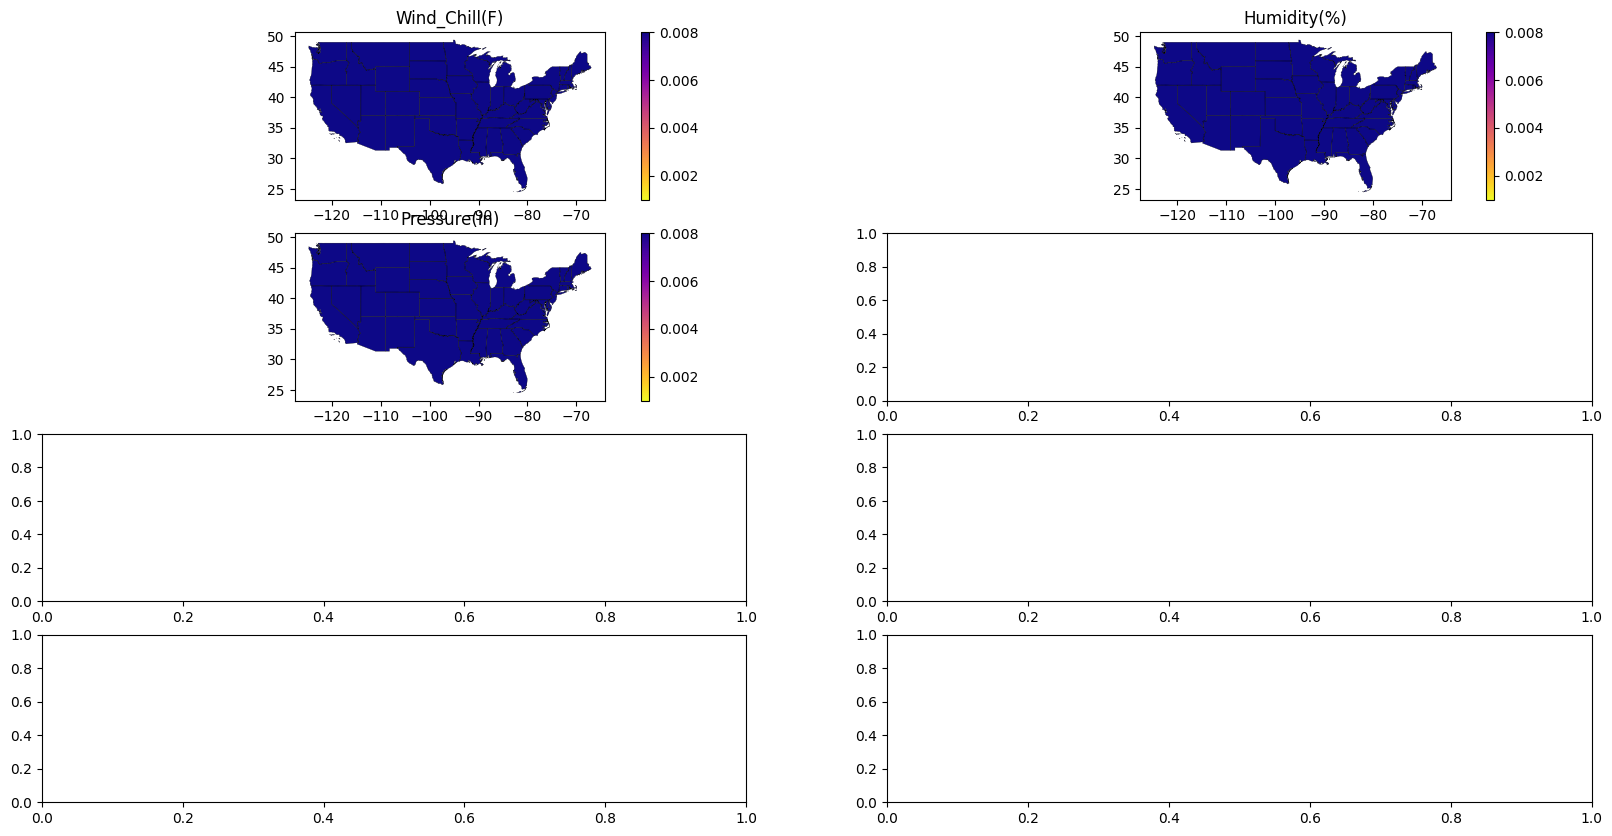

In [11]:
weather_conditions = ['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Direction',
                      'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']

fig , axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.ravel()



for i, feature in enumerate(weather_conditions):
    
    means_by_state = accident_data.groupby("STATEFP")[feature].mean().reset_index().rename(columns={feature: "means"})
    print(means_by_state)

    geographic_data = gpd.GeoDataFrame(means_by_state.merge(state_data, on='STATEFP'), geometry='geometry')
    print(geographic_data.columns)

    state_data.to_crs("5071")
    state_data.boundary.plot(linewidth=0.2, color='black', ax=axes[i])
    im = geographic_data.plot(column='means', legend=True, cmap='plasma_r', ax=axes[i], norm=norm)
    axes[i].set_title(feature)